### e10s-addons-beta49-week1: Main analysis

(This covers data from 2016-08-03 to 2016-08-13 on Beta 49)

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython
import pyspark.sql.functions as fun
from pyspark.sql import Row

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/histogram-whitelists.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

128

In [32]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def compare_histogram(histogram, e10s, none10s, include_diff = True):
    # Normalize individual histograms
    e10s = e10s.map(lambda x: x/x.sum())
    none10s = none10s.map(lambda x: x/x.sum())
    
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
    
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
    
    nrows = 2 if include_diff else 1
    ax = fig.add_subplot(nrows, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))])

    # If there are more than 100 labels, hide every other one so we can still read them
    if len(ax.get_xticklabels()) > 100:
        for label in ax.get_xticklabels()[::2]:
            label.set_visible(False)
    
    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    
    if include_diff:
        fig.add_subplot(2, 1, 2)
        enDiff = eTotal - nTotal
        enDiff.plot(kind="bar")
        
        plt.title("e10s/non-e10s difference (more e10s in bucket when > 0)")
        #plt.xlabel(histogram)
        plt.ylabel("Diff in frequency %")
    
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)

def normalize_uptime_hour(frame):
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    return frame
    
def compare_count_histograms(pings, *histograms_names):
    properties = histograms_names + ("payload/simpleMeasurements/totalTime", "e10s")

    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())

    e10s = frame[frame["e10s"] == True]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["e10s"] == False]
    none10s = normalize_uptime_hour(none10s)
    
    for histogram in e10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        compare_scalars(histogram + " per hour", e10s[histogram].dropna(), none10s[histogram].dropna())

        
def compare_histograms(pings, *histogram_names):
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s",) , with_processes=True).collect())
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    
    for histogram in none10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        has_children = np.sum(e10s[histogram + "_children"].notnull()) > 0
        has_parent = np.sum(e10s[histogram + "_parent"].notnull()) > 0
        
        if has_children and has_parent:
            compare_histogram(histogram + " (parent + children)", e10s[histogram].dropna(), none10s[histogram].dropna())

        if has_parent:
            compare_histogram(histogram + " (parent)", e10s[histogram + "_parent"].dropna(), none10s[histogram].dropna())

        if has_children:
            compare_histogram(histogram + " (children)", e10s[histogram + "_children"].dropna(), none10s[histogram].dropna())

def compare_scalars(metric, *groups):
    print "Median difference in {} is {:.2f}, ({:.2f}, {:.2f}).".format(metric,
                                                                        median_diff(*groups), 
                                                                        np.median(groups[0]),
                                                                        np.median(groups[1]))
    print "The probability of this effect being purely by chance is {:.2f}.". \
        format(grouped_permutation_test(median_diff, groups, num_samples=10000))

#### Get e10s and non-e10s partitions

In [4]:
dataset = sqlContext.read.parquet("s3://telemetry-parquet/e10s_experiment_view/e10s_addons_beta49_cohorts/v20160803_20160813/")
dataset.printSchema()

root
 |-- clientId: string (nullable = false)
 |-- e10sCohort: string (nullable = false)
 |-- creationTimestamp: string (nullable = false)
 |-- submissionDate: string (nullable = false)
 |-- documentId: string (nullable = false)
 |-- sampleId: integer (nullable = false)
 |-- buildId: string (nullable = false)
 |-- simpleMeasurements: string (nullable = false)
 |-- settings: string (nullable = false)
 |-- addons: string (nullable = false)
 |-- system: string (nullable = false)
 |-- build: string (nullable = false)
 |-- threadHangStats: string (nullable = false)
 |-- histograms: string (nullable = false)
 |-- keyedHistograms: string (nullable = false)
 |-- childPayloads: string (nullable = false)
 |-- processes: string (nullable = false)



How many records are in the overall dataset?

In [5]:
dataset.count()

2326301

What are the branches, and how many clients do we have in each branch?

In [6]:
%time cohort_counts = dataset.groupby("e10sCohort").count().collect()
dataset_count = sum(map(lambda r: r["count"], cohort_counts))

def cohort_proportions(r):
    prop = r["count"] * 100.0 / dataset_count
    return (r["e10sCohort"], r["count"], "{:.2f}%".format(prop))

print("\nTotal number of clients: {}".format(dataset_count))
sorted(map(cohort_proportions, cohort_counts), key = lambda r: r[0])

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 12.2 s

Total number of clients: 2326301


[(u'addons-set2a-control', 28762, '1.24%'),
 (u'addons-set2a-test', 28890, '1.24%'),
 (u'control', 453473, '19.49%'),
 (u'disqualified', 15, '0.00%'),
 (u'disqualified-control', 679339, '29.20%'),
 (u'disqualified-test', 679175, '29.20%'),
 (u'optedIn', 2794, '0.12%'),
 (u'optedOut', 9893, '0.43%'),
 (u'test', 441768, '18.99%'),
 (u'unknown', 2123, '0.09%'),
 (u'unsupportedChannel', 69, '0.00%')]

Restrict to pings belonging to the e10s add-ons experiment.

In [7]:
## Cache the add-ons experiment pings for ease of transformation.
addons_exp_dataset = dataset.filter("e10sCohort in ('addons-set2a-test', 'addons-set2a-control')")\
    .persist(StorageLevel.MEMORY_AND_DISK_SER)

How many pings are left?

In [8]:
addons_exp_dataset.count()

57652

We want to make sure that the pings tagged into the two cohorts satisfy the basic assumptions of the experiment, as this not guaranteed. All pings should have active addons, and e10s should be enabled if and only if the ping belongs to the test cohort.

In [9]:
def e10s_status_check(settings, addons):
    """ Check whether e10s is enabled, and whether there are add-ons. """
    e10sEnabled = json.loads(settings).get("e10sEnabled")
    active_addons = json.loads(addons).get("activeAddons")
    return Row(
        e10s_enabled = bool(e10sEnabled), 
        has_addons = bool(active_addons)
    )

def bad_ping(cohort, settings, addons):
    """ e10s should be enabled iff the profile is in the test cohort, and all profiles should have active add-ons. """
    check_data = e10s_status_check(settings, addons)
    return (cohort == "addons-set2a-test") != check_data.e10s_enabled or not check_data.has_addons

## Add a Column to the DF with the outcome of the check.
## This will be used to remove any bad rows after examining them.
from pyspark.sql.types import BooleanType
status_check_udf = fun.udf(bad_ping, BooleanType())
addons_exp_dataset_check = addons_exp_dataset.withColumn("badPing",
    status_check_udf(addons_exp_dataset.e10sCohort, addons_exp_dataset.settings, addons_exp_dataset.addons))

If there are any bad pings, describe the problems and remove them from the dataset.

In [10]:
addons_exp_dataset_bad = addons_exp_dataset_check.filter(addons_exp_dataset_check.badPing)\
    .select("e10sCohort", "settings", "addons")\
    .rdd

if addons_exp_dataset_bad.isEmpty():
    print("No issues")
else:
    check_counts = addons_exp_dataset_bad\
        .map(lambda r: (r.e10sCohort, e10s_status_check(r.settings, r.addons)))\
        .countByValue()
    print("Issues:")
    for k, v in check_counts.iteritems():
        print("{}: {}".format(k, v))
    print("\nRemoving these pings from the dataset.")
    addons_exp_dataset = addons_exp_dataset_check.filter(~addons_exp_dataset_check.badPing).drop("badPing")
    print("The dataset now contains {} clients".format(addons_exp_dataset.count()))

Issues:
(u'addons-set2a-test', Row(e10s_enabled=False, has_addons=True)): 9
(u'addons-set2a-test', Row(e10s_enabled=True, has_addons=False)): 60
(u'addons-set2a-control', Row(e10s_enabled=False, has_addons=False)): 79

Removing these pings from the dataset.
The dataset now contains 57504 clients


Transform Dataframe to RDD of pings

In [11]:
def row_2_ping(row):
    ping = {"payload": {"simpleMeasurements": json.loads(row.simpleMeasurements) if row.simpleMeasurements else {},
                        "histograms": json.loads(row.histograms) if row.histograms else {},
                        "keyedHistograms": json.loads(row.keyedHistograms) if row.keyedHistograms else {},
                        "childPayloads": json.loads(row.childPayloads) if row.childPayloads else {},
                        "threadHangStats": json.loads(row.threadHangStats)} if row.threadHangStats else {},
           "e10s": True if row.e10sCohort == "addons-set2a-test" else False,
           "system": json.loads(row.system)}
    return ping

In [12]:
def notxp(p):
    os = p.get("system", {}).get("os", {})
    return os["name"] != "Windows_NT" or os["version"] != "5.1"

subset = addons_exp_dataset.rdd.map(row_2_ping).filter(notxp)

In [13]:
def add_gecko_activity(ping):
    uptime = ping["payload"].get("simpleMeasurements", {}).get("totalTime", -1) / 60
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        child_uptime = payload.get("simpleMeasurements", {}).get("totalTime", -1) / 60
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)
## Cache the restructured pings to speed up the comparison computations.
subset.persist(StorageLevel.MEMORY_AND_DISK_SER)
addons_exp_dataset = addons_exp_dataset.unpersist()

How many pings are we working with at this point?

In [14]:
subset.count()

57385

## 1. Generic stuff

In [15]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/firstLoadURI",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/sessionRestoreInit",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "parent_hangs_per_minute",
    "child_hangs_per_minute"]).collect())

eSimple = simple[simple["e10s"] == True]
nSimple = simple[simple["e10s"] == False]
len(eSimple), len(nSimple)

(28746, 28639)

#### a) Startup time evaluation:

In [16]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstPaint"].dropna(), nSimple["payload/simpleMeasurements/firstPaint"].dropna())

Median difference in startup time is 60.00, (4309.00, 4249.00).
The probability of this effect being purely by chance is 0.21.


In [17]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstLoadURI"].dropna(), nSimple["payload/simpleMeasurements/firstLoadURI"].dropna())

Median difference in startup time is 5893.50, (10288.50, 4395.00).
The probability of this effect being purely by chance is 0.00.


#### b) Shutdown time evaluation:

In [18]:
compare_scalars("shutdown duration", eSimple["payload/simpleMeasurements/shutdownDuration"].dropna(), nSimple["payload/simpleMeasurements/shutdownDuration"].dropna())

Median difference in shutdown duration is 38.00, (1365.00, 1327.00).
The probability of this effect being purely by chance is 0.00.


#### c) Animation smoothness:

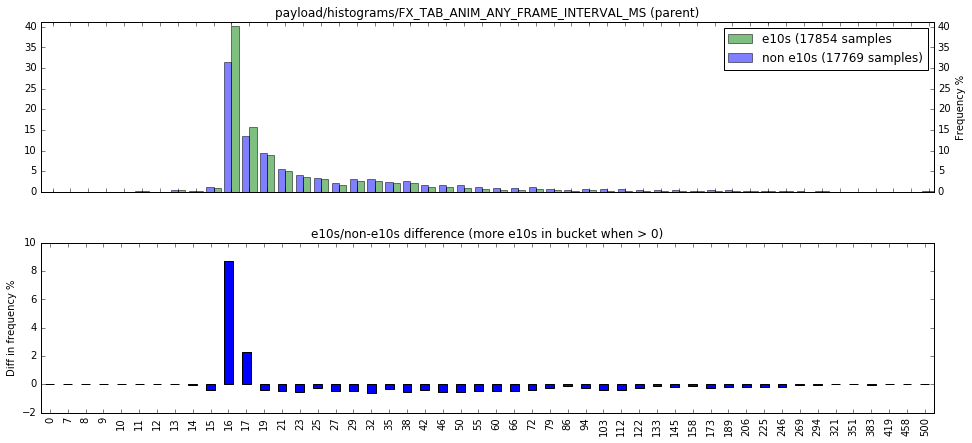

The probability that the distributions for payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


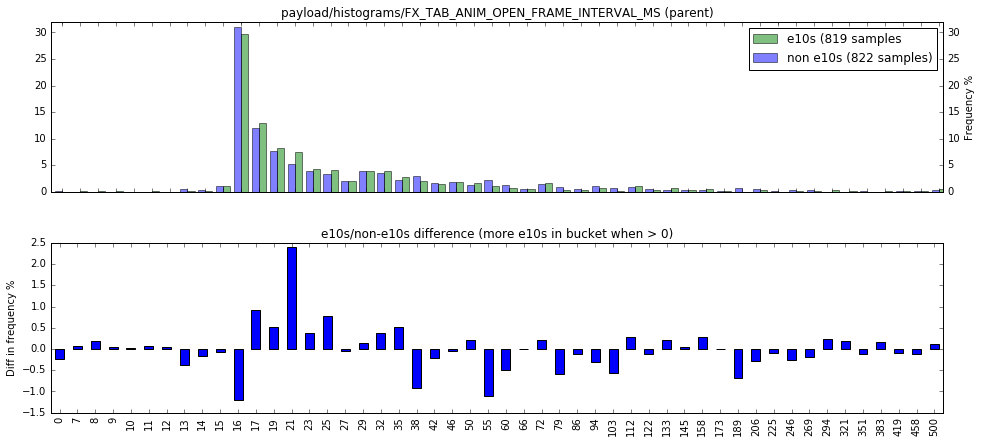

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS (parent) are differing by chance is 0.24.


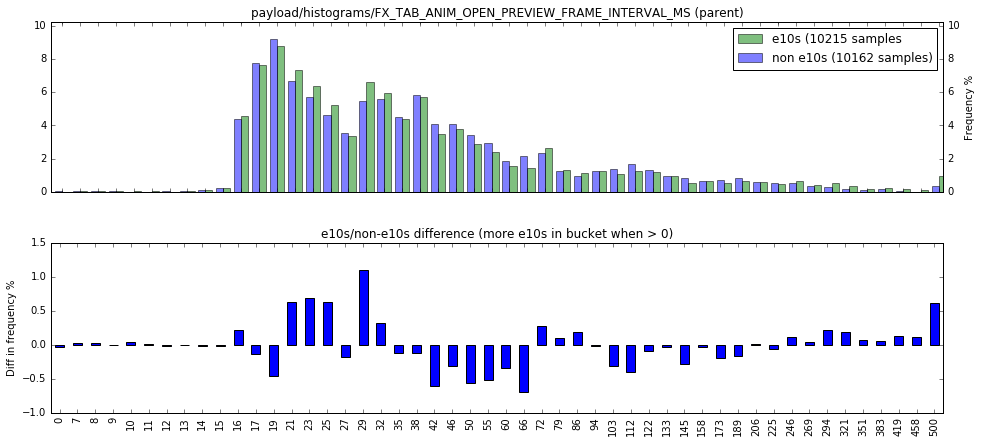

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


In [33]:
compare_histograms(subset,
                   "payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS")

#### d) Graphics:

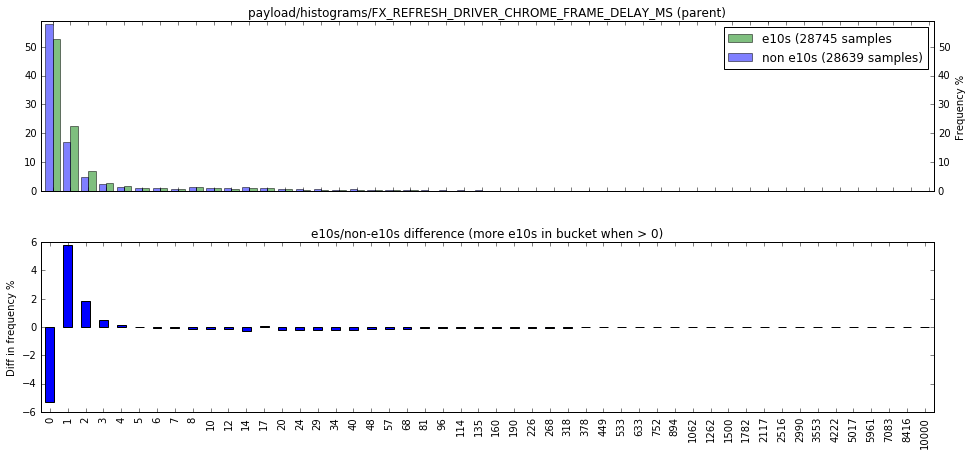

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_CHROME_FRAME_DELAY_MS (parent) are differing by chance is 0.00.


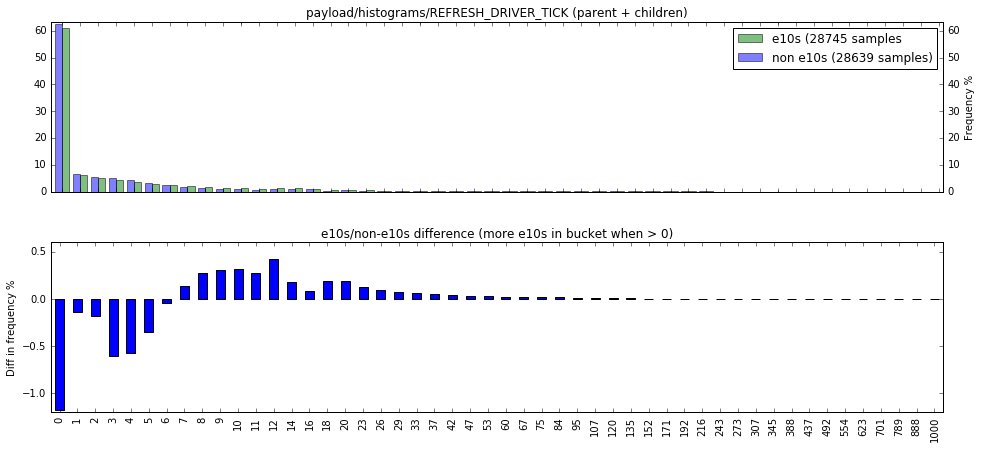

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent + children) are differing by chance is 0.00.


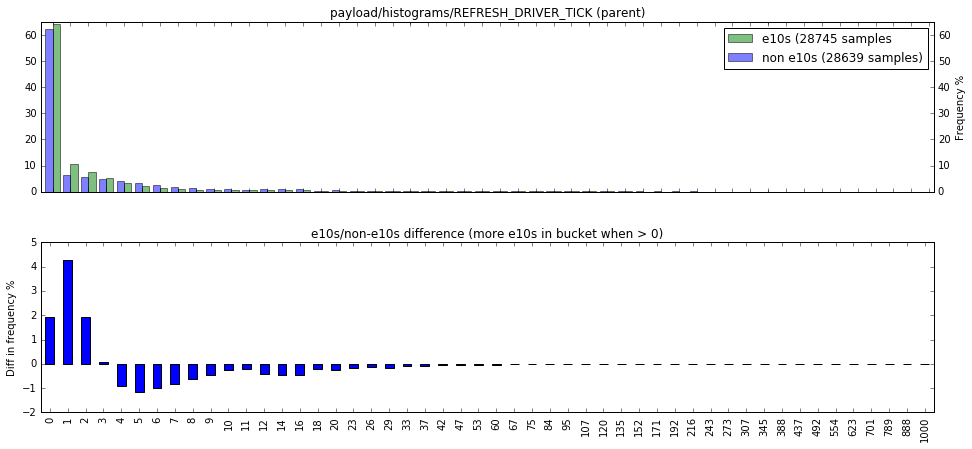

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent) are differing by chance is 0.00.


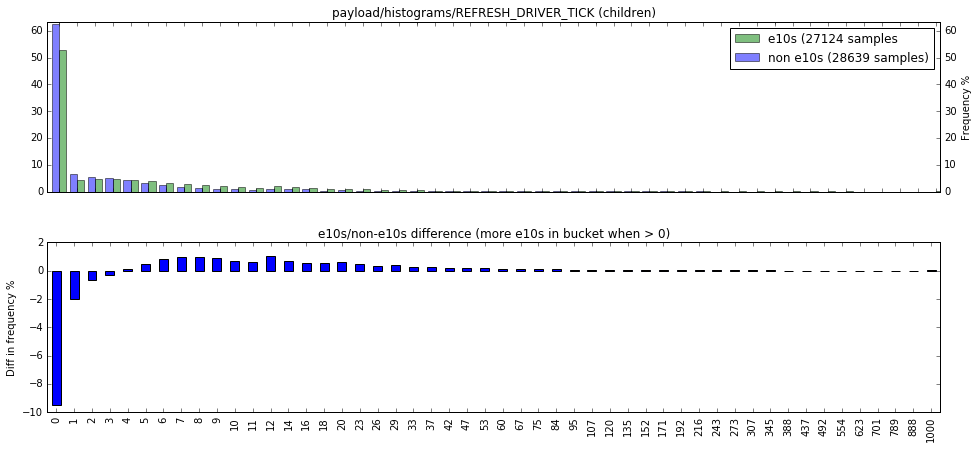

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (children) are differing by chance is 0.00.


In [34]:
compare_histograms(subset, "payload/histograms/REFRESH_DRIVER_TICK",
                           "payload/histograms/FX_REFRESH_DRIVER_CHROME_FRAME_DELAY_MS")

## 2. Responsivness

#### a) Event processing

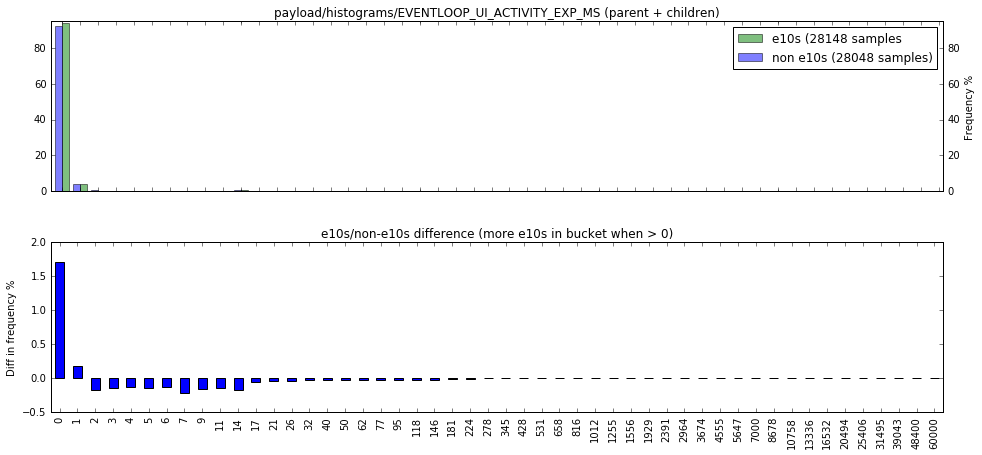

The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (parent + children) are differing by chance is 0.00.


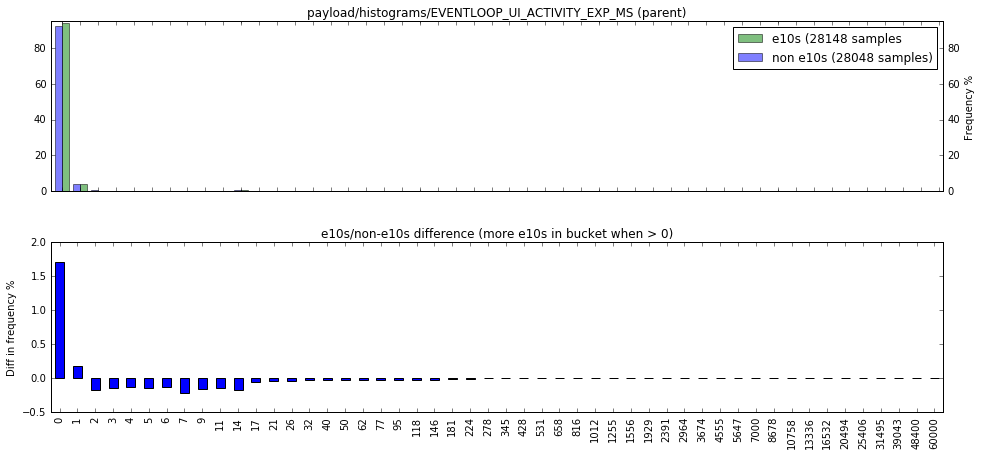

The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (parent) are differing by chance is 0.00.


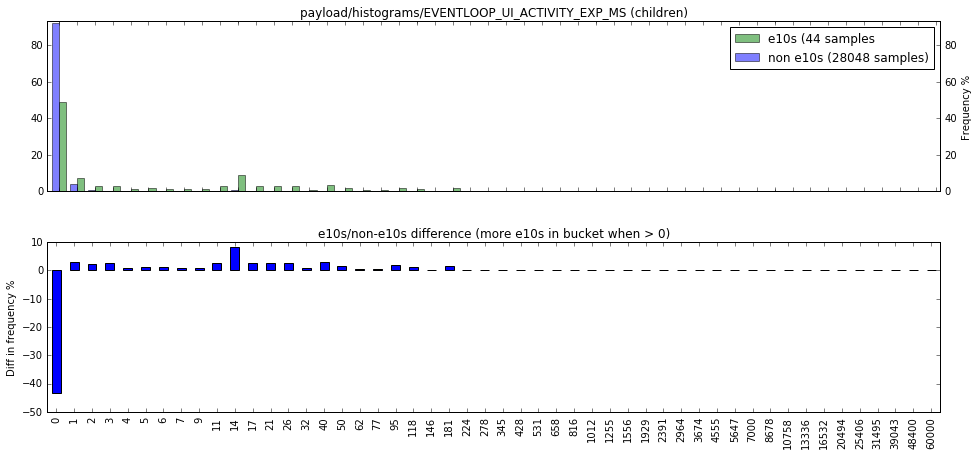

The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (children) are differing by chance is 0.00.


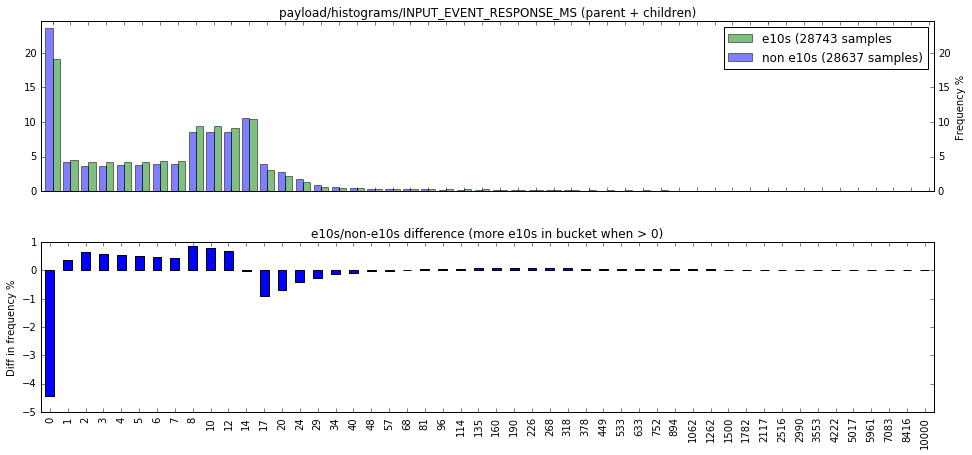

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent + children) are differing by chance is 0.00.


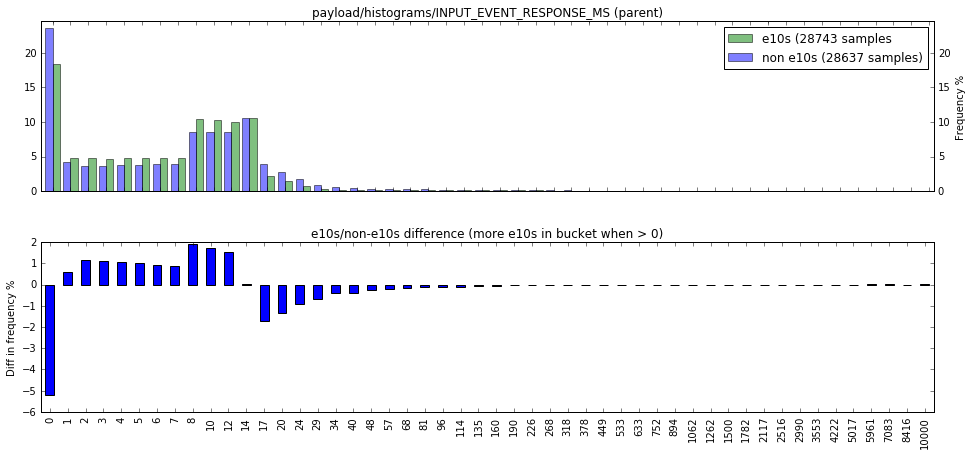

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent) are differing by chance is 0.00.


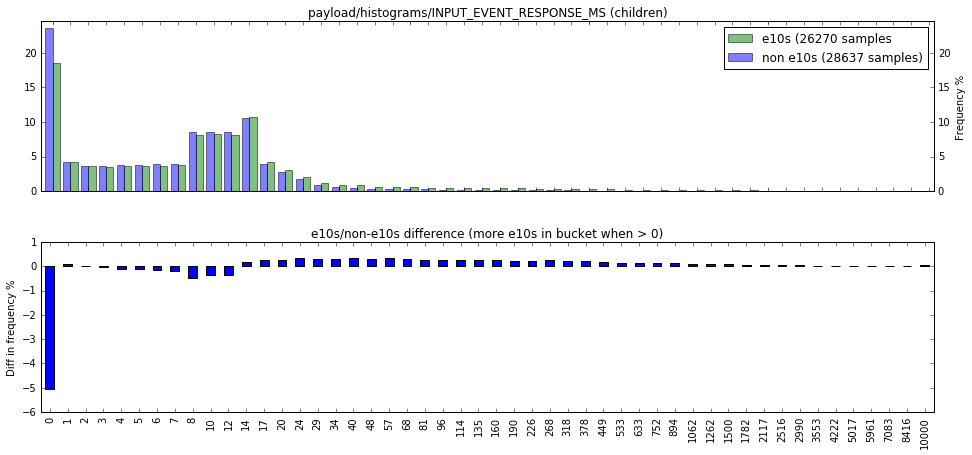

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (children) are differing by chance is 0.00.


In [35]:
compare_histograms(subset, "payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS",
                           "payload/histograms/INPUT_EVENT_RESPONSE_MS")

In [36]:
compare_scalars("hangs over 100ms per minute (parent)",
                eSimple["parent_hangs_per_minute"].dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

Median difference in hangs over 100ms per minute (parent) is -3.04, (0.98, 4.01).
The probability of this effect being purely by chance is 0.00.


In [37]:
compare_scalars("hangs over 100ms per minute (parent + child)",
                (eSimple["child_hangs_per_minute"] + eSimple["parent_hangs_per_minute"]).dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

Median difference in hangs over 100ms per minute (parent + child) is 1.09, (5.10, 4.01).
The probability of this effect being purely by chance is 0.00.


#### b) Plugins

In [38]:
compare_count_histograms(subset, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin")

Median difference in payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin per hour is 0.14, (0.39, 0.25).
The probability of this effect being purely by chance is 0.02.


#### c) Page load

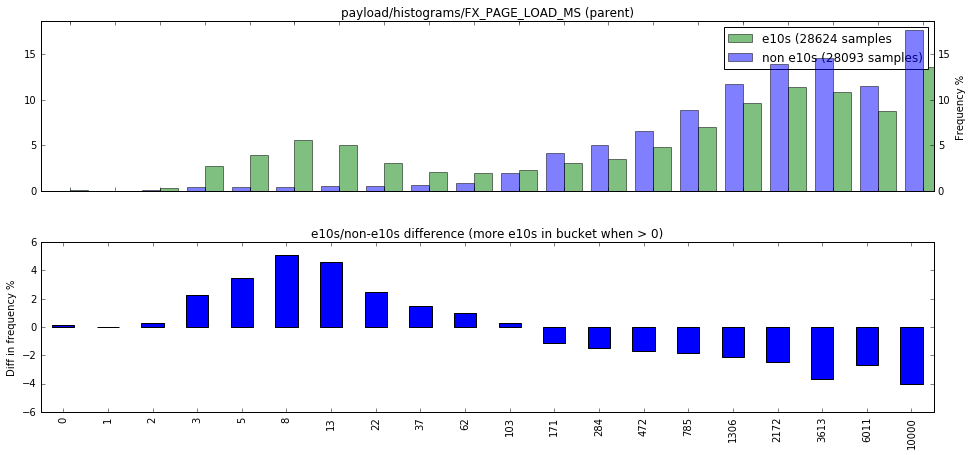

The probability that the distributions for payload/histograms/FX_PAGE_LOAD_MS (parent) are differing by chance is 0.00.


In [39]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

#### d) Slow scripts

In [40]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT")

Median difference in payload/histograms/SLOW_SCRIPT_NOTICE_COUNT per hour is 0.18, (0.55, 0.37).
The probability of this effect being purely by chance is 0.00.


In [41]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

Median difference in payload/histograms/SLOW_SCRIPT_PAGE_COUNT per hour is -0.04, (0.31, 0.35).
The probability of this effect being purely by chance is 0.05.


#### e) Window open time

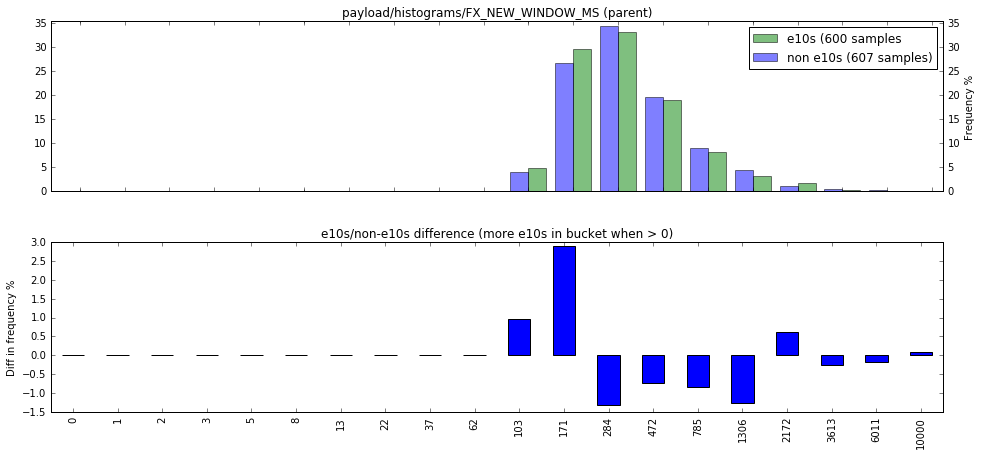

The probability that the distributions for payload/histograms/FX_NEW_WINDOW_MS (parent) are differing by chance is 0.68.


In [42]:
compare_histograms(subset, "payload/histograms/FX_NEW_WINDOW_MS")

#### f) Garbage collection

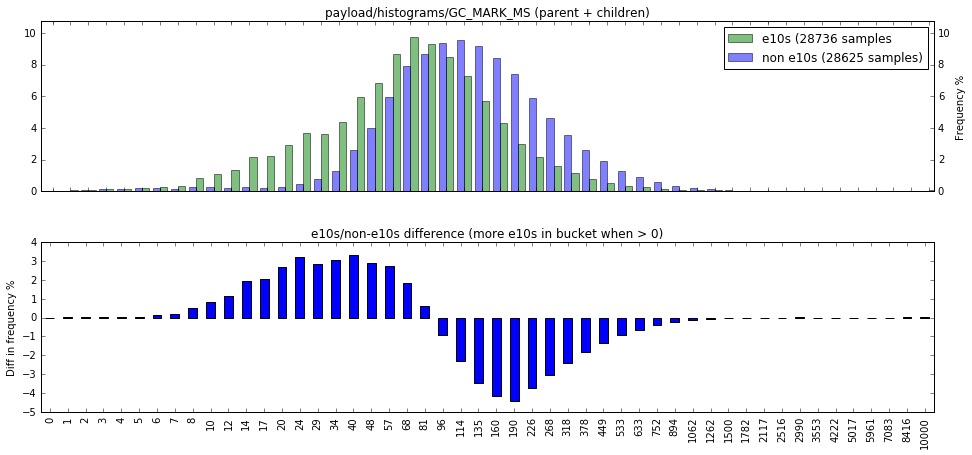

The probability that the distributions for payload/histograms/GC_MARK_MS (parent + children) are differing by chance is 0.00.


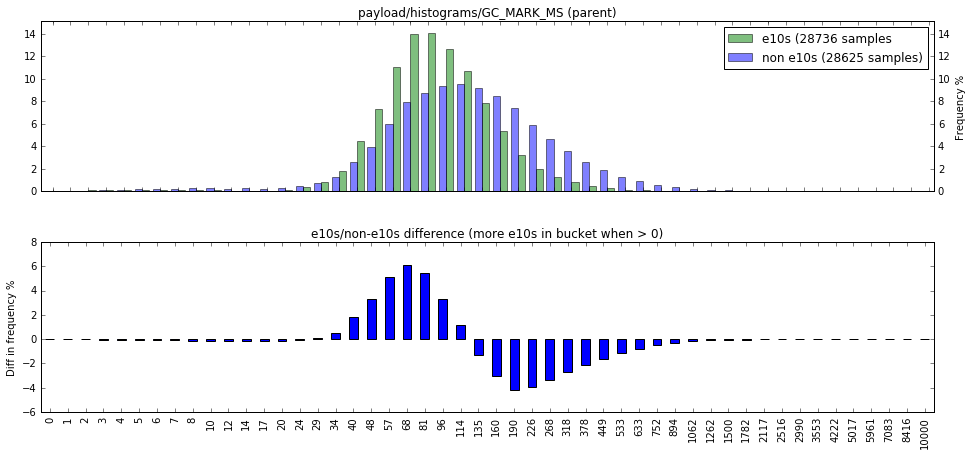

The probability that the distributions for payload/histograms/GC_MARK_MS (parent) are differing by chance is 0.00.


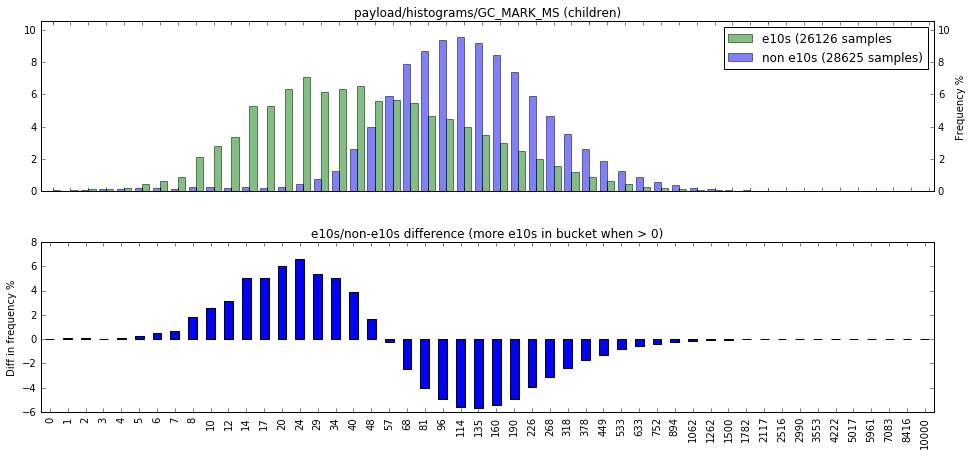

The probability that the distributions for payload/histograms/GC_MARK_MS (children) are differing by chance is 0.00.


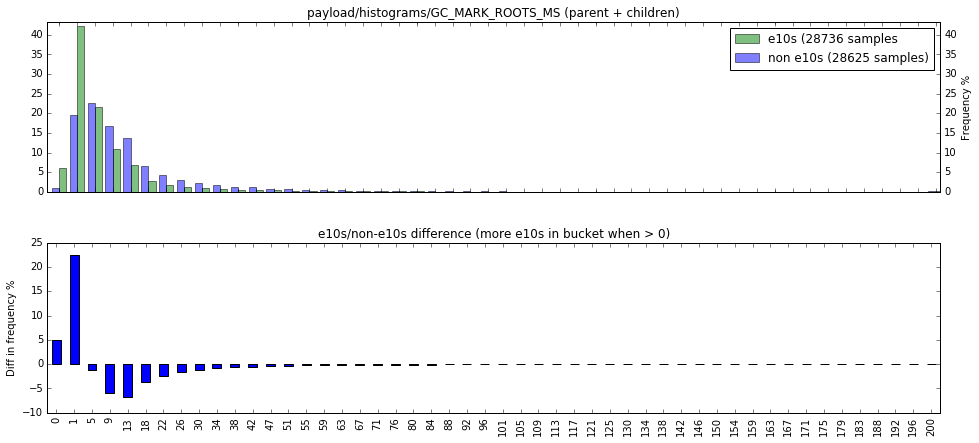

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent + children) are differing by chance is 0.00.


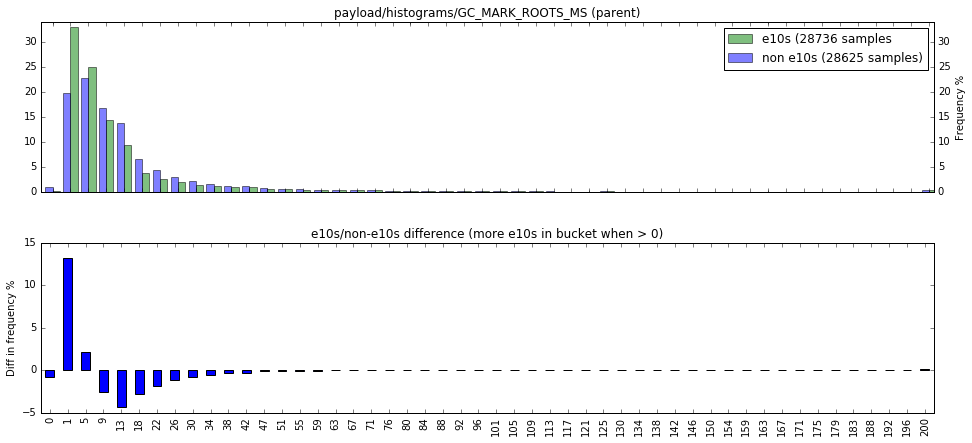

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent) are differing by chance is 0.00.


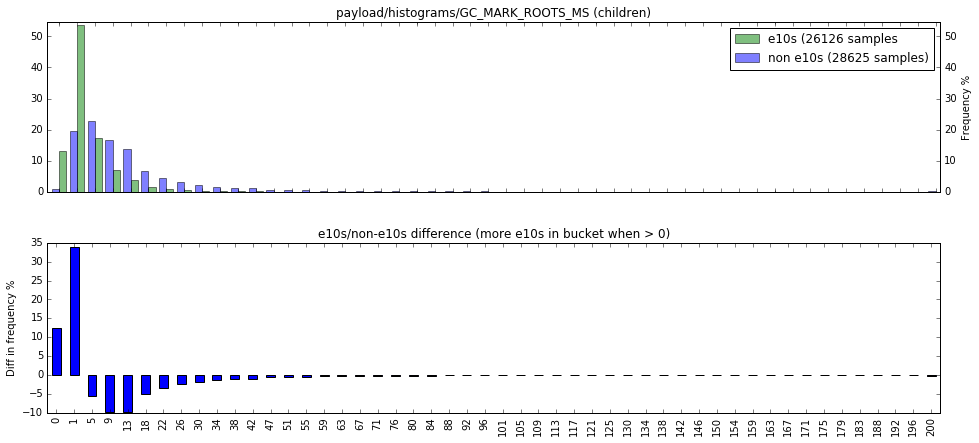

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (children) are differing by chance is 0.00.


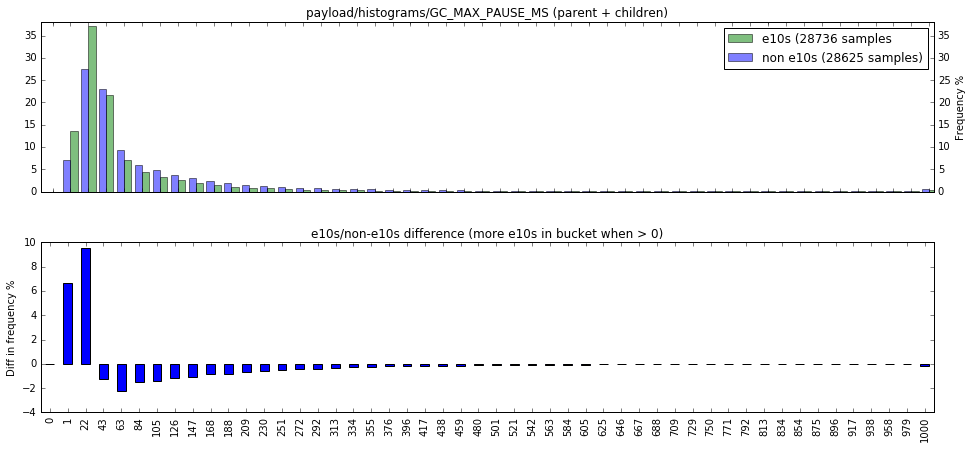

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


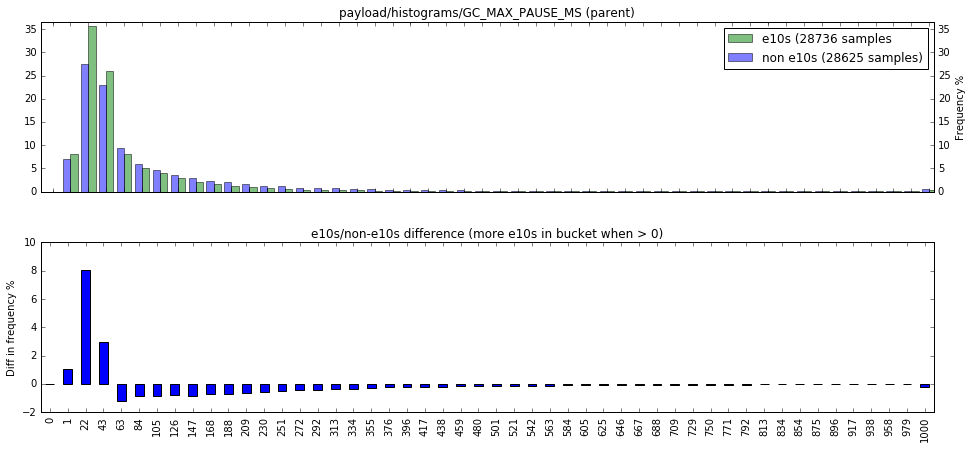

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


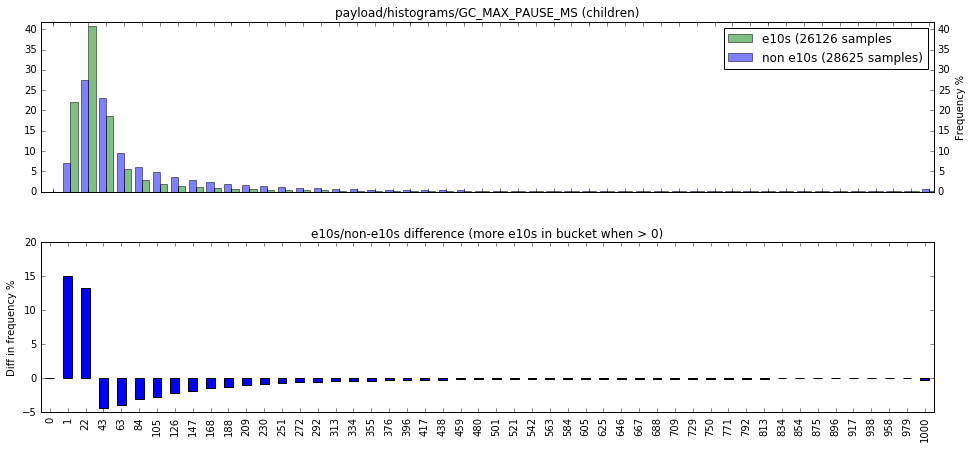

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (children) are differing by chance is 0.00.


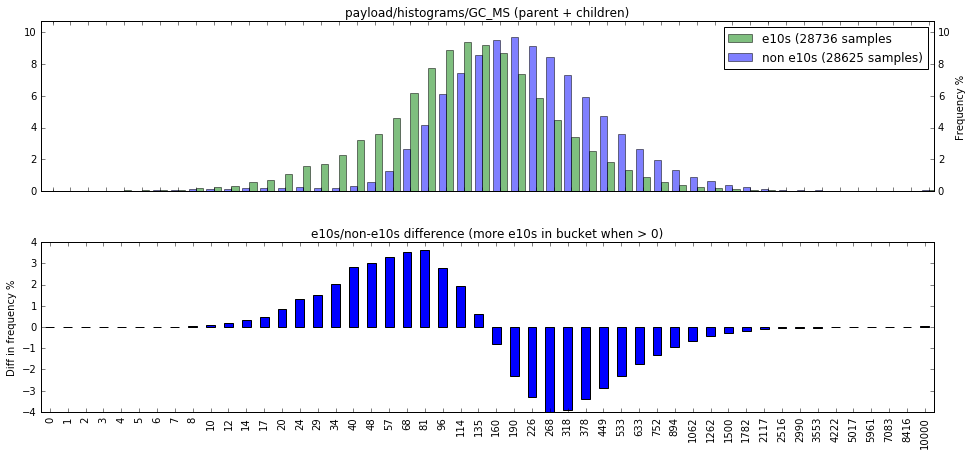

The probability that the distributions for payload/histograms/GC_MS (parent + children) are differing by chance is 0.00.


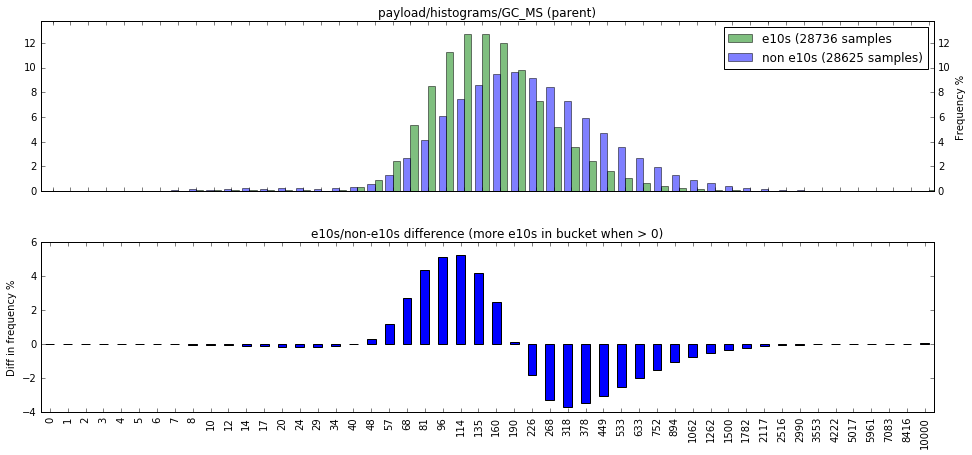

The probability that the distributions for payload/histograms/GC_MS (parent) are differing by chance is 0.00.


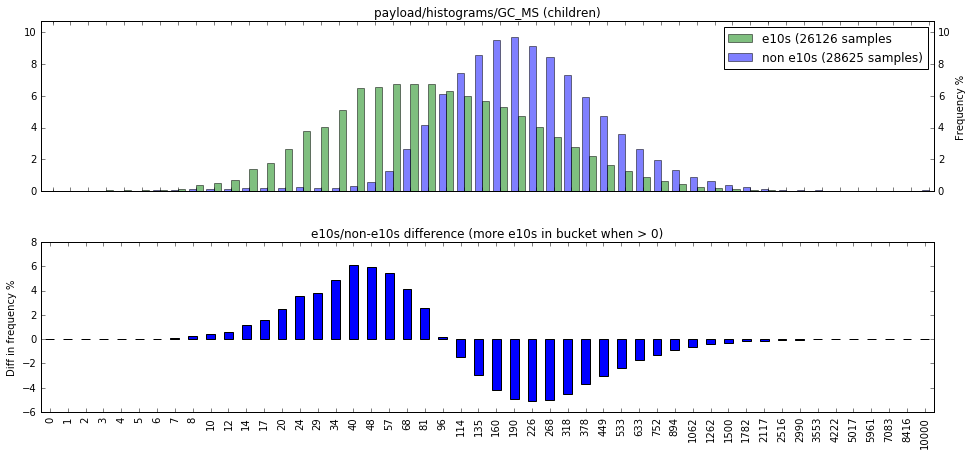

The probability that the distributions for payload/histograms/GC_MS (children) are differing by chance is 0.00.


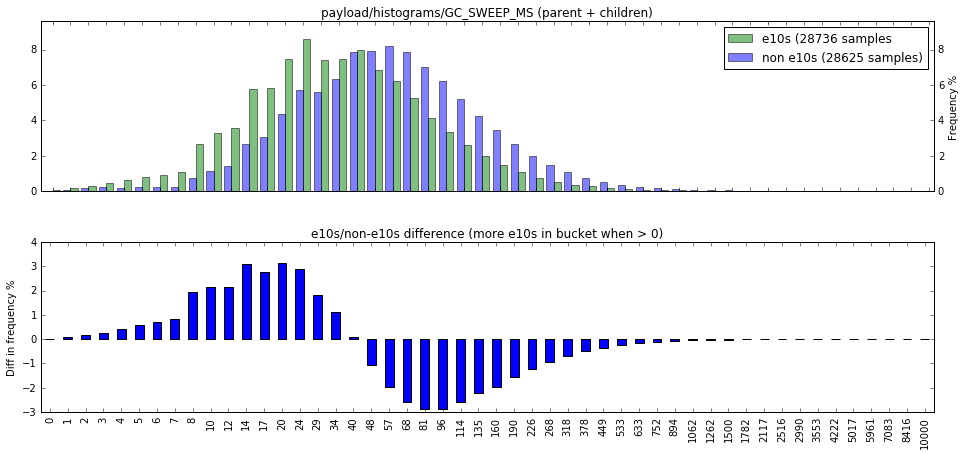

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent + children) are differing by chance is 0.00.


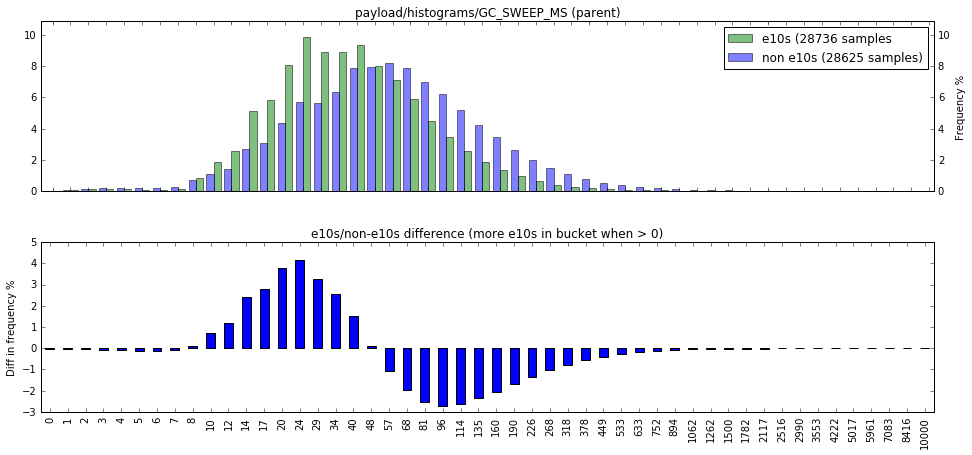

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent) are differing by chance is 0.00.


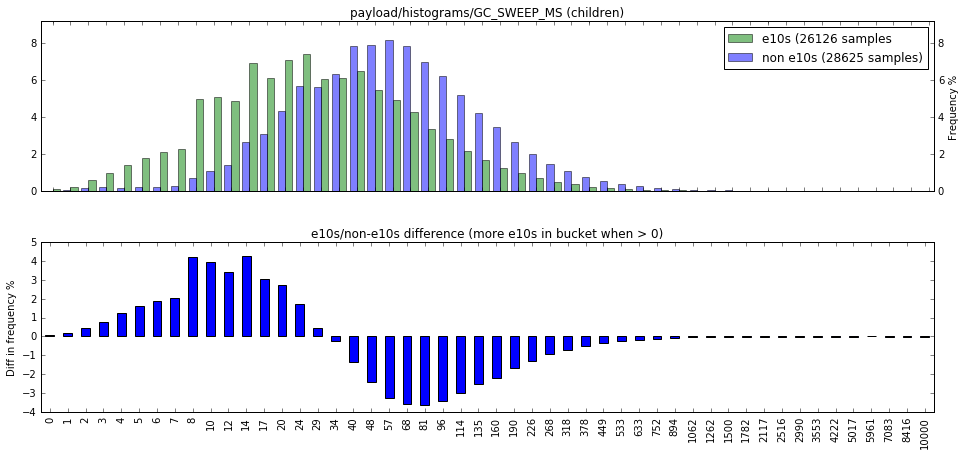

The probability that the distributions for payload/histograms/GC_SWEEP_MS (children) are differing by chance is 0.00.


In [43]:
compare_histograms(subset, 
                   "payload/histograms/GC_MS", 
                   "payload/histograms/GC_MAX_PAUSE_MS", 
                   "payload/histograms/GC_MARK_MS", 
                   "payload/histograms/GC_SWEEP_MS", 
                   "payload/histograms/GC_MARK_ROOTS_MS")

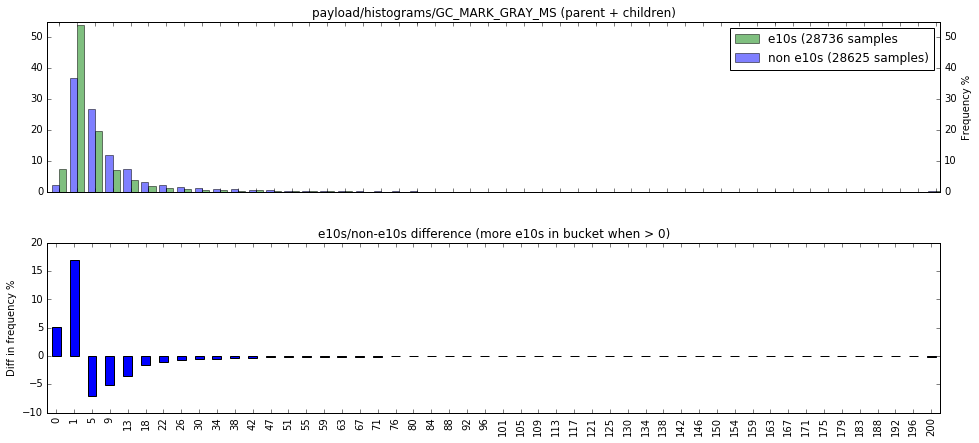

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent + children) are differing by chance is 0.00.


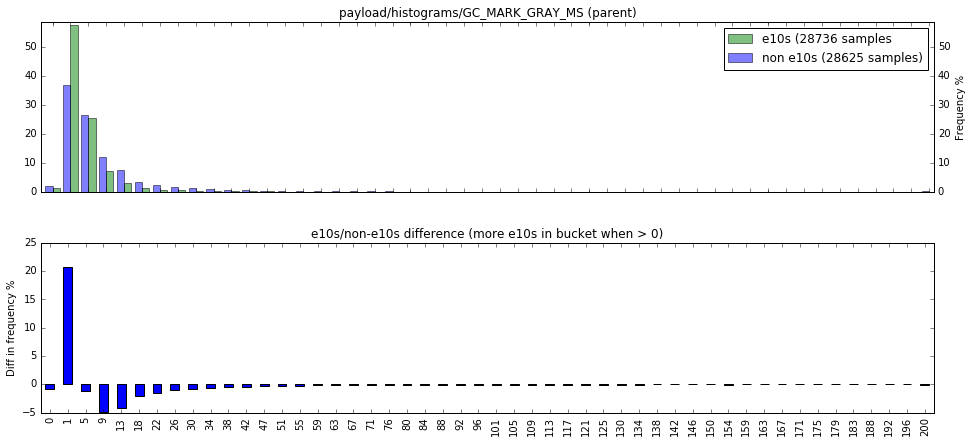

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent) are differing by chance is 0.00.


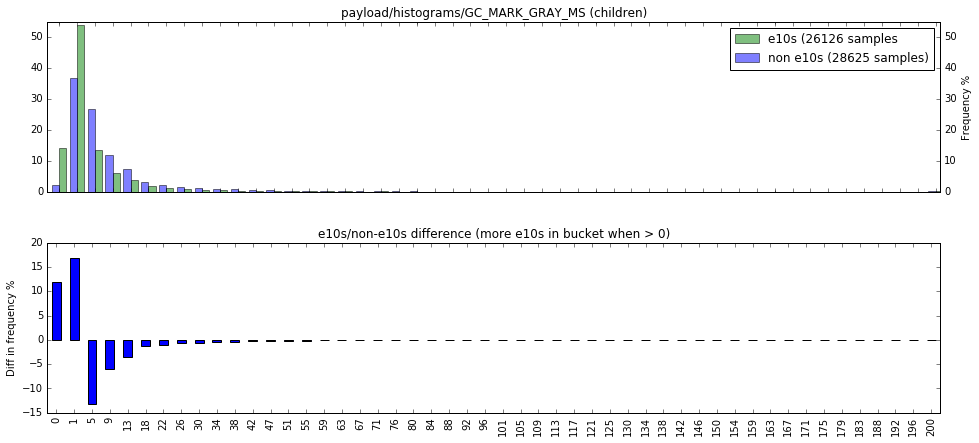

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (children) are differing by chance is 0.00.


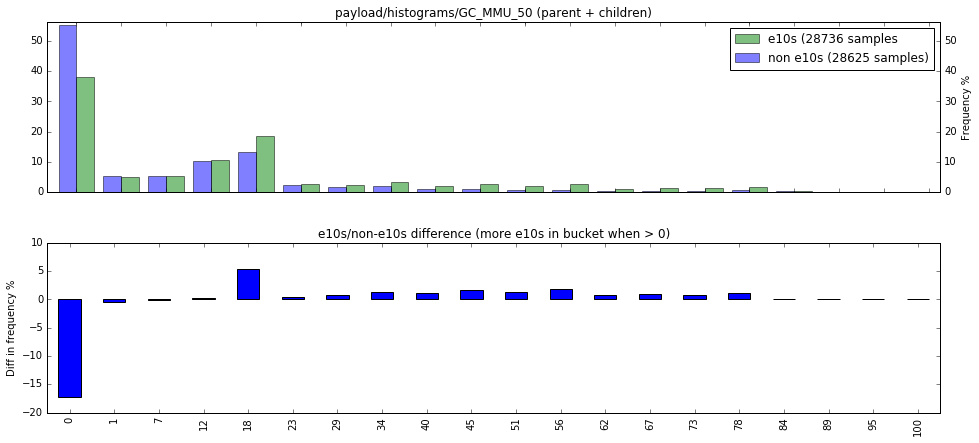

The probability that the distributions for payload/histograms/GC_MMU_50 (parent + children) are differing by chance is 0.00.


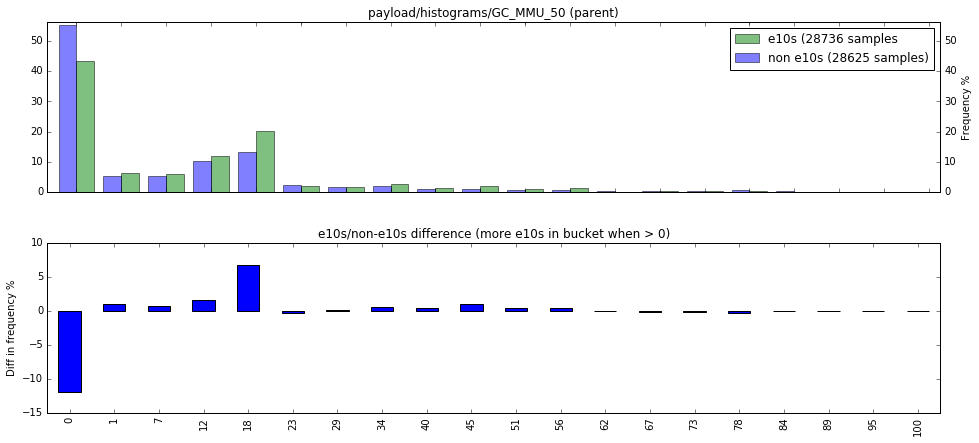

The probability that the distributions for payload/histograms/GC_MMU_50 (parent) are differing by chance is 0.00.


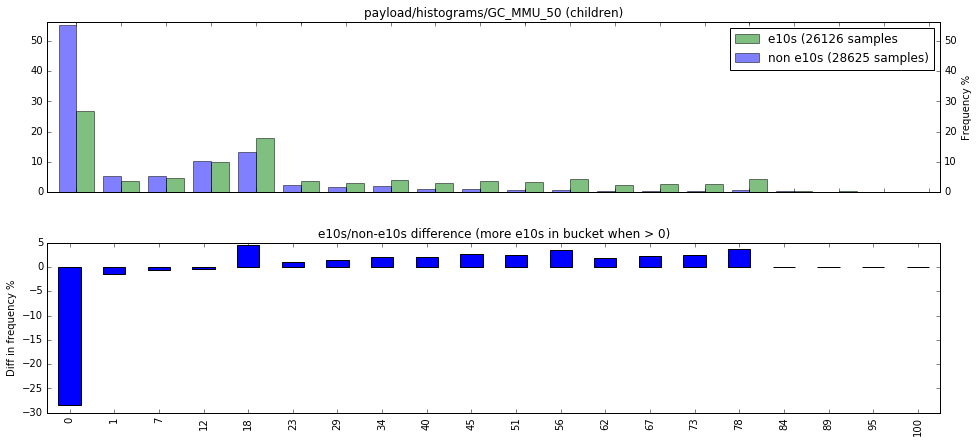

The probability that the distributions for payload/histograms/GC_MMU_50 (children) are differing by chance is 0.00.


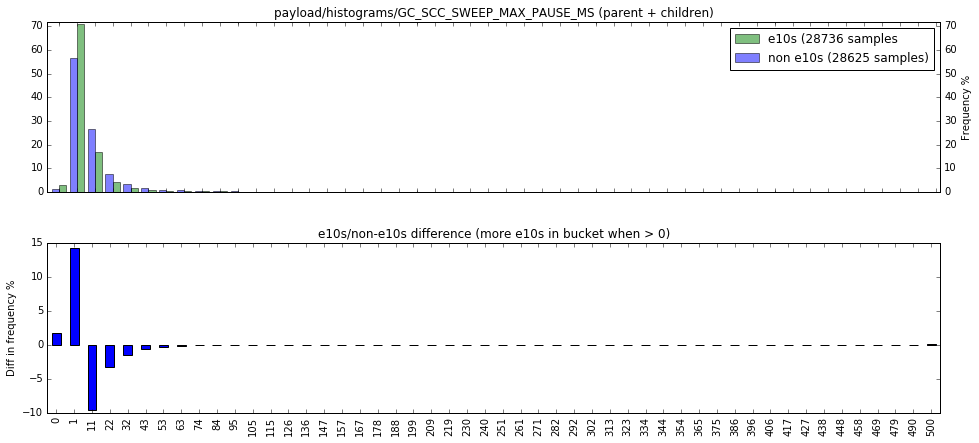

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


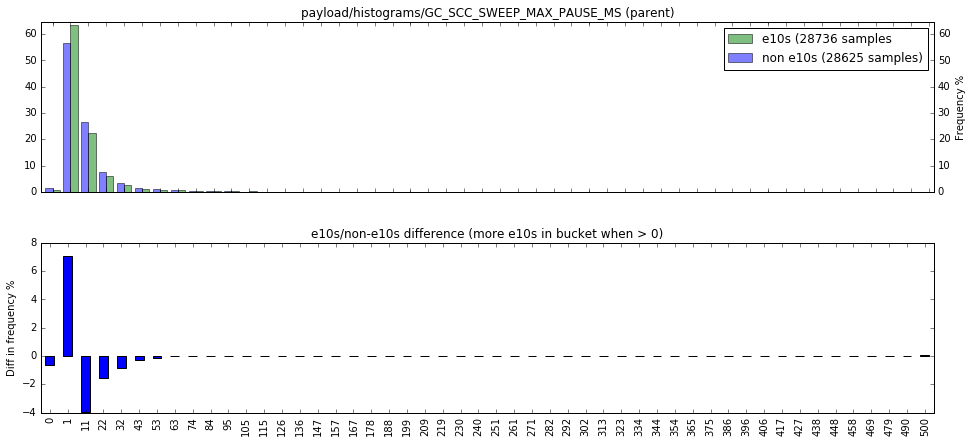

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


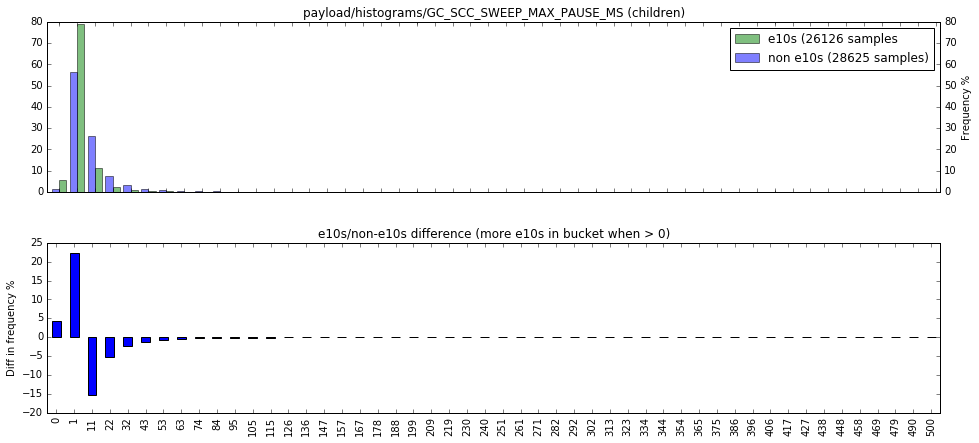

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (children) are differing by chance is 0.00.


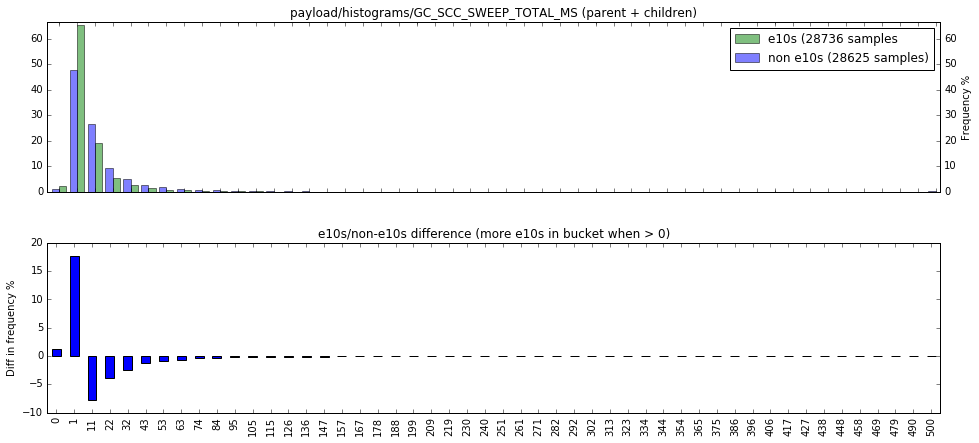

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent + children) are differing by chance is 0.00.


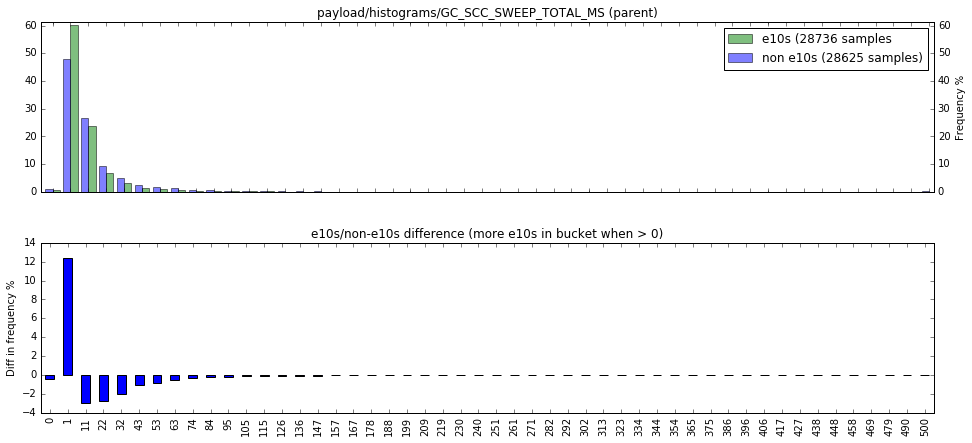

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent) are differing by chance is 0.00.


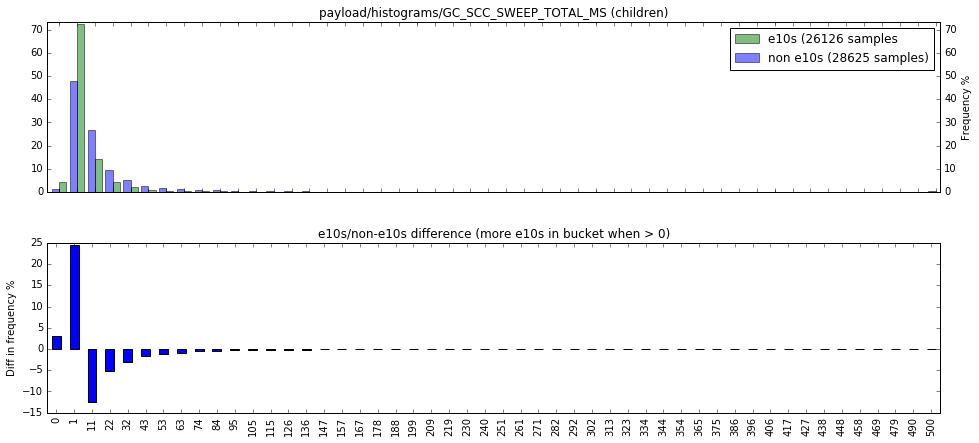

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (children) are differing by chance is 0.00.


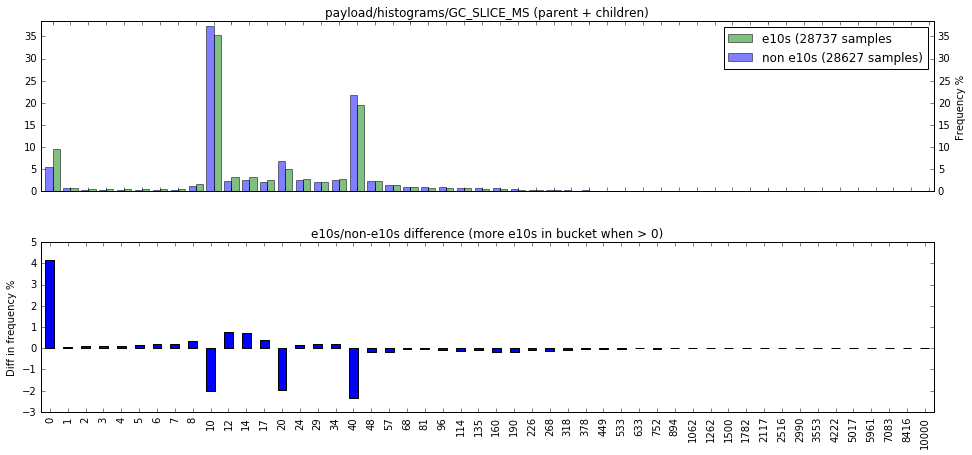

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent + children) are differing by chance is 0.00.


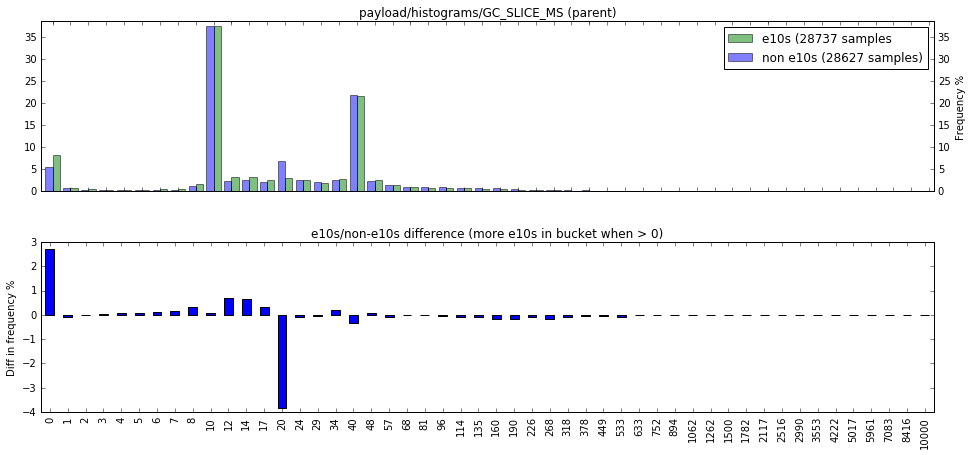

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent) are differing by chance is 0.00.


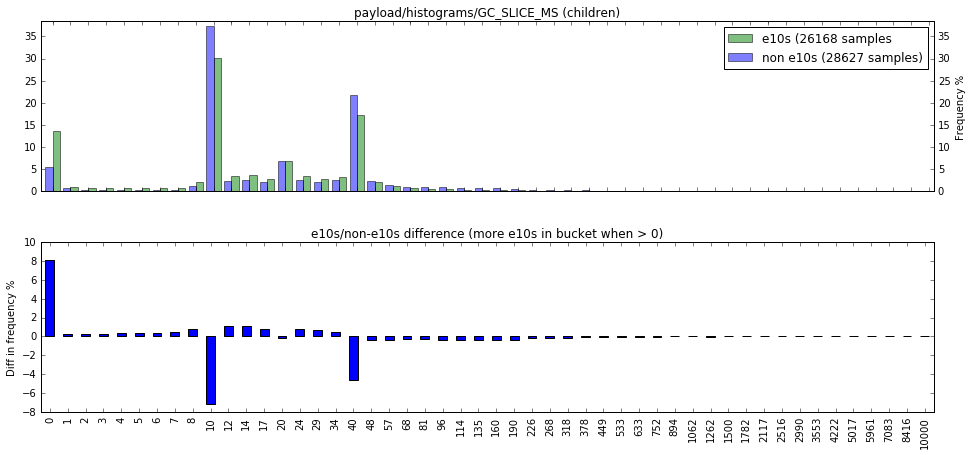

The probability that the distributions for payload/histograms/GC_SLICE_MS (children) are differing by chance is 0.00.


In [44]:
compare_histograms(subset,
                   "payload/histograms/GC_MMU_50",
                   "payload/histograms/GC_MARK_GRAY_MS",
                   "payload/histograms/GC_SLICE_MS",
                   "payload/histograms/GC_SCC_SWEEP_TOTAL_MS",
                   "payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS")

#### g) Cycle Collector

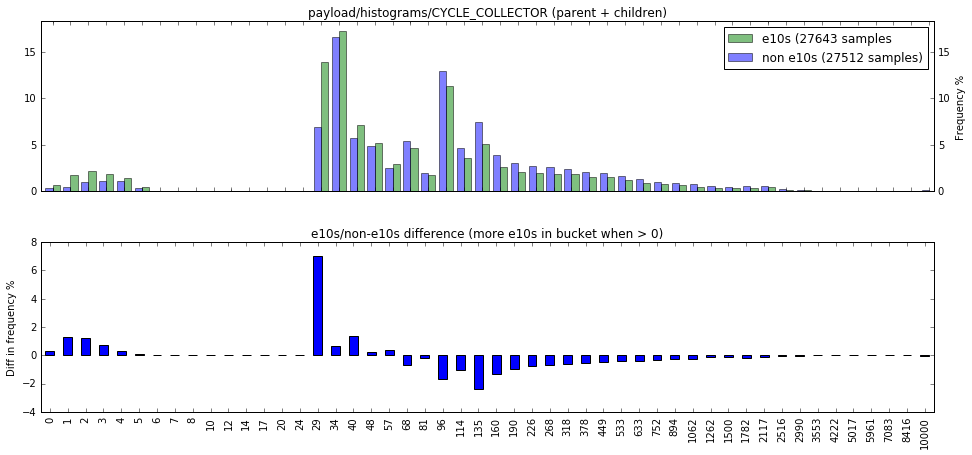

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent + children) are differing by chance is 0.00.


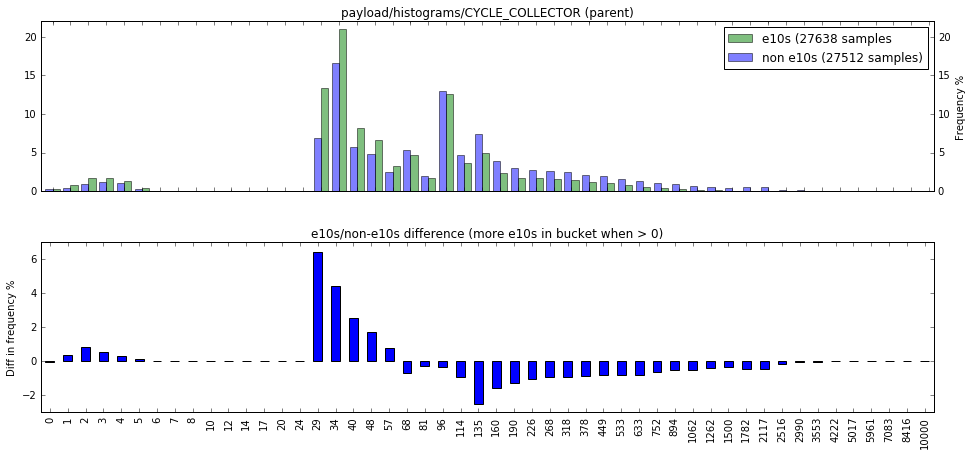

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent) are differing by chance is 0.00.


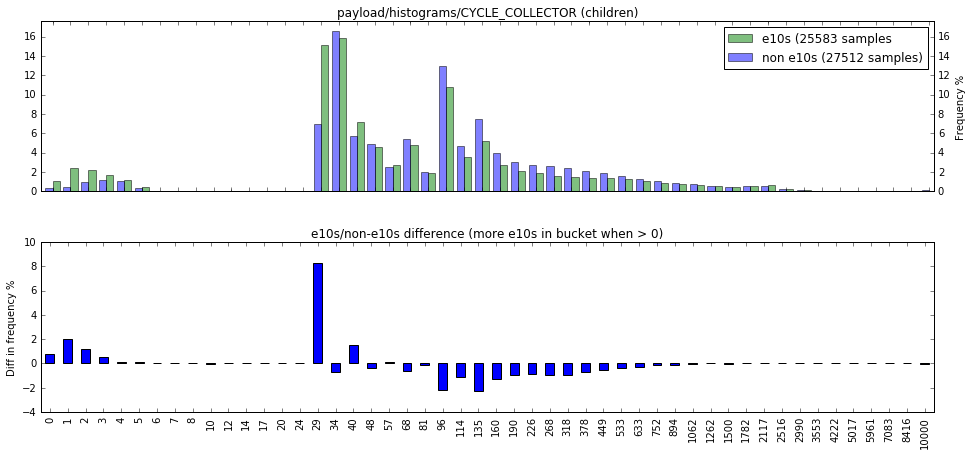

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (children) are differing by chance is 0.00.


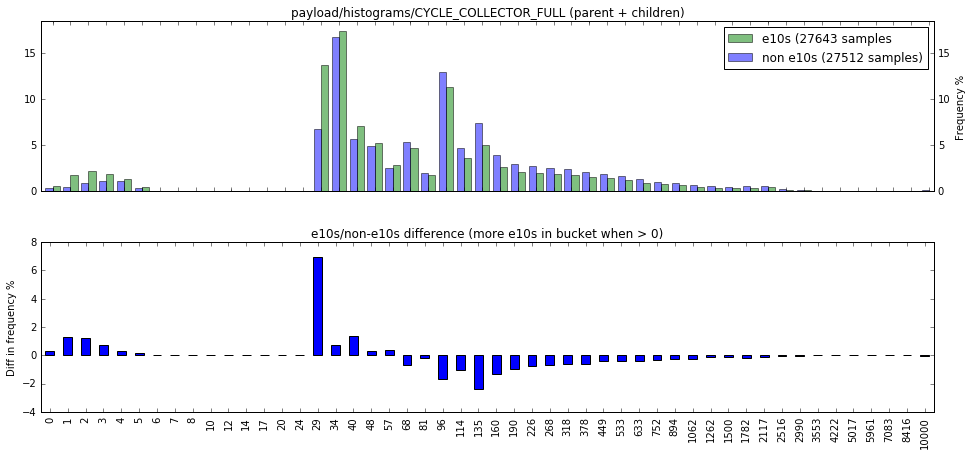

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent + children) are differing by chance is 0.00.


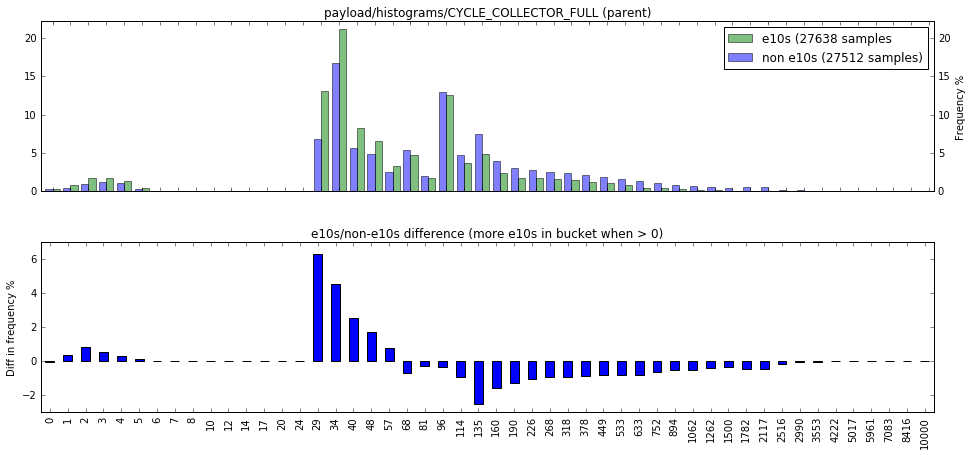

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent) are differing by chance is 0.00.


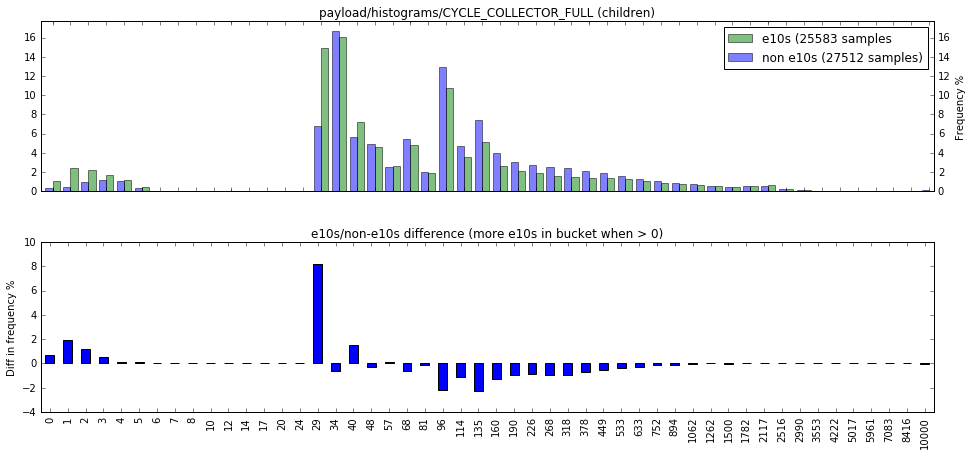

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (children) are differing by chance is 0.00.


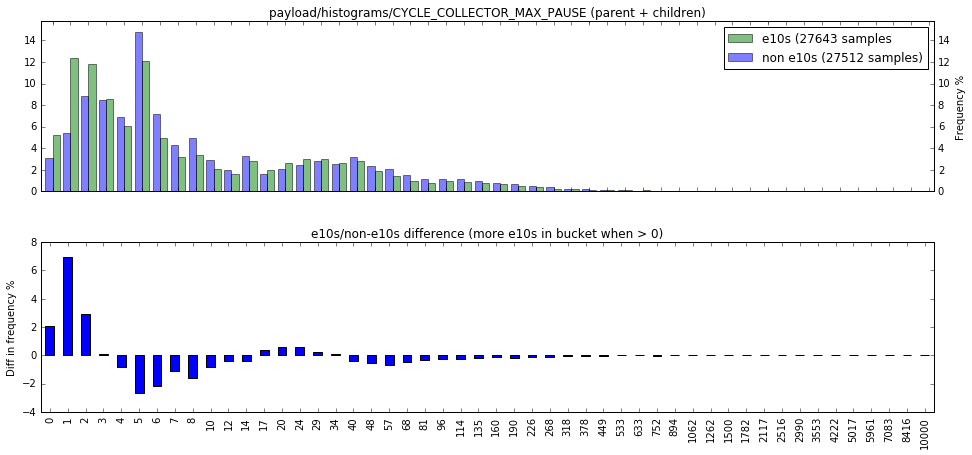

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent + children) are differing by chance is 0.00.


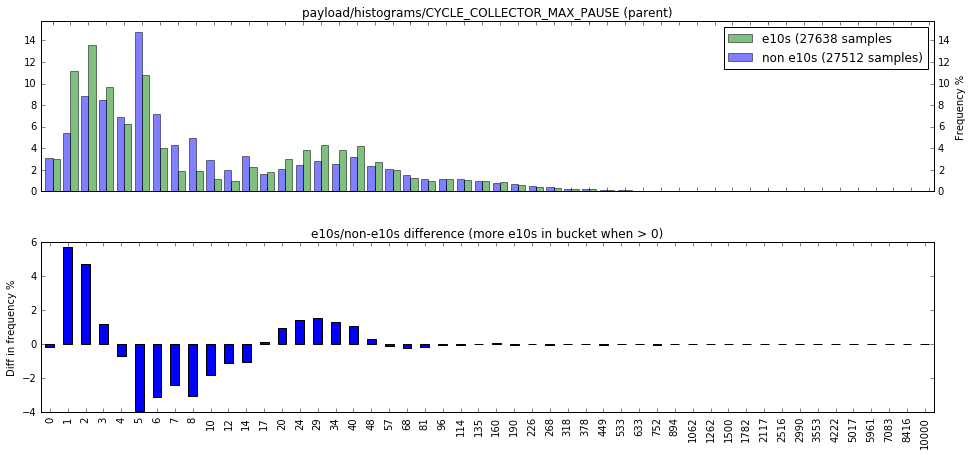

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent) are differing by chance is 0.00.


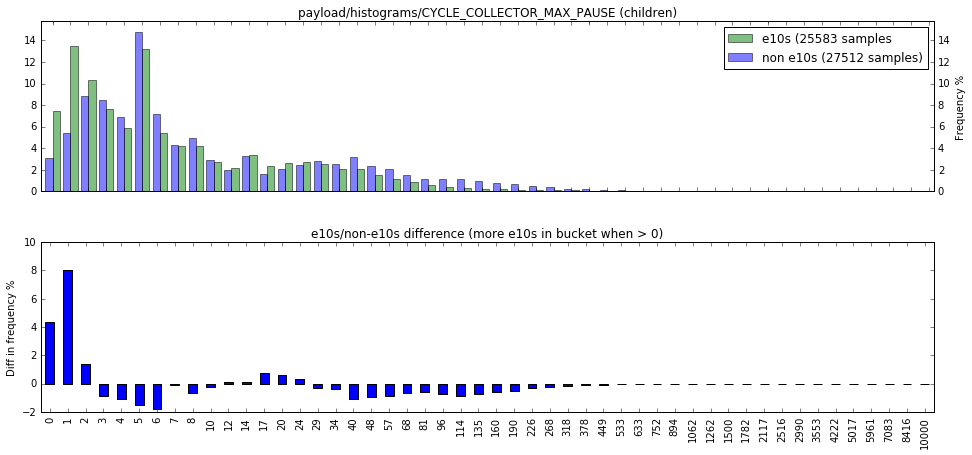

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (children) are differing by chance is 0.00.


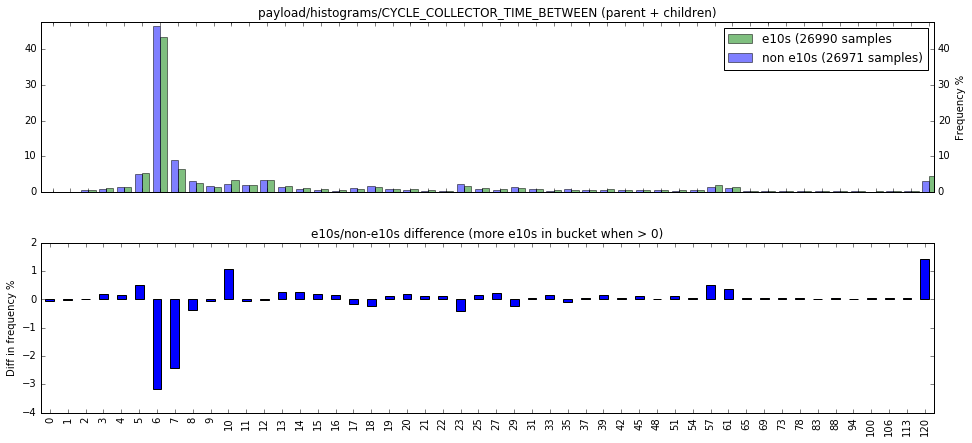

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent + children) are differing by chance is 0.00.


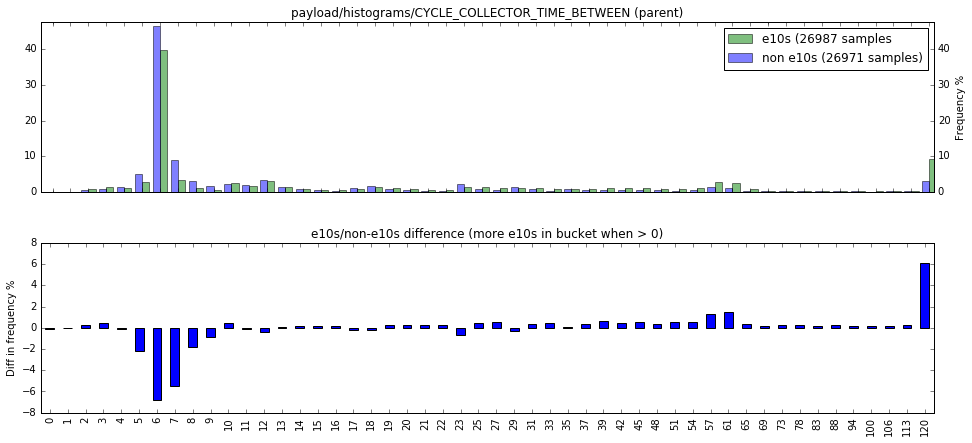

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent) are differing by chance is 0.00.


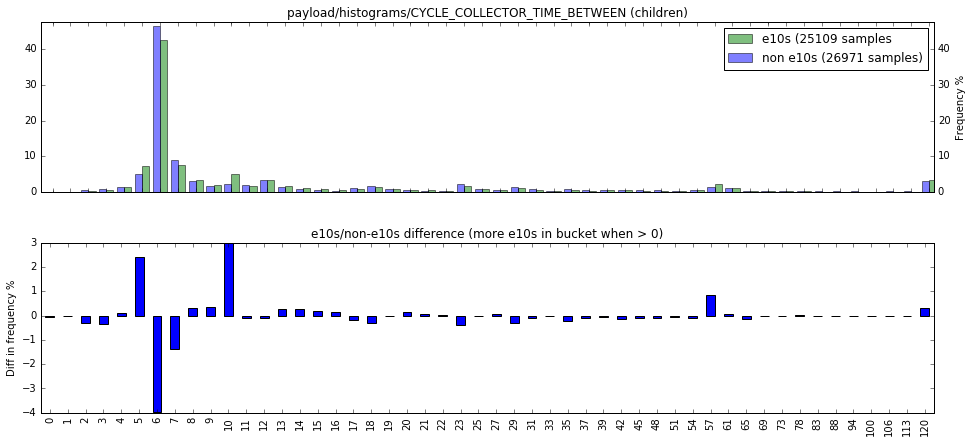

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (children) are differing by chance is 0.00.


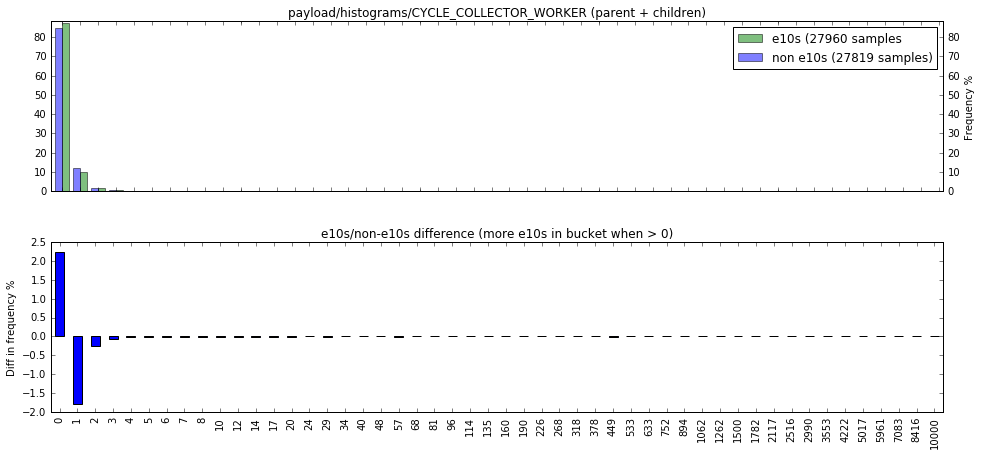

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent + children) are differing by chance is 0.00.


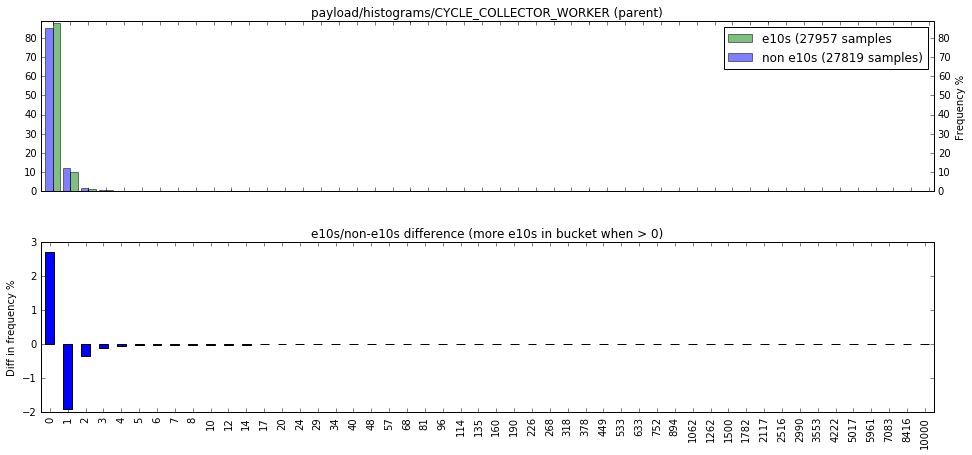

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent) are differing by chance is 0.00.


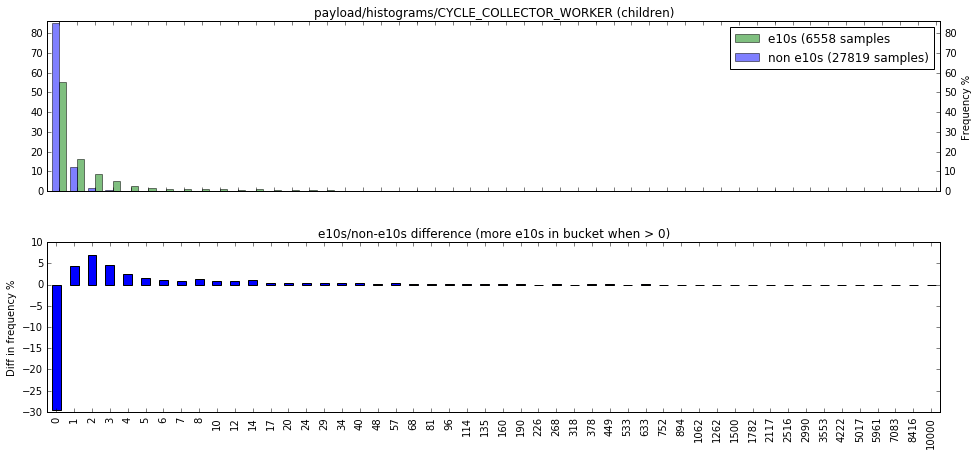

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (children) are differing by chance is 0.00.


In [45]:
compare_histograms(subset,
                   "payload/histograms/CYCLE_COLLECTOR",
                   "payload/histograms/CYCLE_COLLECTOR_WORKER",
                   "payload/histograms/CYCLE_COLLECTOR_FULL",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN")

## 3. Memory

#### a) Usage (bytes)

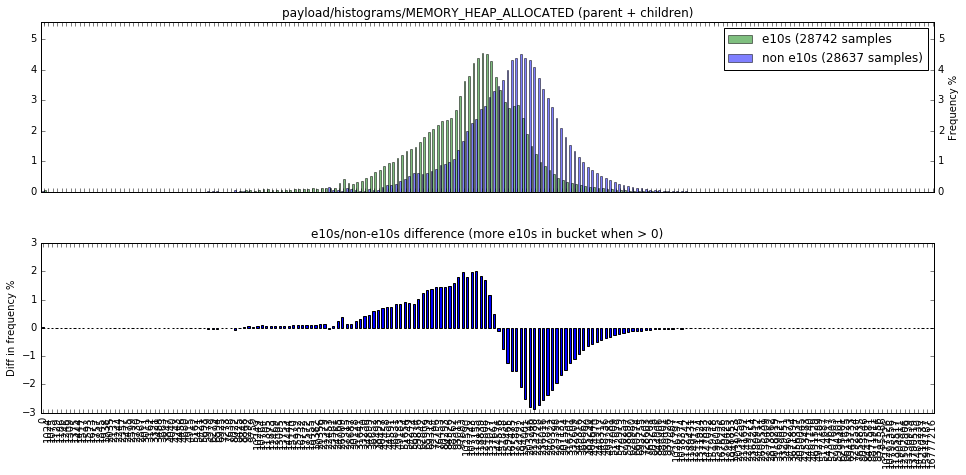

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (parent + children) are differing by chance is 0.00.


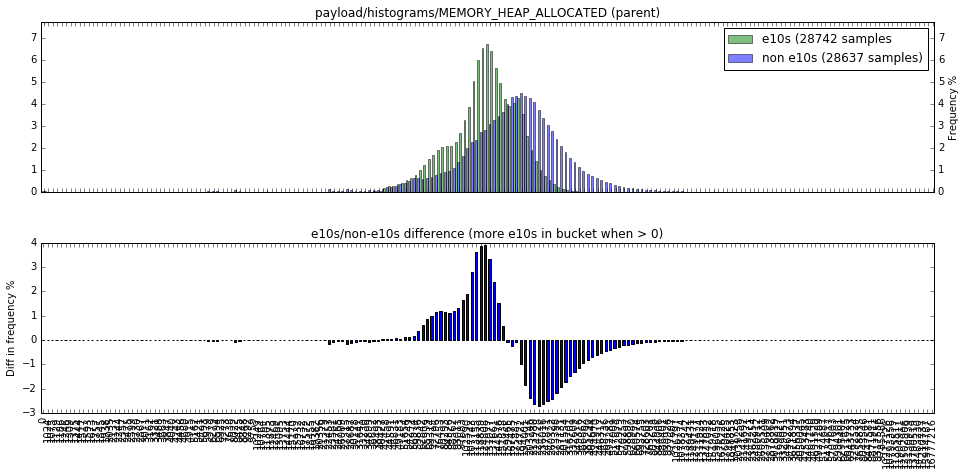

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (parent) are differing by chance is 0.00.


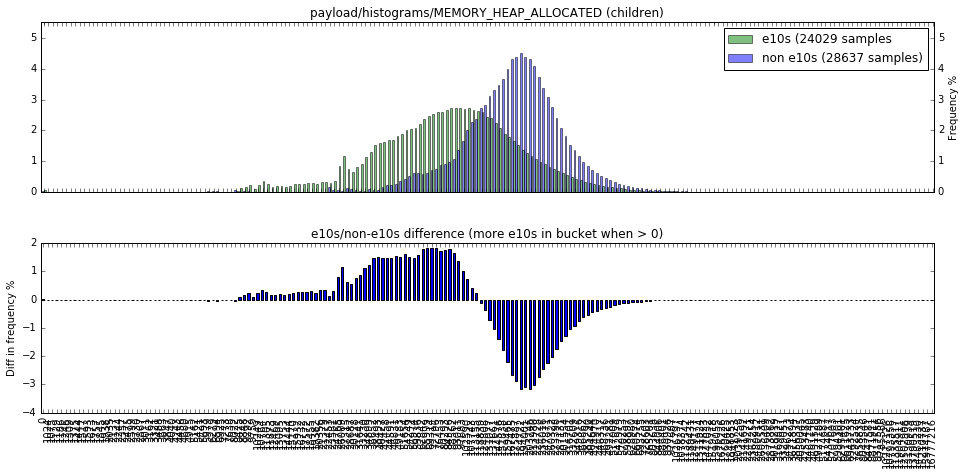

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (children) are differing by chance is 0.00.


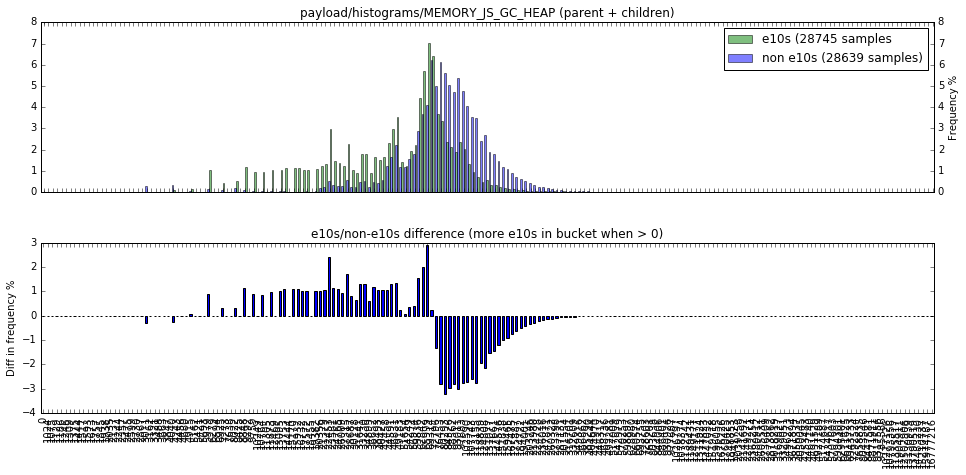

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (parent + children) are differing by chance is 0.00.


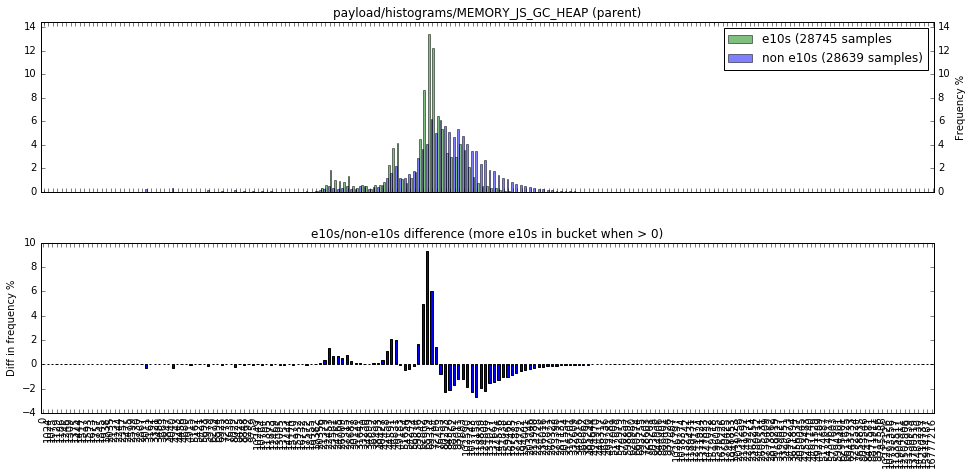

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (parent) are differing by chance is 0.00.


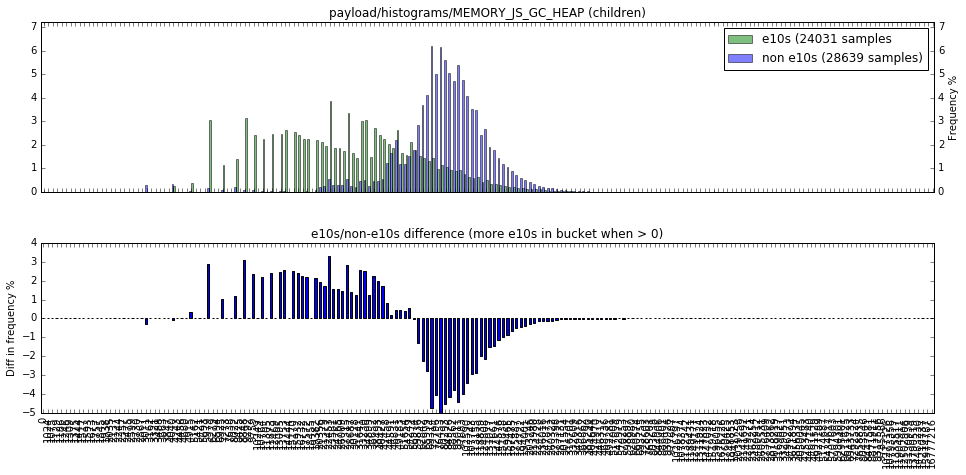

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (children) are differing by chance is 0.00.


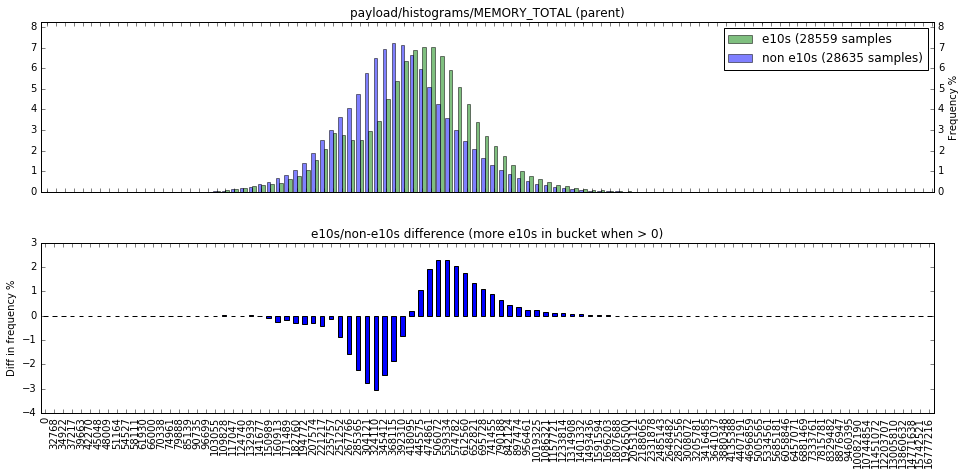

The probability that the distributions for payload/histograms/MEMORY_TOTAL (parent) are differing by chance is 0.00.


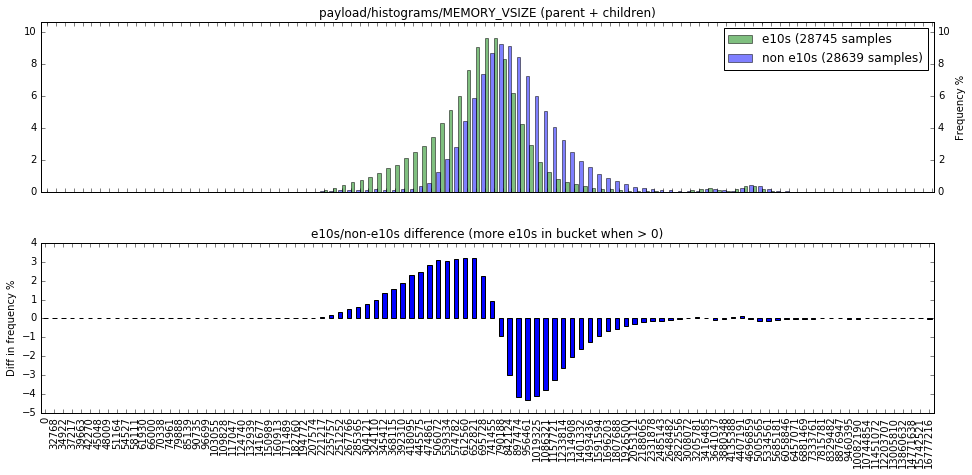

The probability that the distributions for payload/histograms/MEMORY_VSIZE (parent + children) are differing by chance is 0.00.


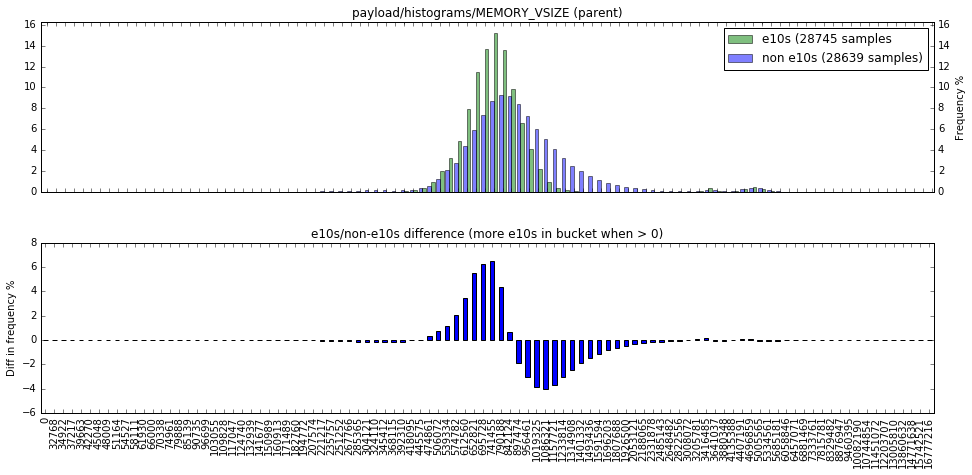

The probability that the distributions for payload/histograms/MEMORY_VSIZE (parent) are differing by chance is 0.00.


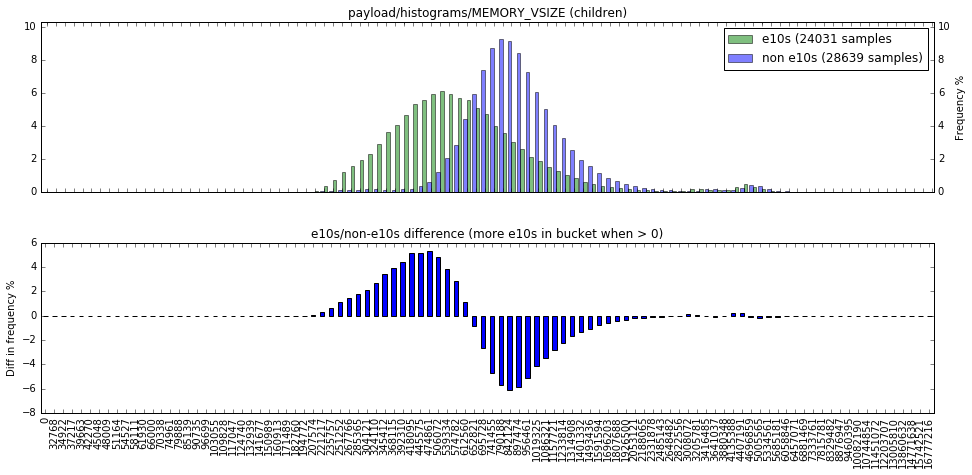

The probability that the distributions for payload/histograms/MEMORY_VSIZE (children) are differing by chance is 0.00.


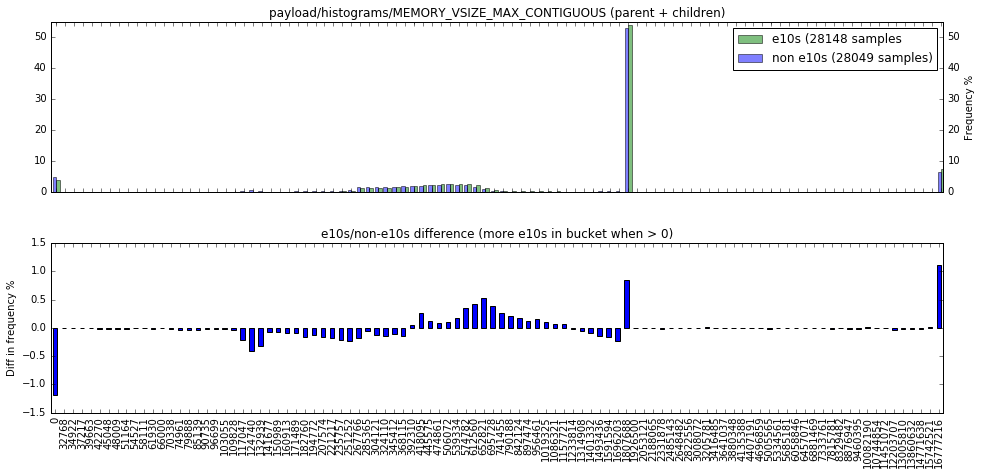

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent + children) are differing by chance is 0.00.


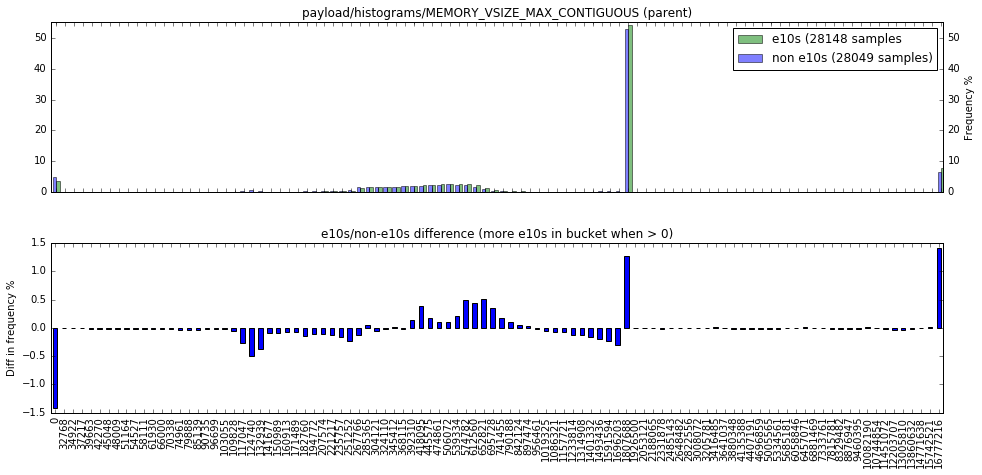

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent) are differing by chance is 0.00.


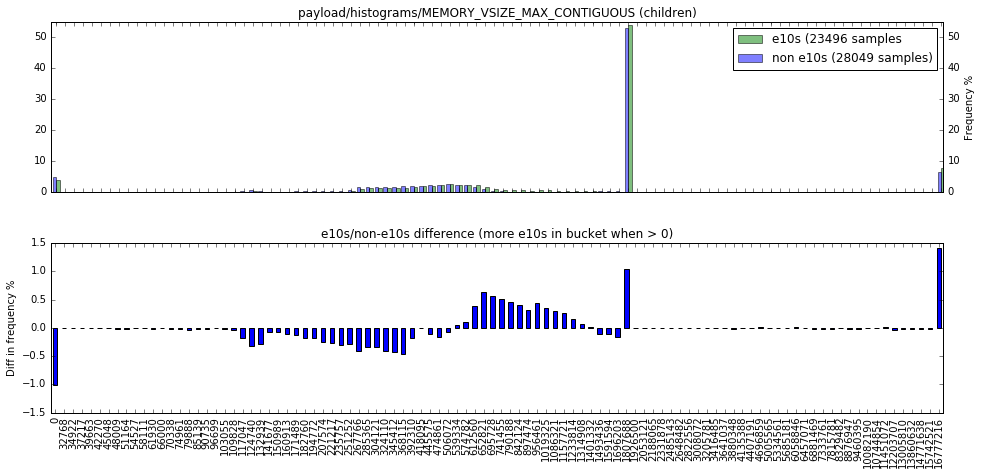

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (children) are differing by chance is 0.00.


In [46]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_TOTAL",
                   "payload/histograms/MEMORY_VSIZE",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS",
                   "payload/histograms/MEMORY_HEAP_ALLOCATED",
                   "payload/histograms/MEMORY_JS_GC_HEAP")

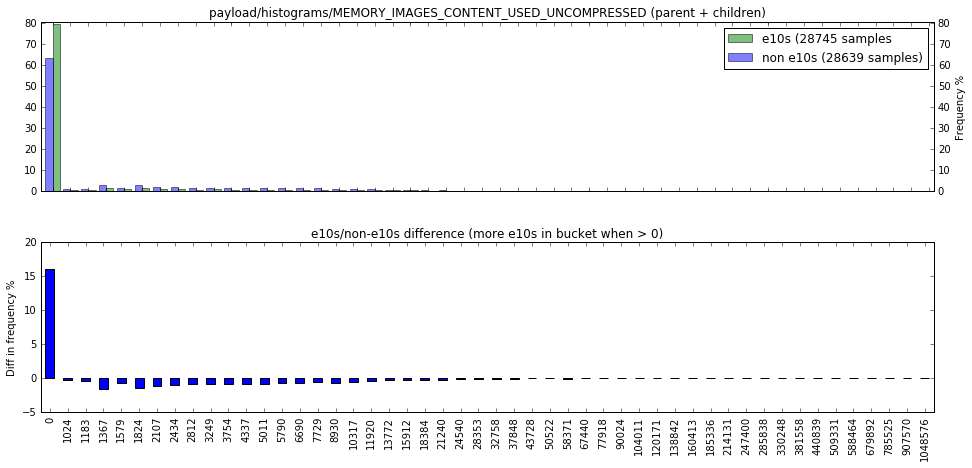

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (parent + children) are differing by chance is 0.00.


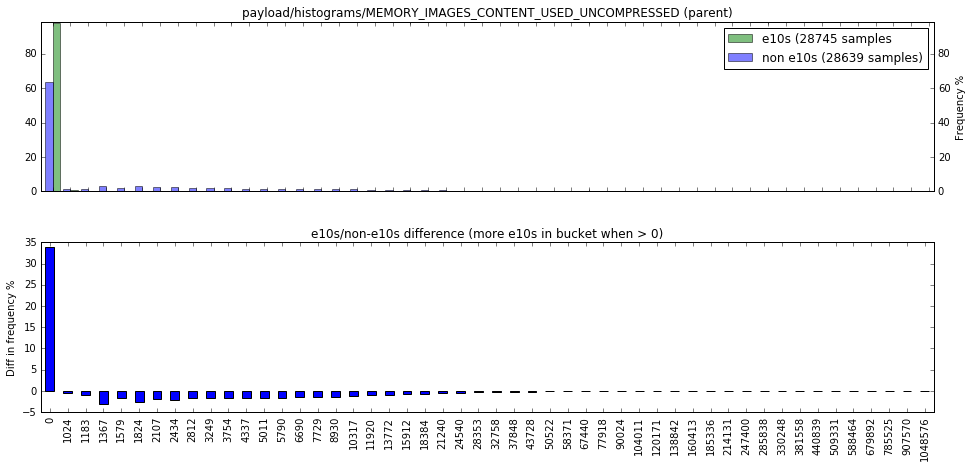

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (parent) are differing by chance is 0.00.


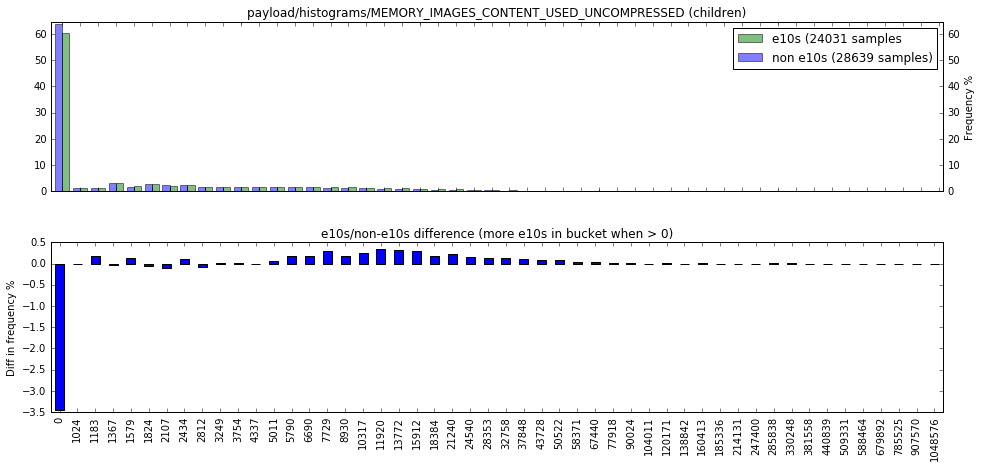

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (children) are differing by chance is 0.00.


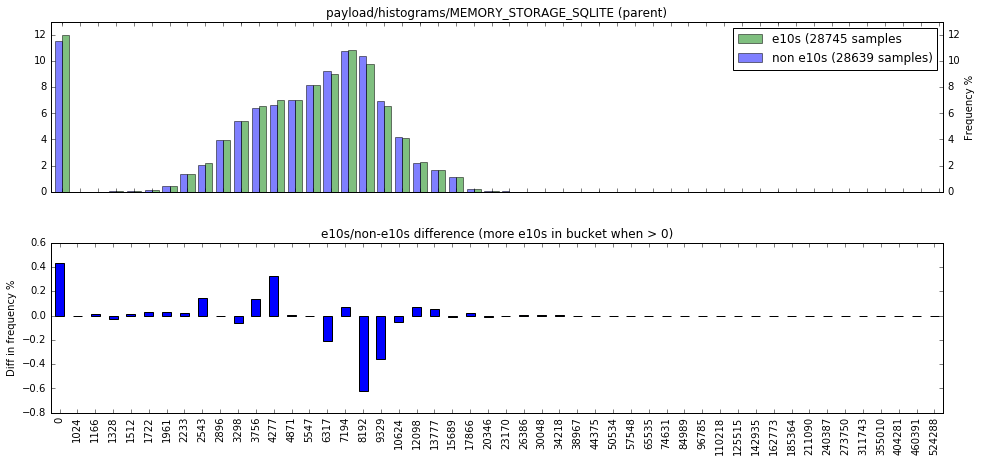

The probability that the distributions for payload/histograms/MEMORY_STORAGE_SQLITE (parent) are differing by chance is 0.04.


In [47]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED",
                   "payload/histograms/MEMORY_STORAGE_SQLITE")

#### c) JS compartments

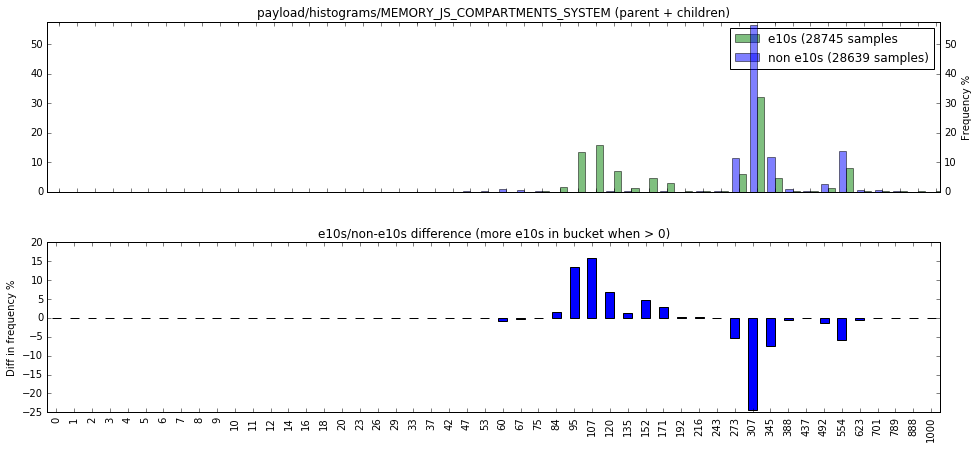

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (parent + children) are differing by chance is 0.00.


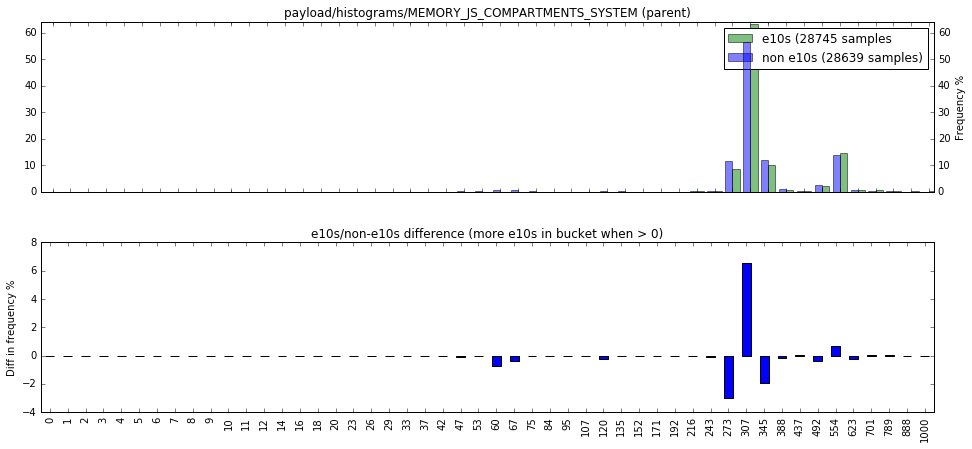

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (parent) are differing by chance is 0.00.


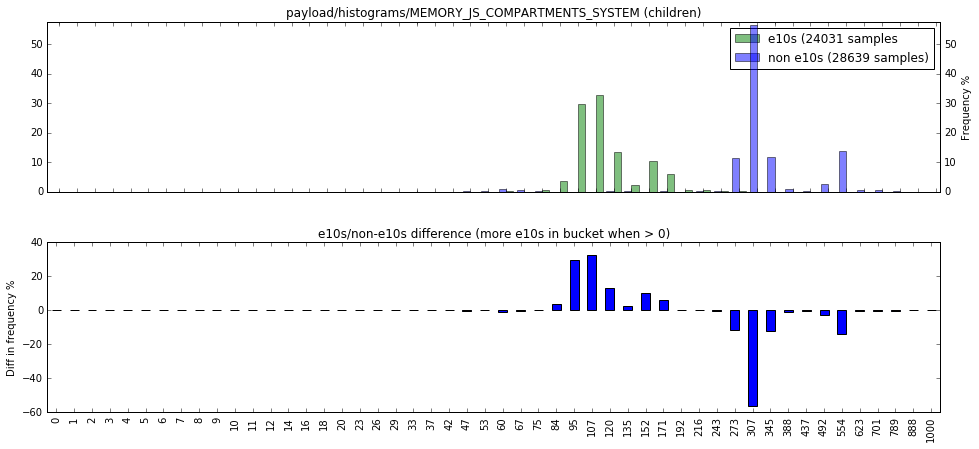

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (children) are differing by chance is 0.00.


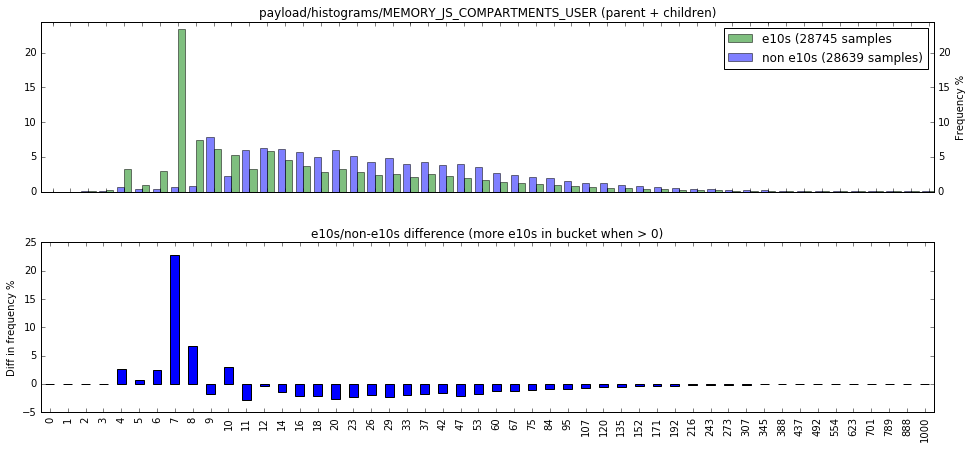

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (parent + children) are differing by chance is 0.00.


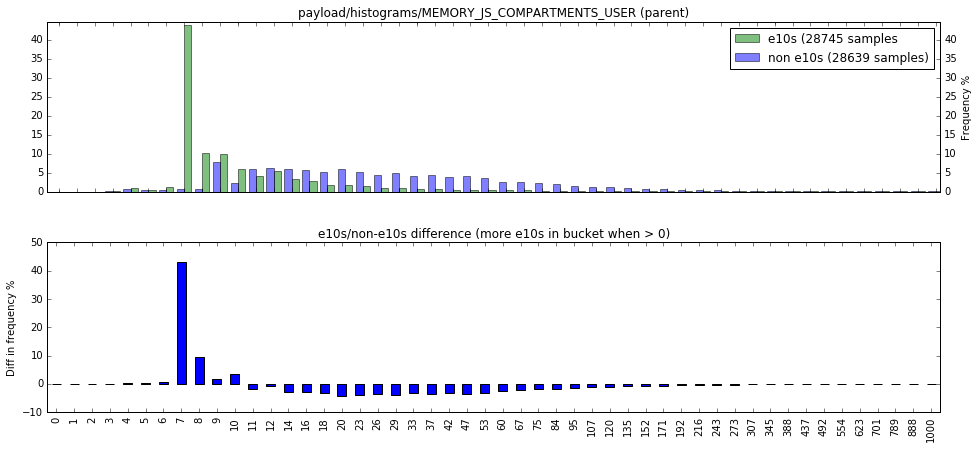

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (parent) are differing by chance is 0.00.


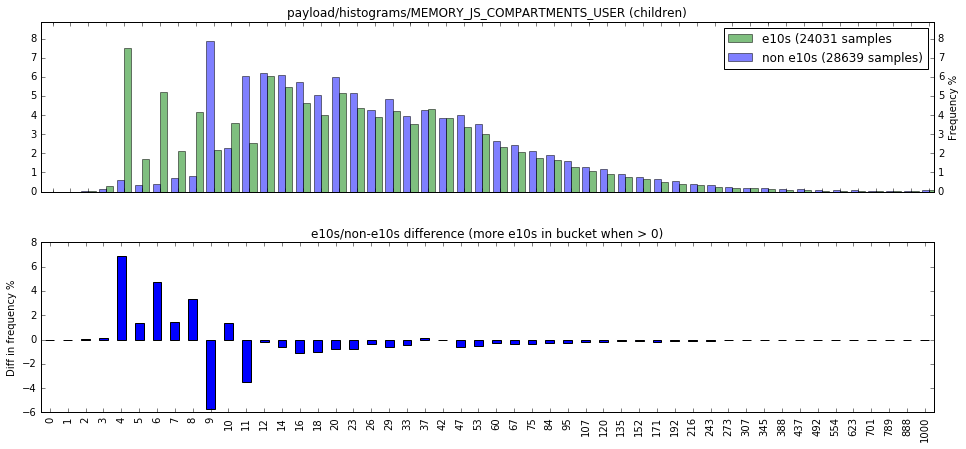

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (children) are differing by chance is 0.00.


In [48]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM",
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_USER")

#### d) Low memory events

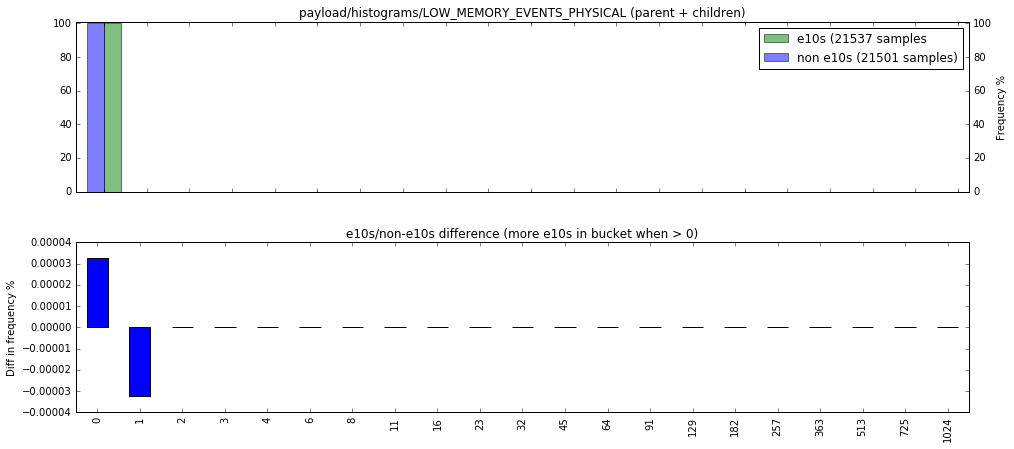

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (parent + children) are differing by chance is 0.46.


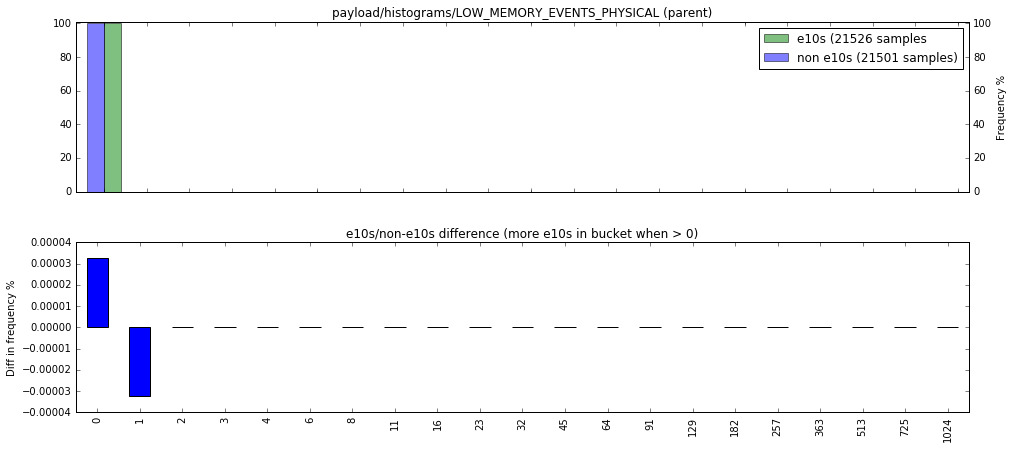

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (parent) are differing by chance is 0.43.


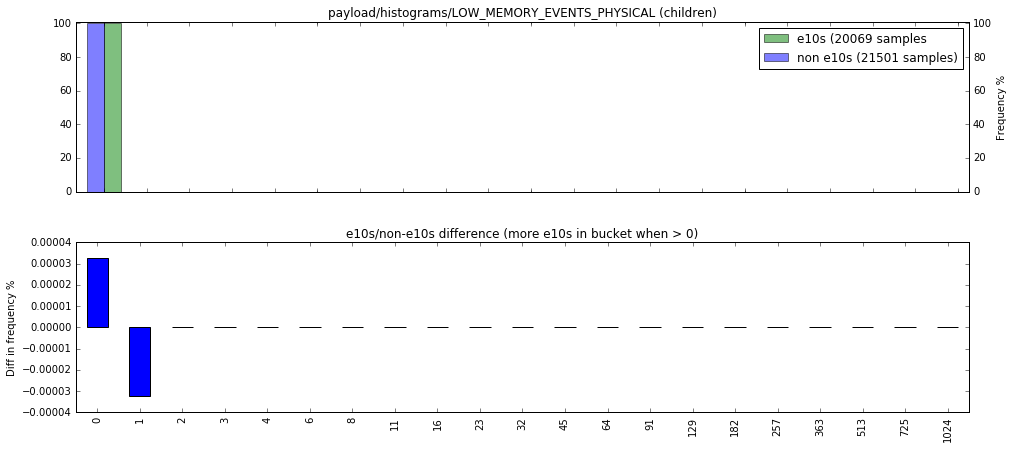

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (children) are differing by chance is 1.00.


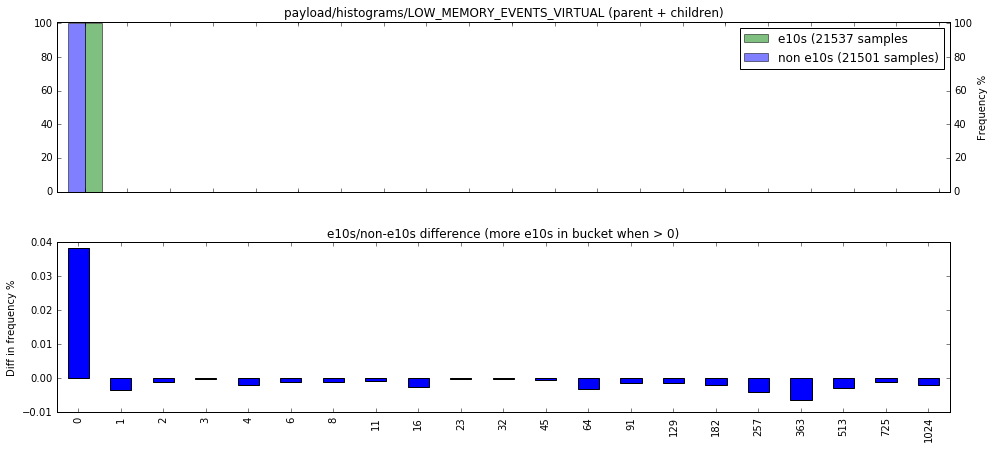

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (parent + children) are differing by chance is 0.00.


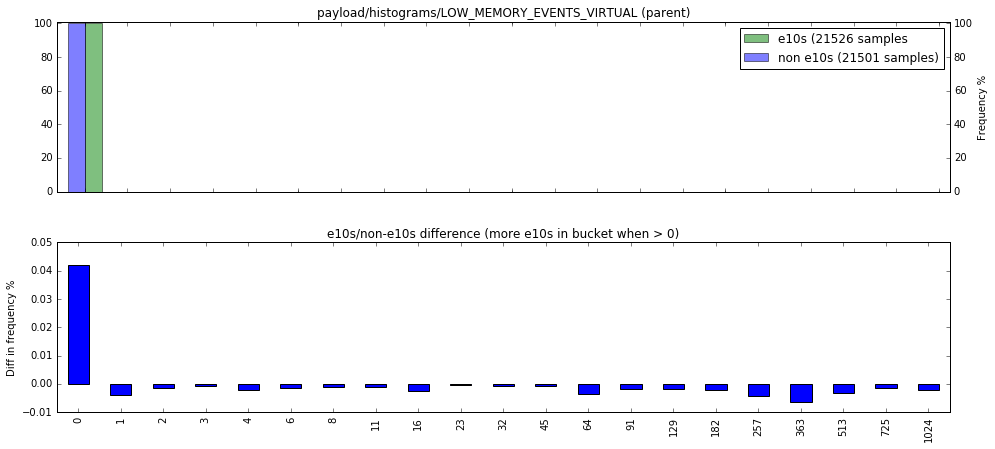

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (parent) are differing by chance is 0.00.


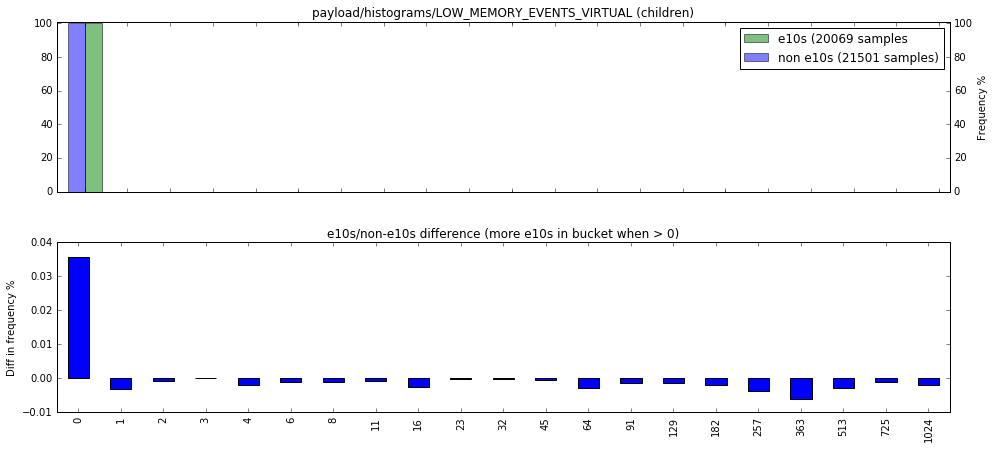

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (children) are differing by chance is 0.00.


In [49]:
compare_histograms(subset,
                   "payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL",
                   "payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL")

#### e) Page faults

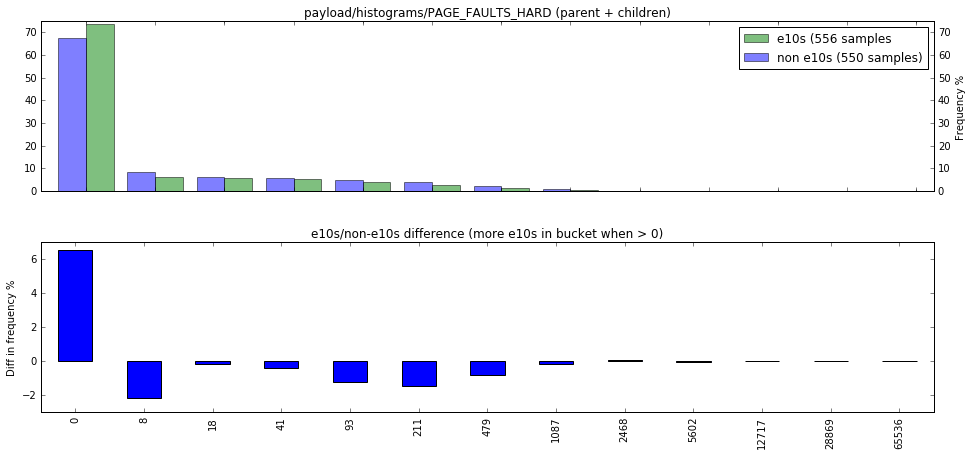

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (parent + children) are differing by chance is 0.00.


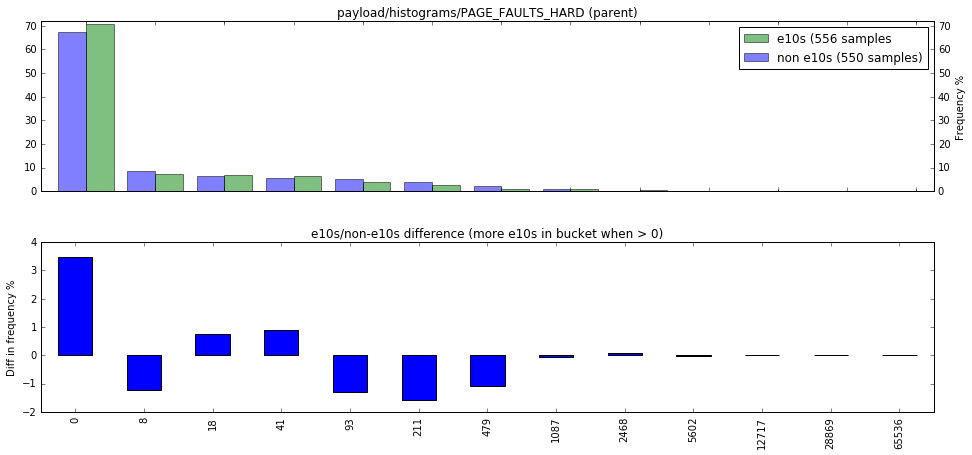

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (parent) are differing by chance is 0.00.


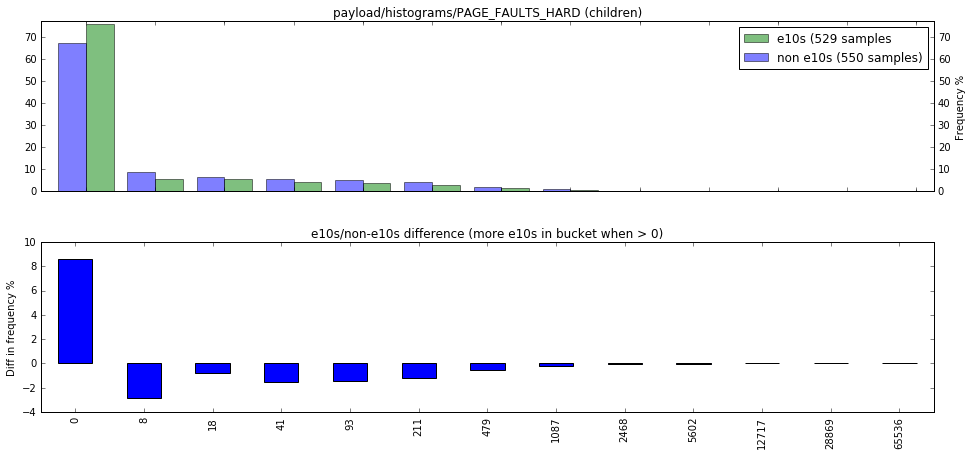

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (children) are differing by chance is 0.00.


In [50]:
compare_histograms(subset,
                   "payload/histograms/PAGE_FAULTS_HARD")

#### f) Ghost windows

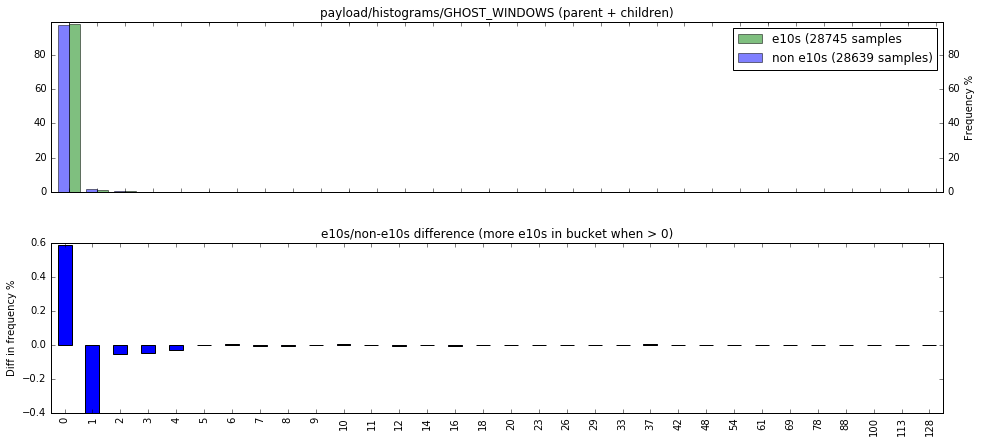

The probability that the distributions for payload/histograms/GHOST_WINDOWS (parent + children) are differing by chance is 0.00.


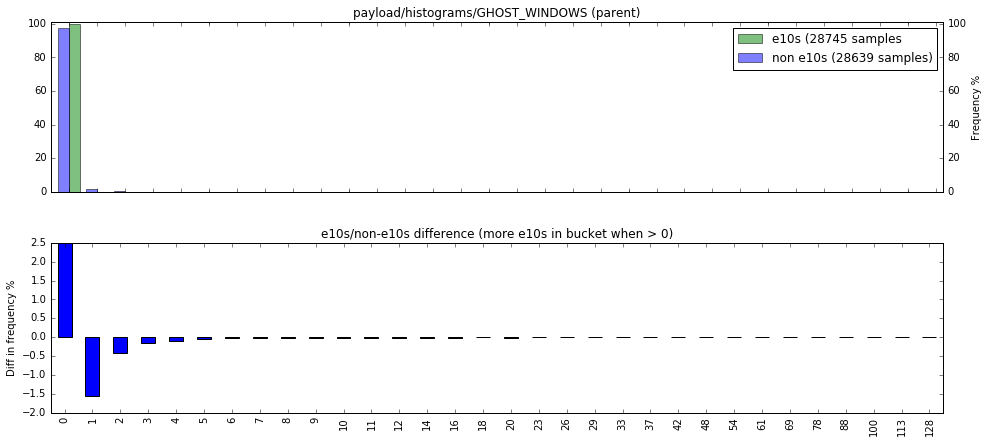

The probability that the distributions for payload/histograms/GHOST_WINDOWS (parent) are differing by chance is 0.00.


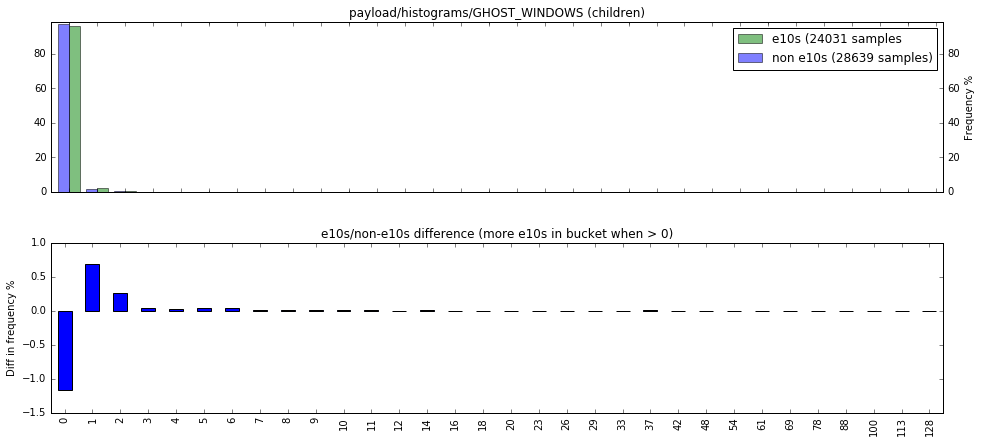

The probability that the distributions for payload/histograms/GHOST_WINDOWS (children) are differing by chance is 0.00.


In [51]:
compare_histograms(subset,
                   "payload/histograms/GHOST_WINDOWS")

## 3. Other

Differences discovered by comparing all histograms (see Bug [1198638](https://bugzilla.mozilla.org/show_bug.cgi?id=1198638))

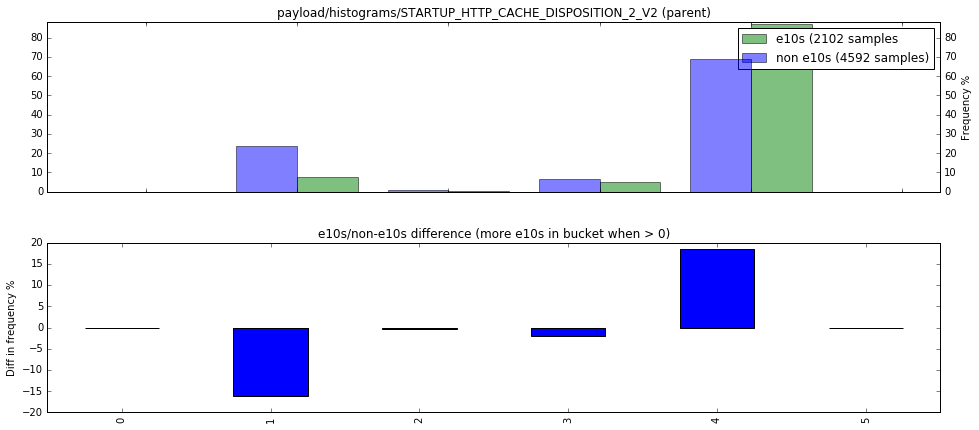

The probability that the distributions for payload/histograms/STARTUP_HTTP_CACHE_DISPOSITION_2_V2 (parent) are differing by chance is 0.00.


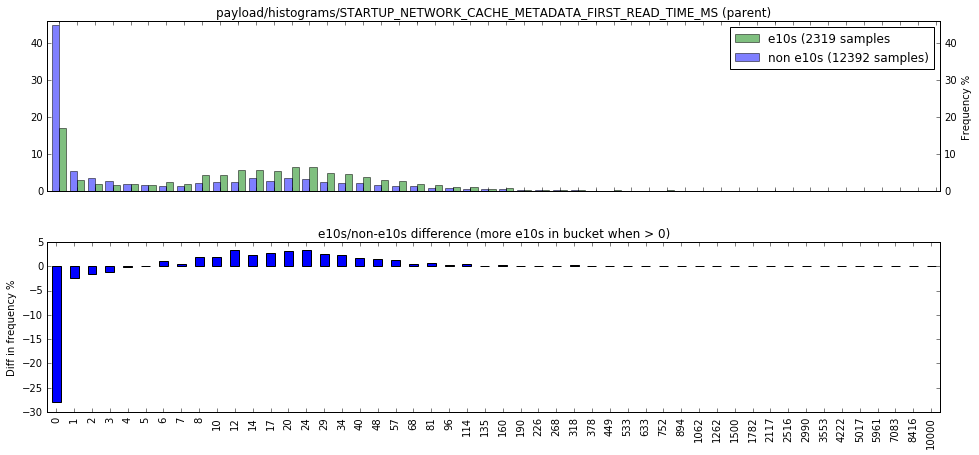

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS (parent) are differing by chance is 0.00.


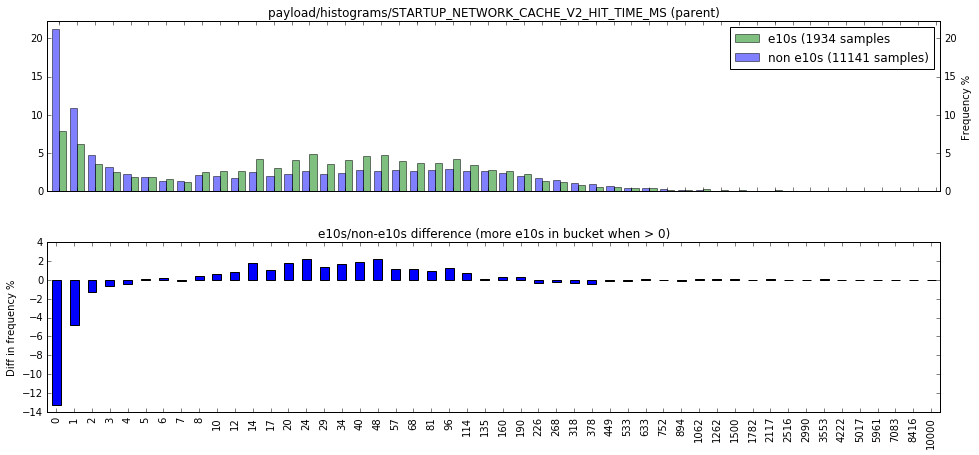

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS (parent) are differing by chance is 0.00.


In [52]:
compare_histograms(subset,
                   "payload/histograms/STARTUP_HTTP_CACHE_DISPOSITION_2_V2",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS",
                   "payload/histograms/STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS")

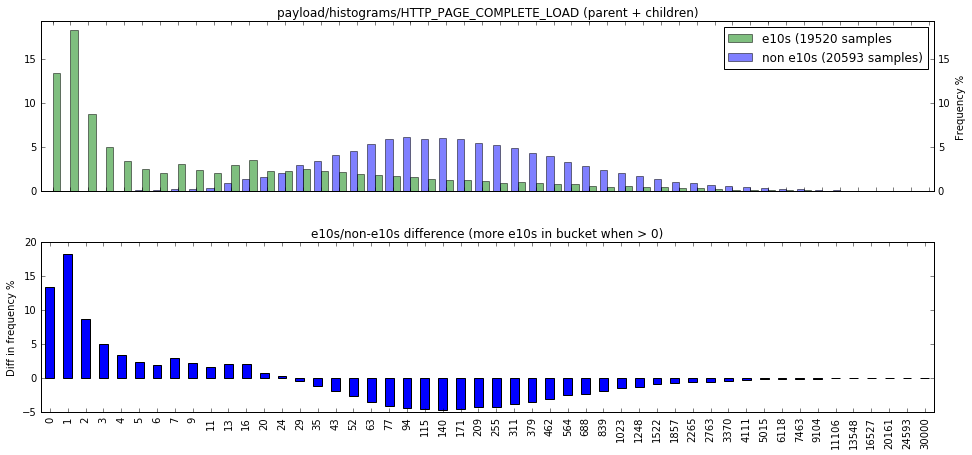

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (parent + children) are differing by chance is 0.00.


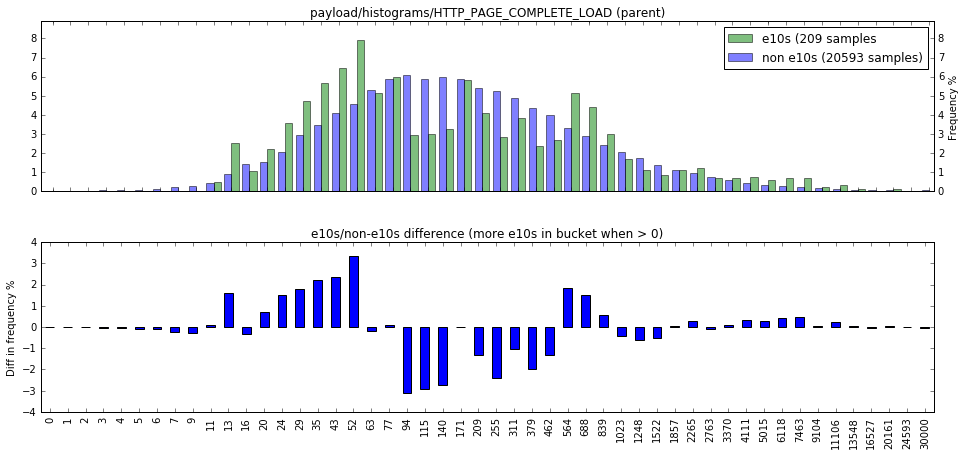

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (parent) are differing by chance is 0.00.


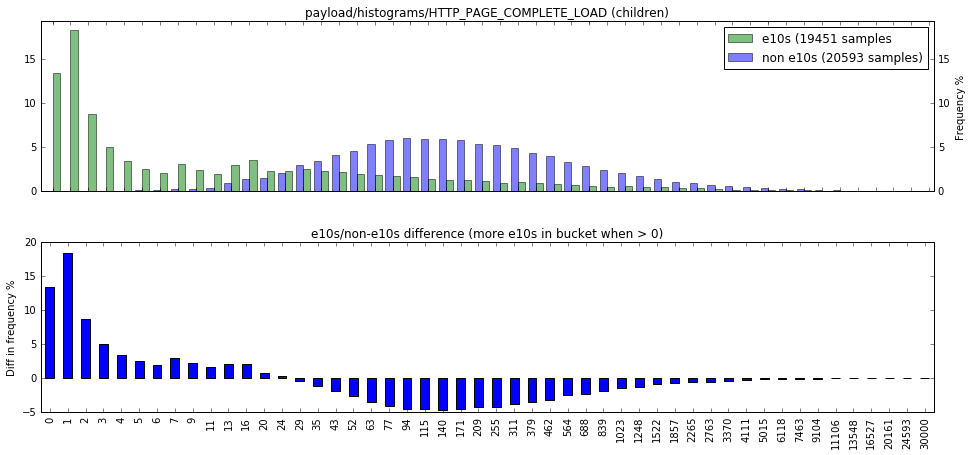

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (children) are differing by chance is 0.00.


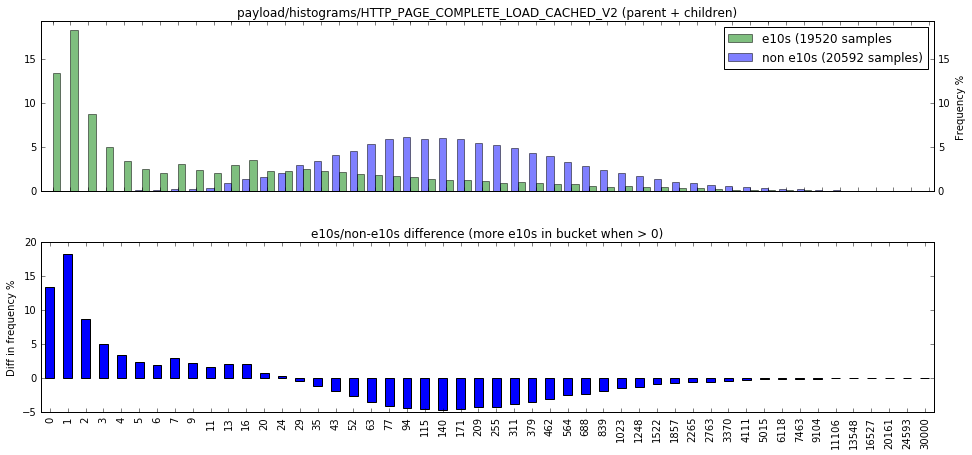

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (parent + children) are differing by chance is 0.00.


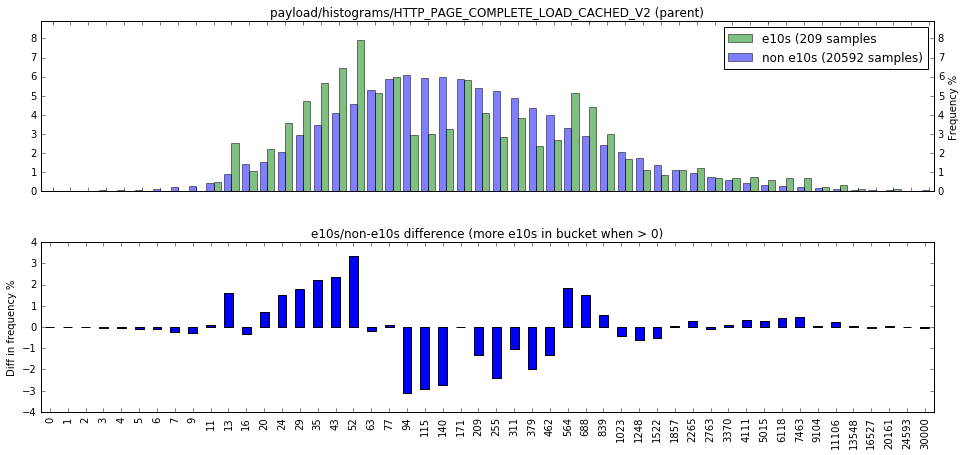

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (parent) are differing by chance is 0.00.


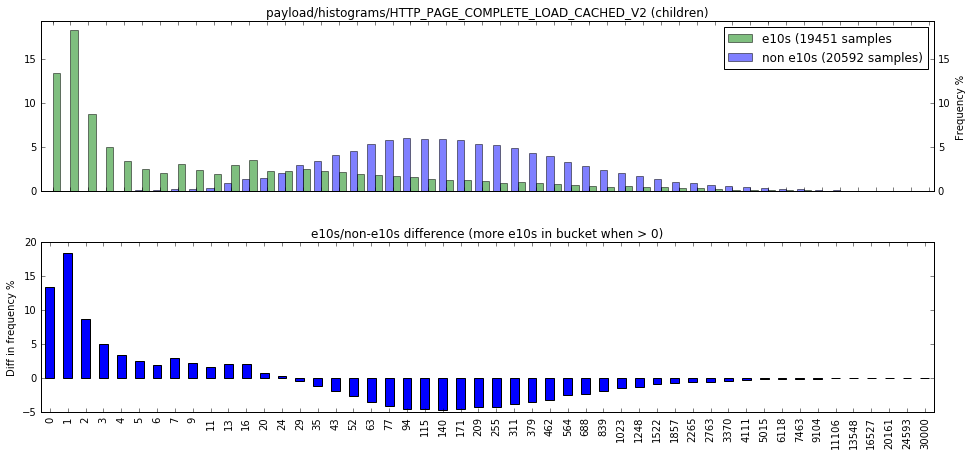

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (children) are differing by chance is 0.00.


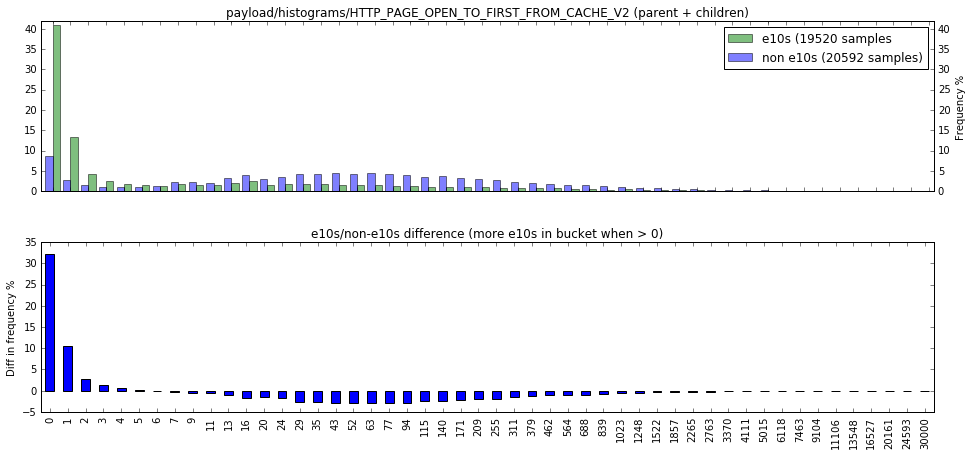

The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (parent + children) are differing by chance is 0.00.


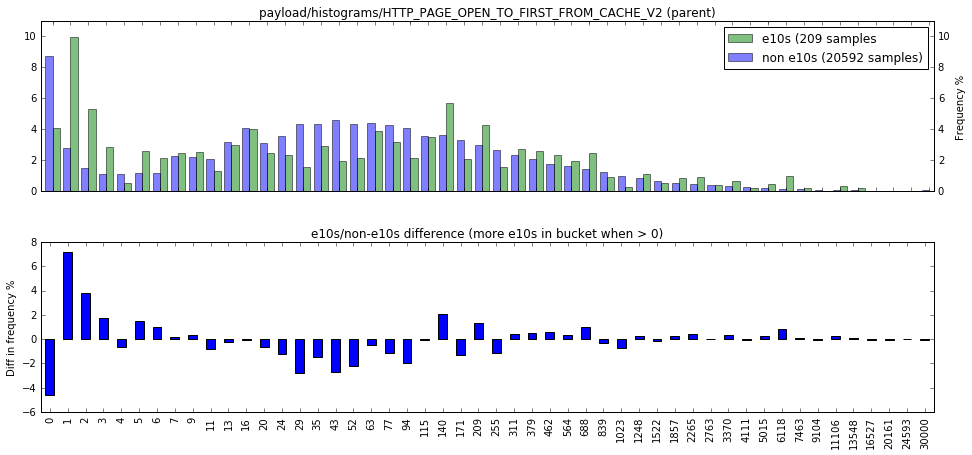

The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (parent) are differing by chance is 0.00.


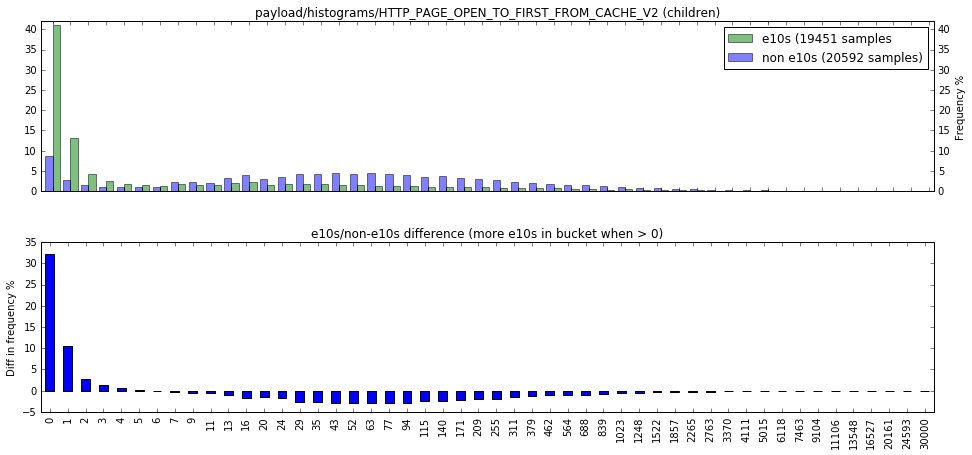

The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (children) are differing by chance is 0.00.


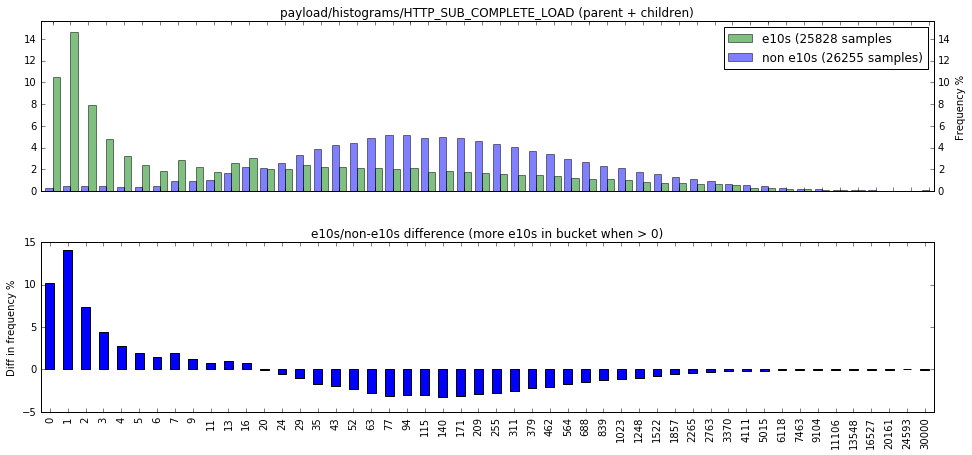

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (parent + children) are differing by chance is 0.00.


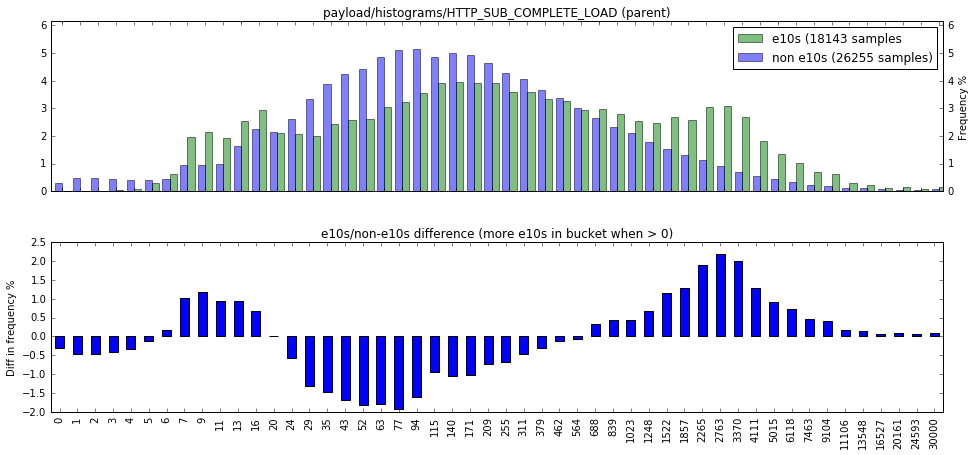

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (parent) are differing by chance is 0.00.


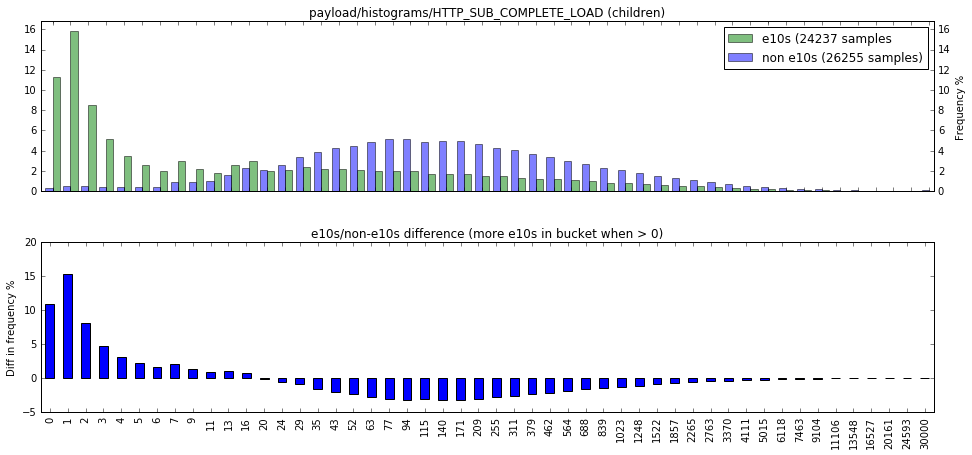

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (children) are differing by chance is 0.00.


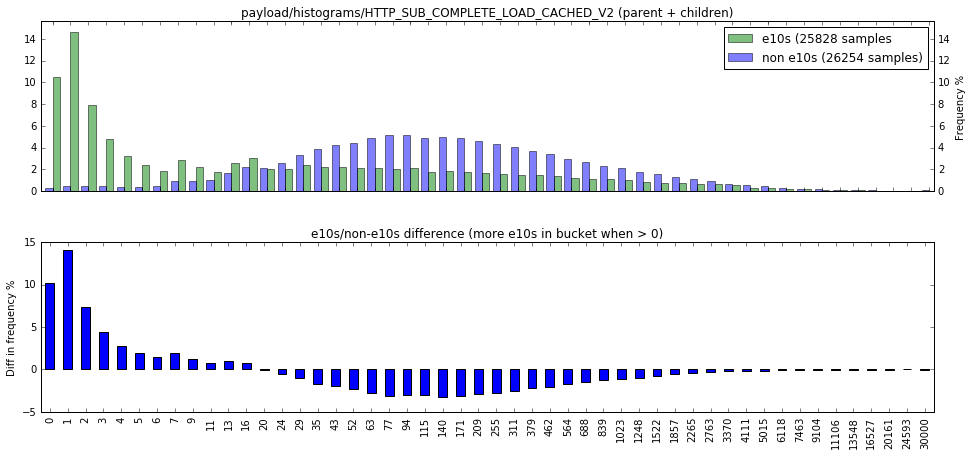

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (parent + children) are differing by chance is 0.00.


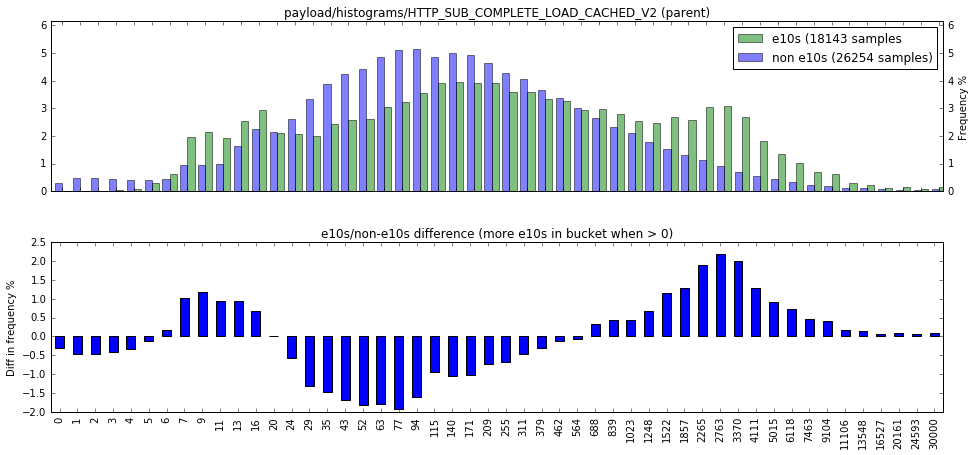

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (parent) are differing by chance is 0.00.


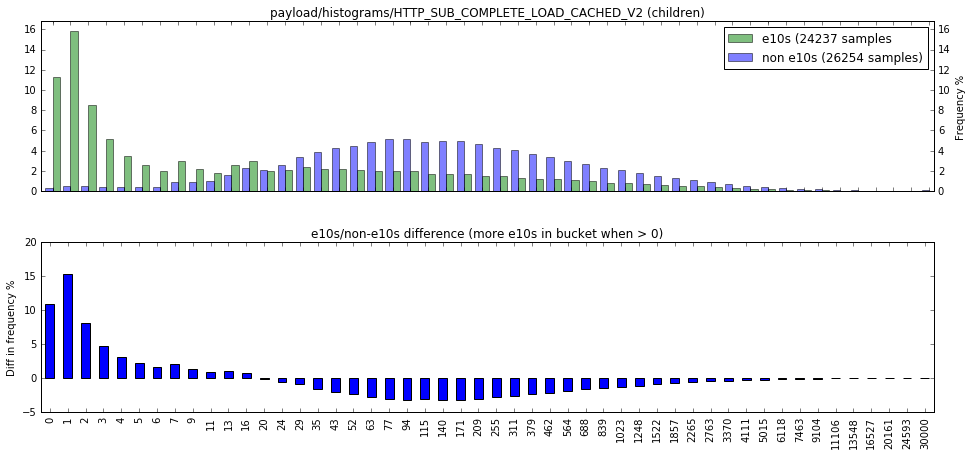

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (children) are differing by chance is 0.00.


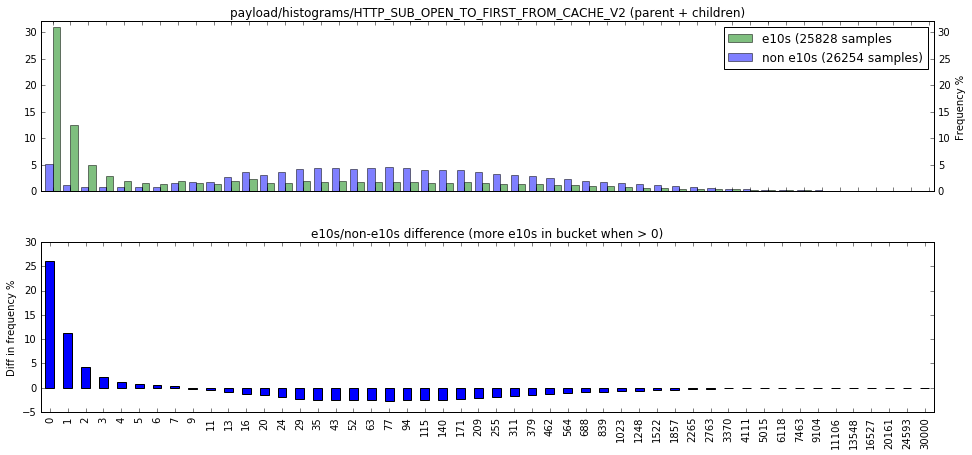

The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (parent + children) are differing by chance is 0.00.


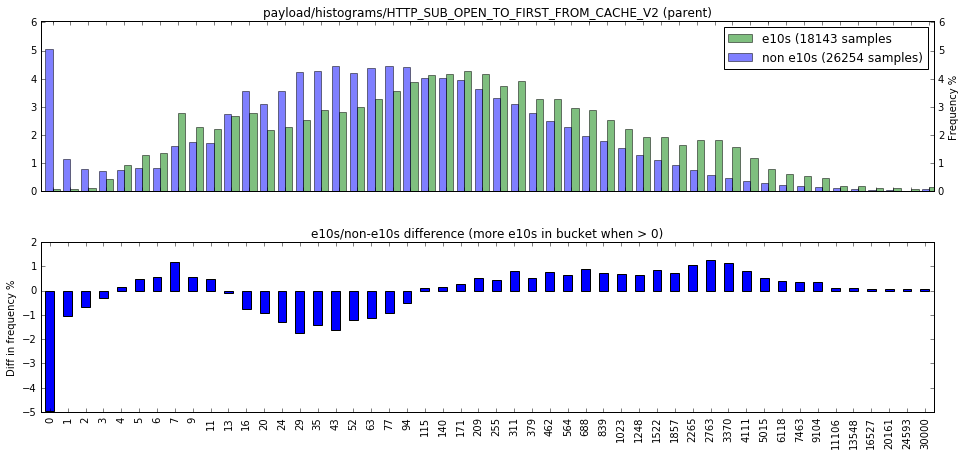

The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (parent) are differing by chance is 0.00.


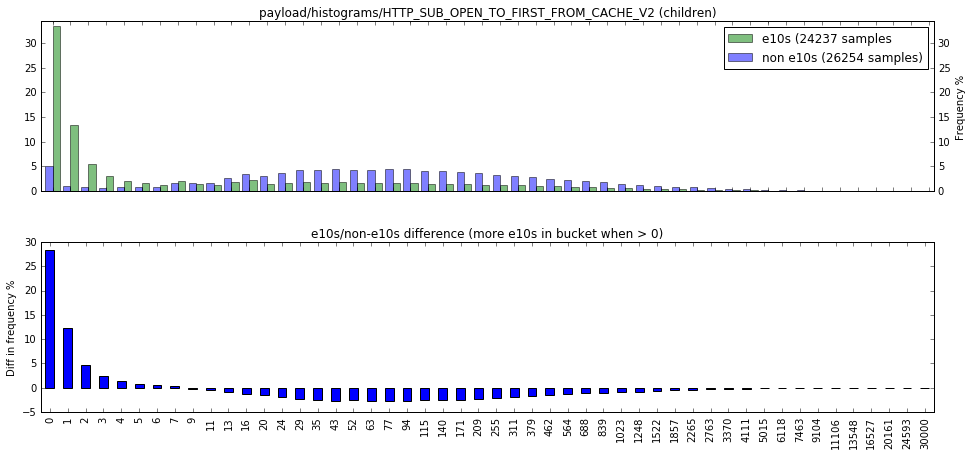

The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (children) are differing by chance is 0.00.


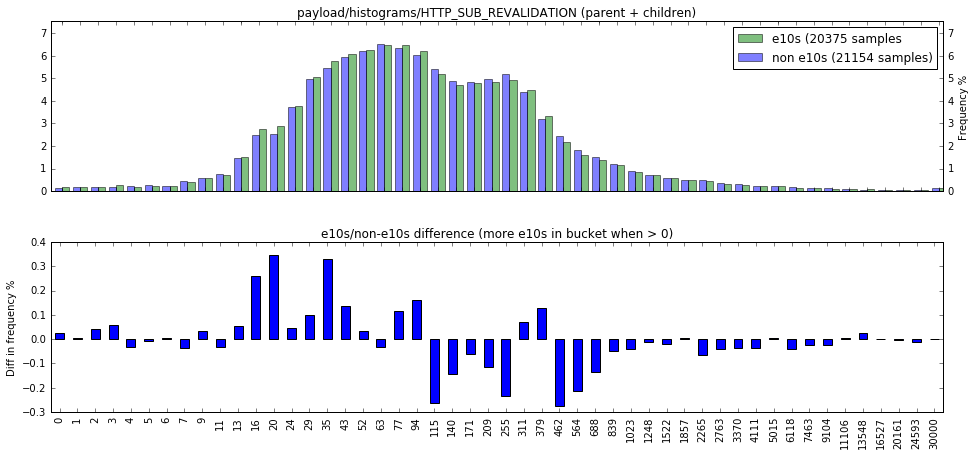

The probability that the distributions for payload/histograms/HTTP_SUB_REVALIDATION (parent + children) are differing by chance is 0.00.


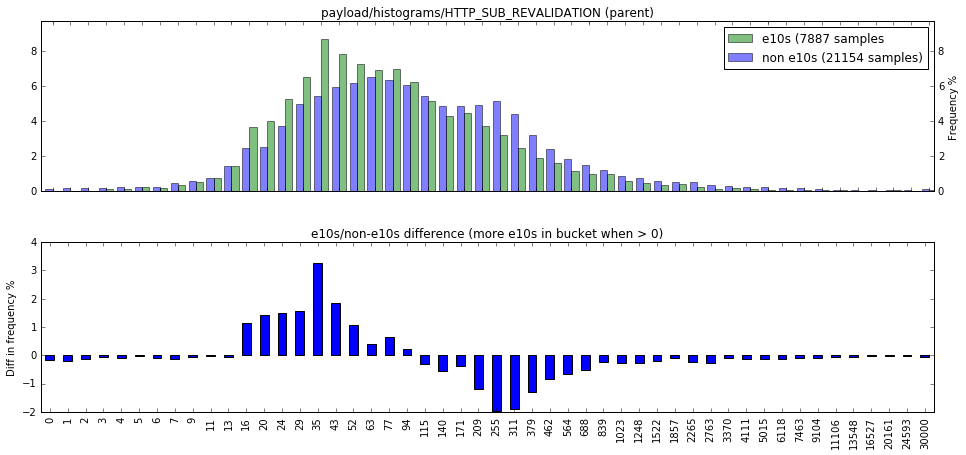

The probability that the distributions for payload/histograms/HTTP_SUB_REVALIDATION (parent) are differing by chance is 0.00.


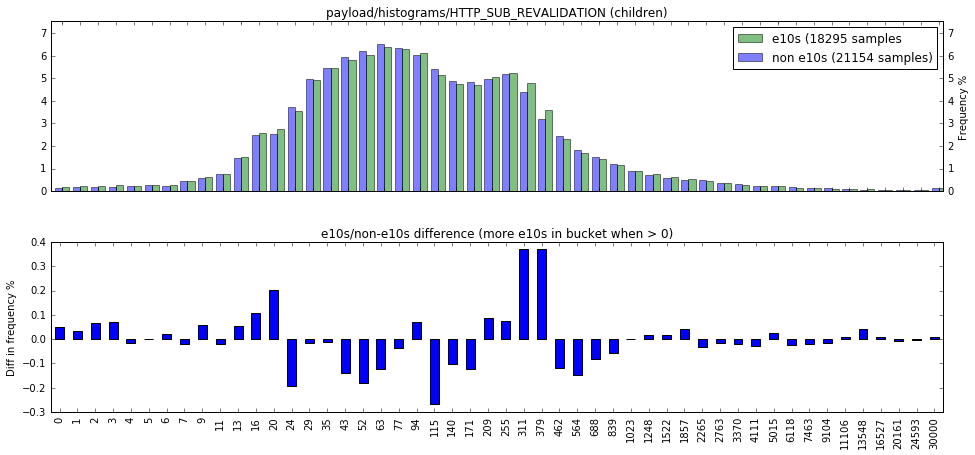

The probability that the distributions for payload/histograms/HTTP_SUB_REVALIDATION (children) are differing by chance is 0.00.


In [53]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD",                   
                   "payload/histograms/HTTP_SUB_REVALIDATION",
                   "payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2")

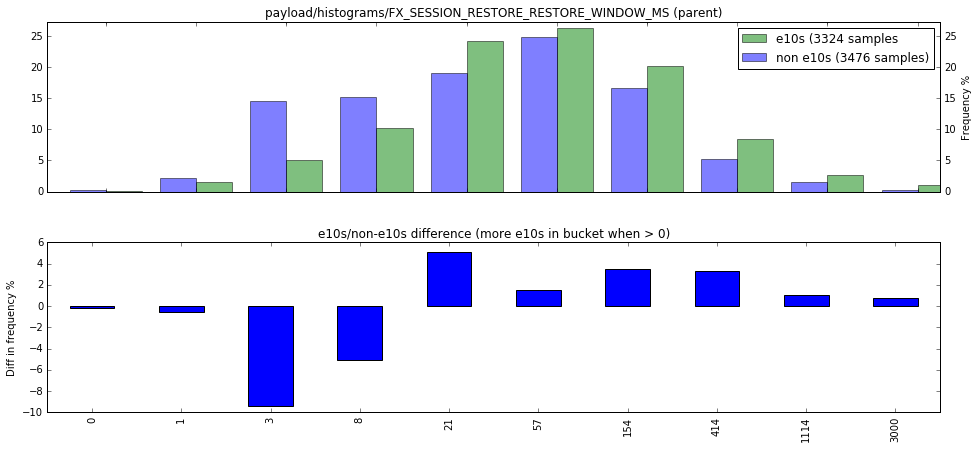

The probability that the distributions for payload/histograms/FX_SESSION_RESTORE_RESTORE_WINDOW_MS (parent) are differing by chance is 0.00.


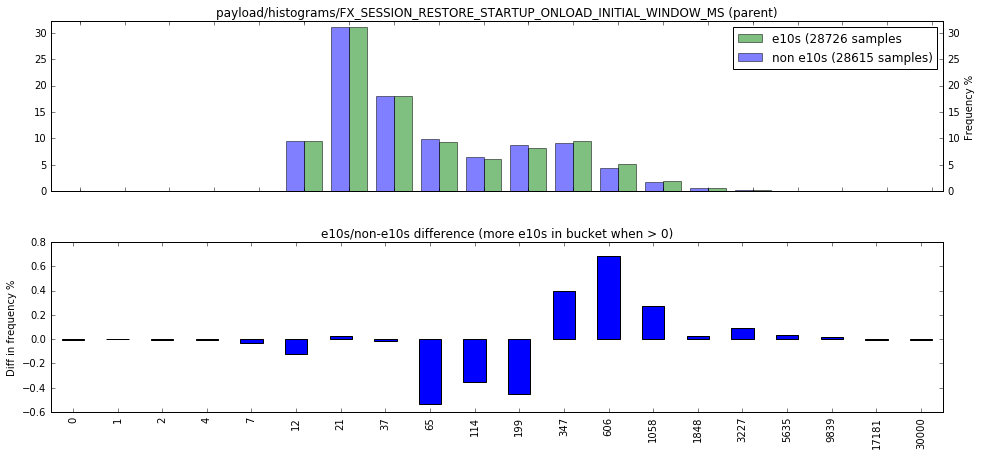

The probability that the distributions for payload/histograms/FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS (parent) are differing by chance is 0.00.


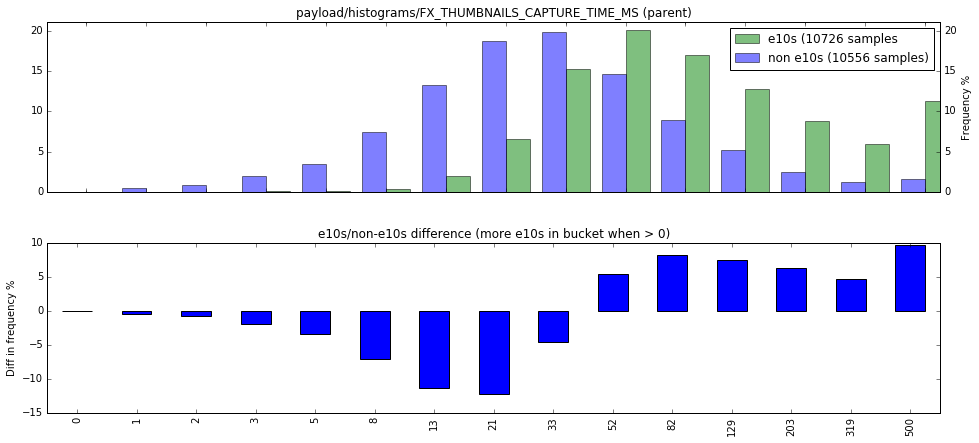

The probability that the distributions for payload/histograms/FX_THUMBNAILS_CAPTURE_TIME_MS (parent) are differing by chance is 0.00.


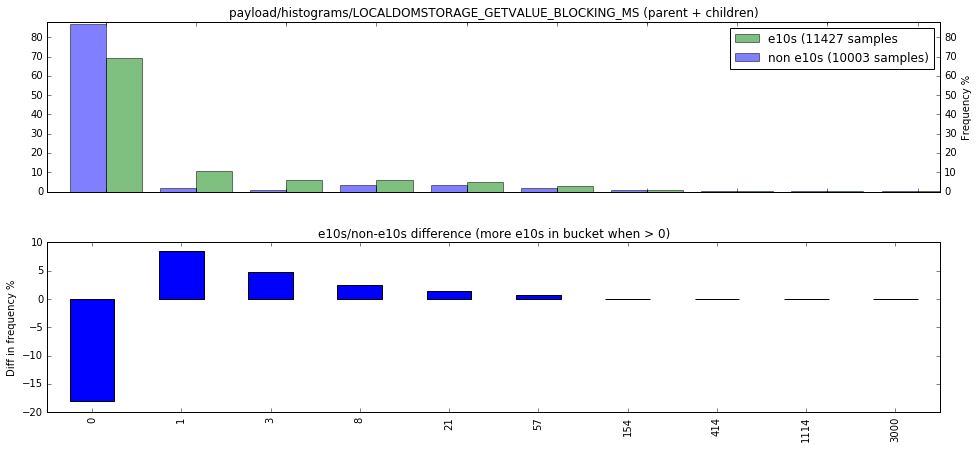

The probability that the distributions for payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS (parent + children) are differing by chance is 0.00.


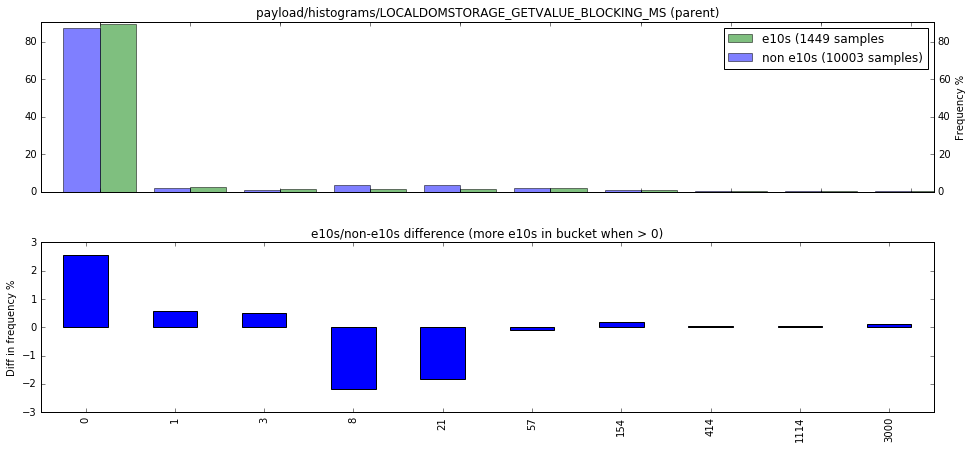

The probability that the distributions for payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS (parent) are differing by chance is 0.00.


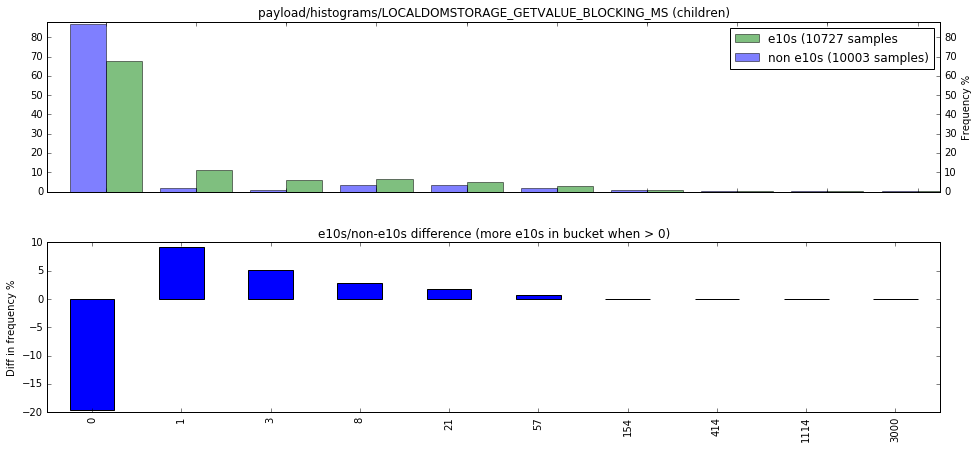

The probability that the distributions for payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS (children) are differing by chance is 0.00.


In [54]:
compare_histograms(subset, 
                   "payload/histograms/FX_THUMBNAILS_CAPTURE_TIME_MS",                   
                   "payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS",
                   "payload/histograms/FX_SESSION_RESTORE_RESTORE_WINDOW_MS",
                   "payload/histograms/FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS")

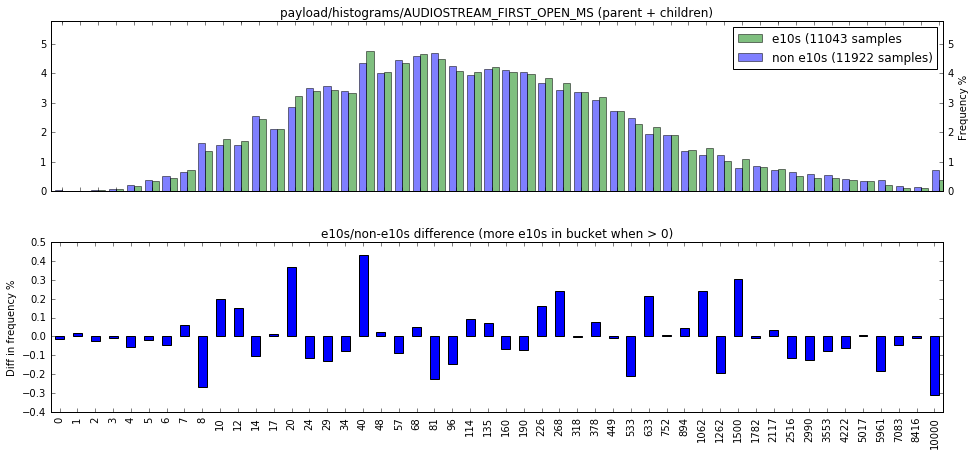

The probability that the distributions for payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS (parent + children) are differing by chance is 0.27.


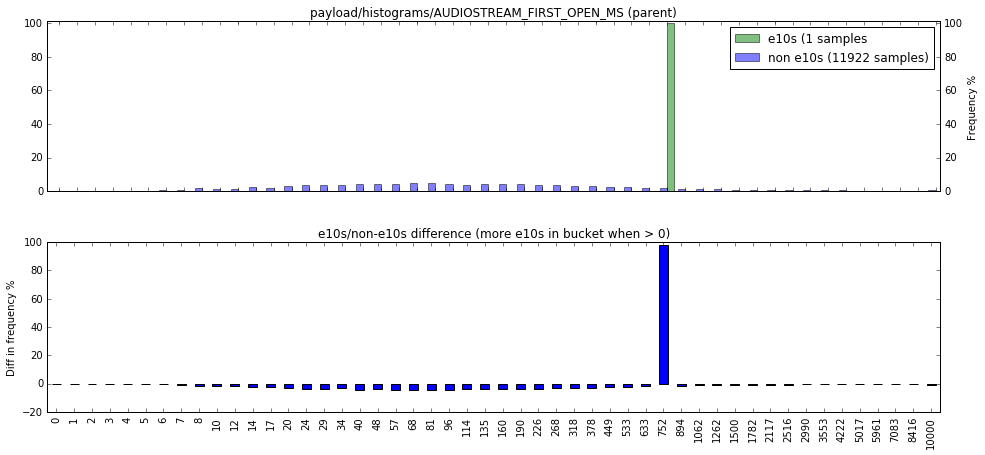

The probability that the distributions for payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS (parent) are differing by chance is 0.11.


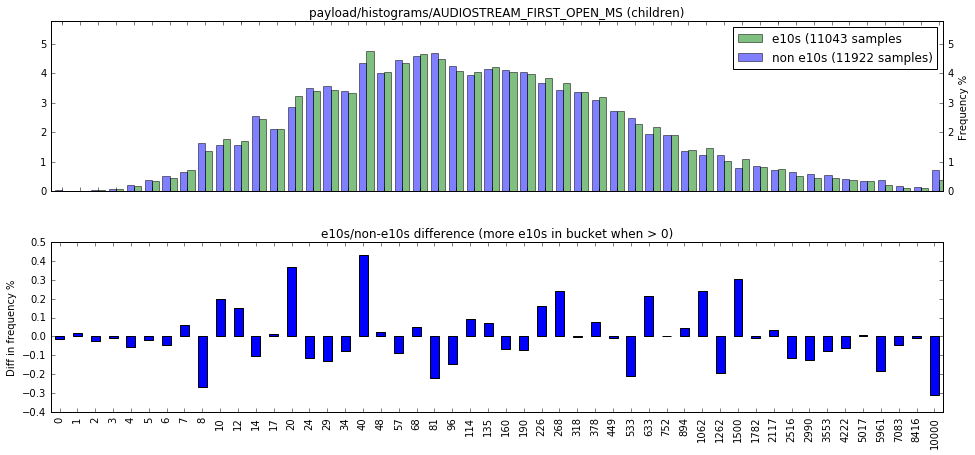

The probability that the distributions for payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS (children) are differing by chance is 0.27.


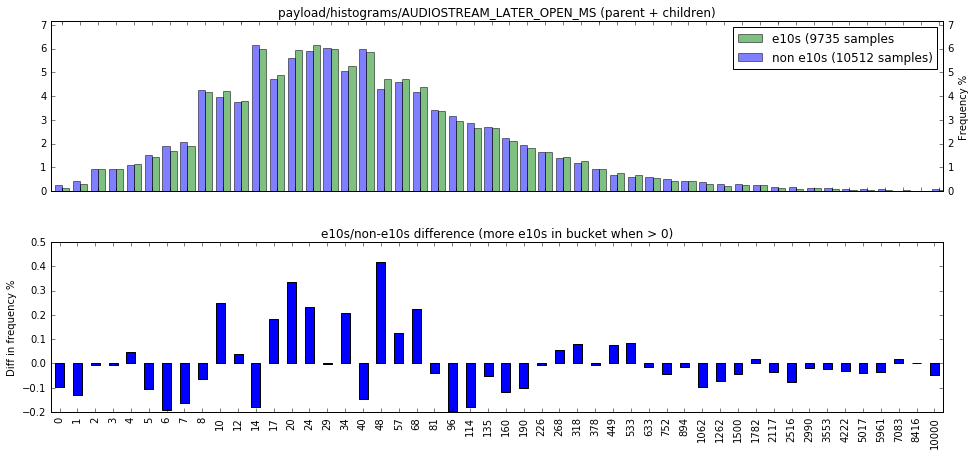

The probability that the distributions for payload/histograms/AUDIOSTREAM_LATER_OPEN_MS (parent + children) are differing by chance is 0.00.


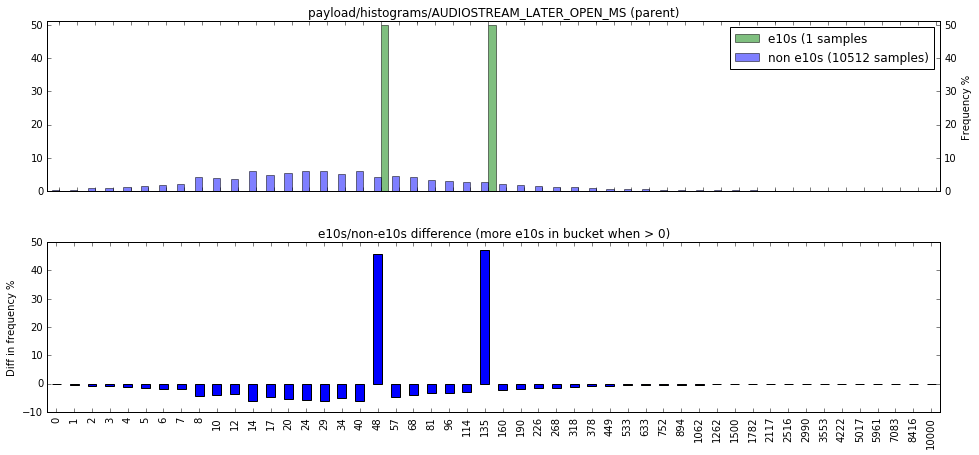

The probability that the distributions for payload/histograms/AUDIOSTREAM_LATER_OPEN_MS (parent) are differing by chance is 0.16.


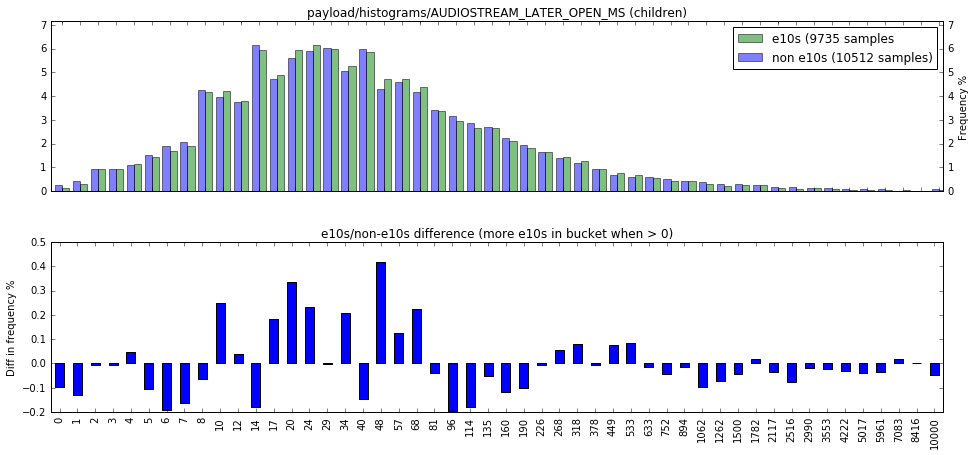

The probability that the distributions for payload/histograms/AUDIOSTREAM_LATER_OPEN_MS (children) are differing by chance is 0.00.


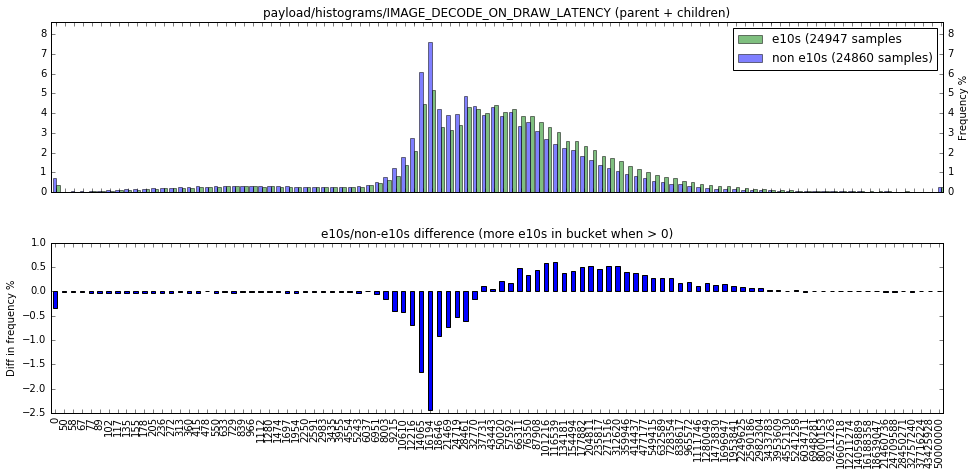

The probability that the distributions for payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY (parent + children) are differing by chance is 0.00.


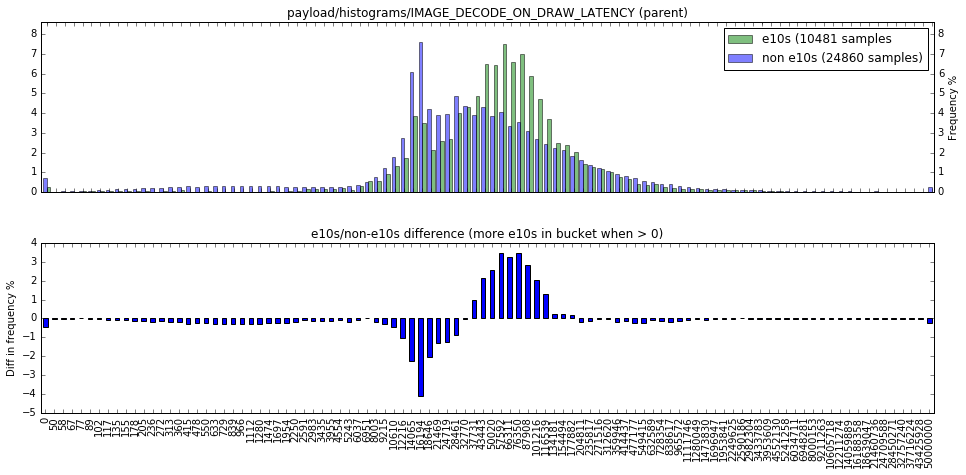

The probability that the distributions for payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY (parent) are differing by chance is 0.00.


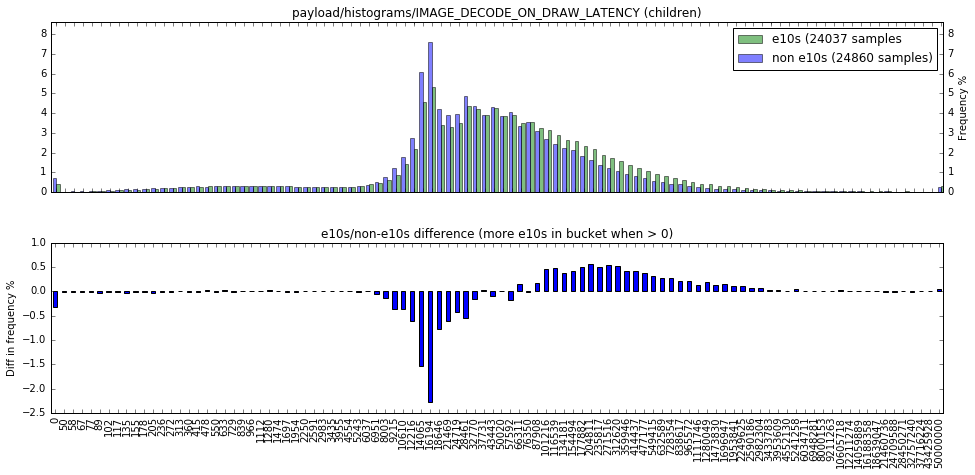

The probability that the distributions for payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY (children) are differing by chance is 0.00.


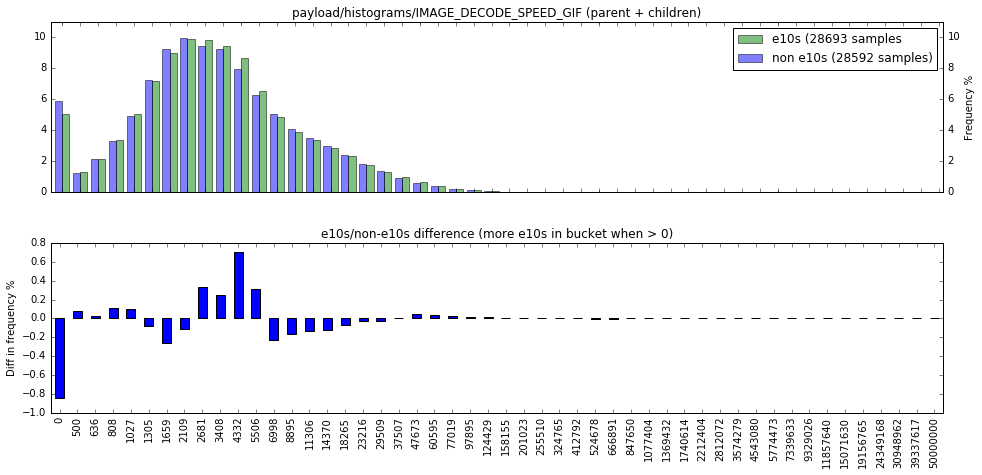

The probability that the distributions for payload/histograms/IMAGE_DECODE_SPEED_GIF (parent + children) are differing by chance is 0.00.


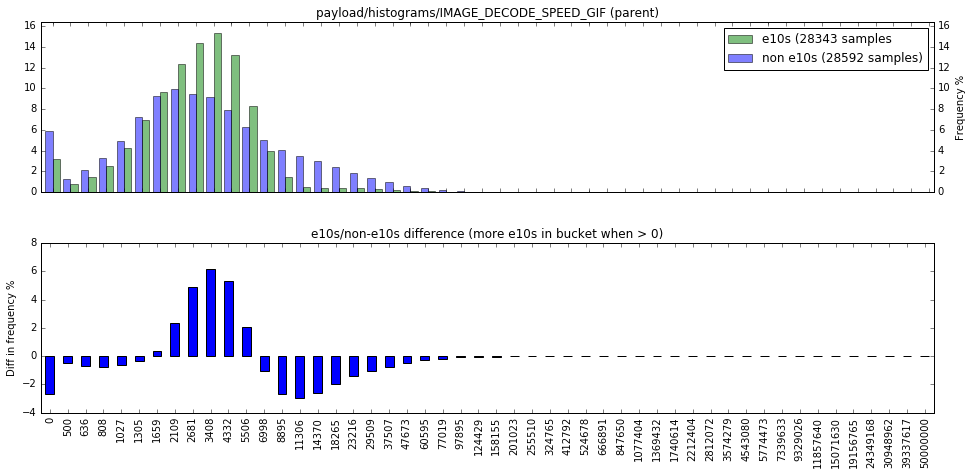

The probability that the distributions for payload/histograms/IMAGE_DECODE_SPEED_GIF (parent) are differing by chance is 0.00.


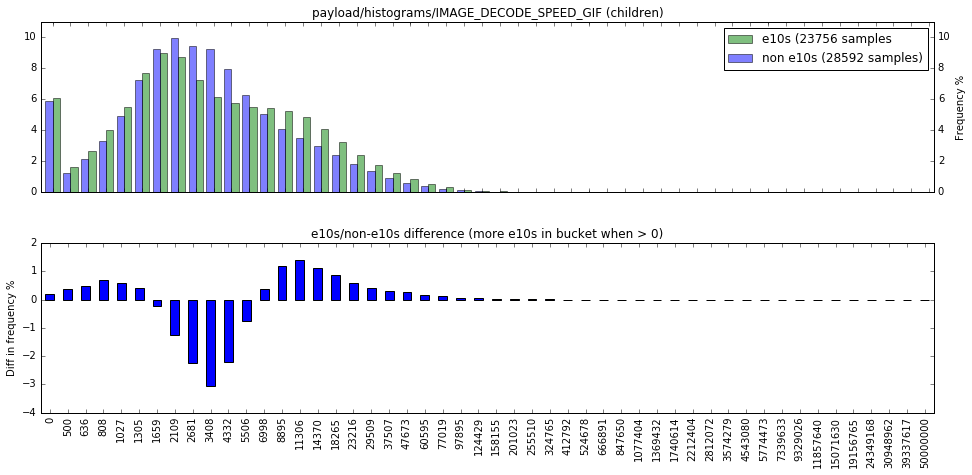

The probability that the distributions for payload/histograms/IMAGE_DECODE_SPEED_GIF (children) are differing by chance is 0.00.


In [55]:
compare_histograms(subset, 
                   "payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY",
                   "payload/histograms/IMAGE_DECODE_SPEED_GIF",
                   "payload/histograms/AUDIOSTREAM_LATER_OPEN_MS",
                   "payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS")

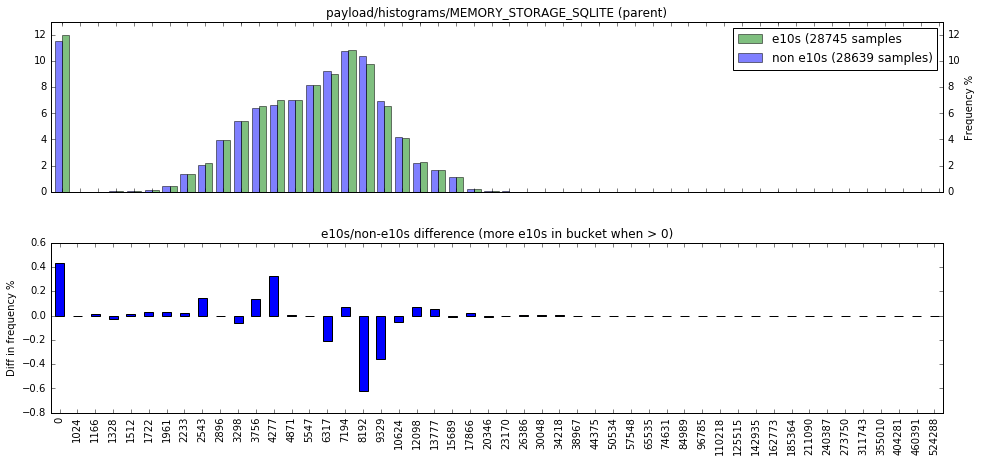

The probability that the distributions for payload/histograms/MEMORY_STORAGE_SQLITE (parent) are differing by chance is 0.02.


In [56]:
compare_histograms(subset, 
                   "payload/histograms/MEMORY_STORAGE_SQLITE",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS")

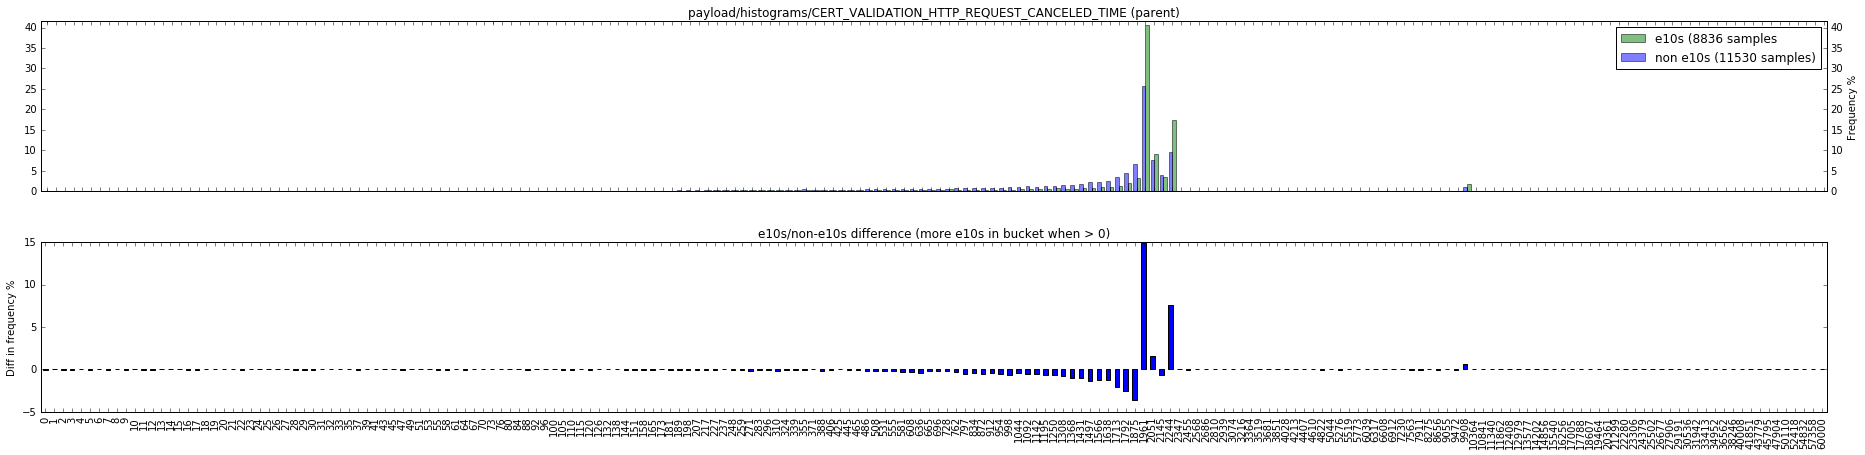

The probability that the distributions for payload/histograms/CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME (parent) are differing by chance is 0.00.


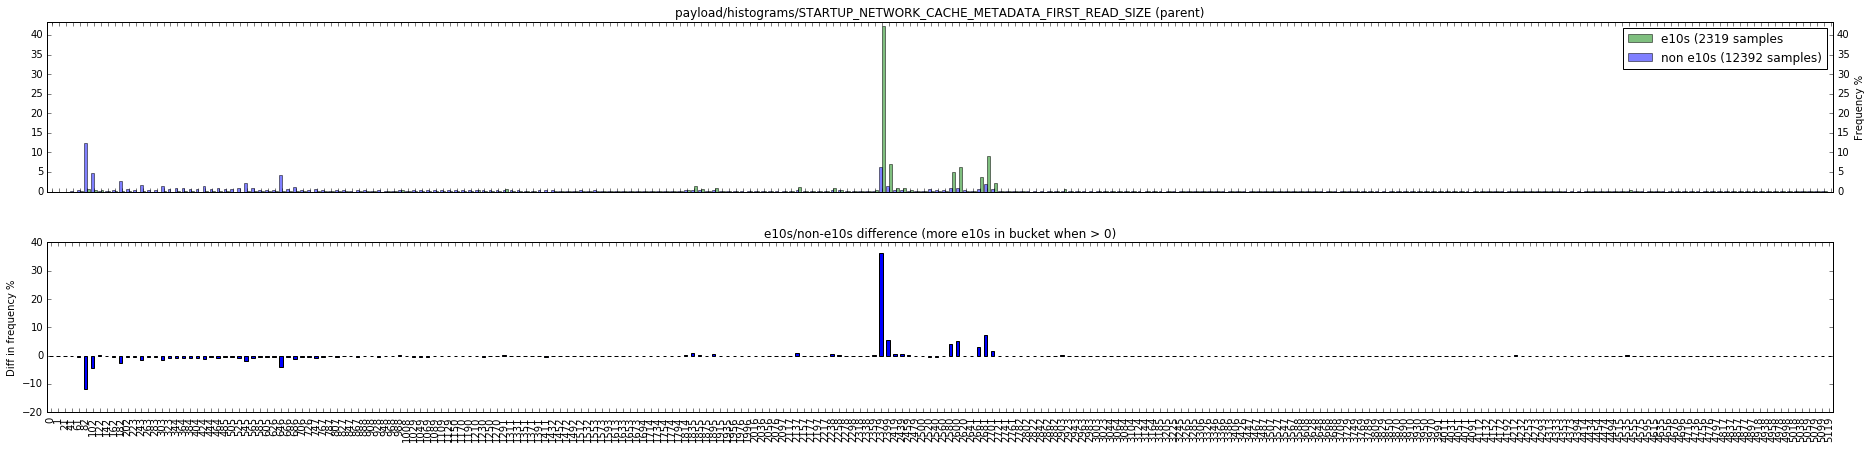

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_SIZE (parent) are differing by chance is 0.00.


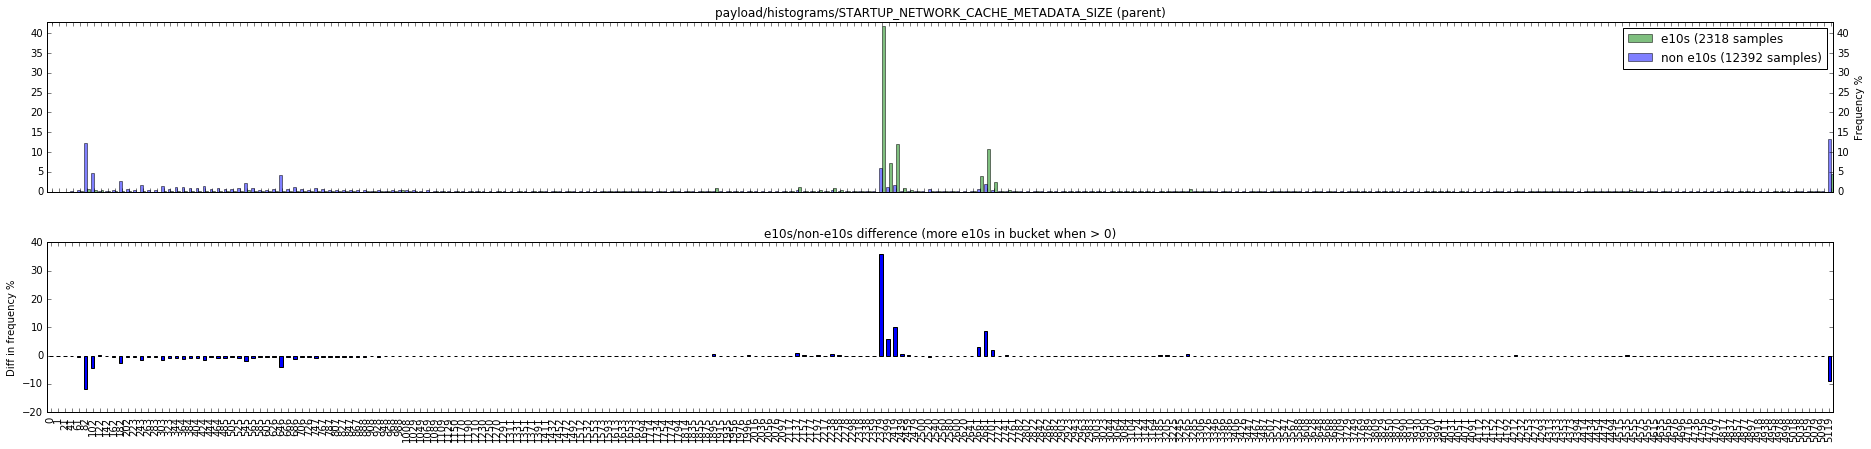

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_METADATA_SIZE (parent) are differing by chance is 0.00.


In [57]:
IPython.core.pylabtools.figsize(32, 7)
compare_histograms(subset, 
                   "payload/histograms/CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_SIZE",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_SIZE")
IPython.core.pylabtools.figsize(16, 7)

**bug 1226564** - please compare `HTTP_*_COMPLETE_LOAD_NET_V2`

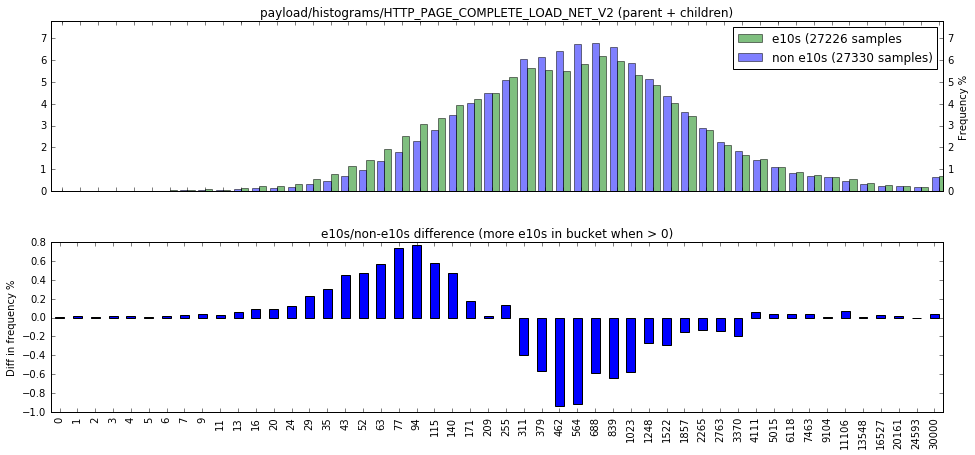

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2 (parent + children) are differing by chance is 0.00.


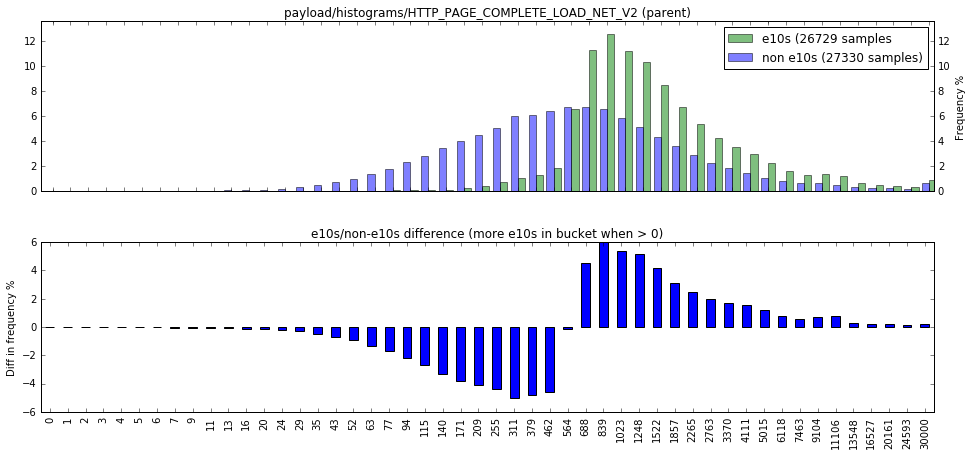

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2 (parent) are differing by chance is 0.00.


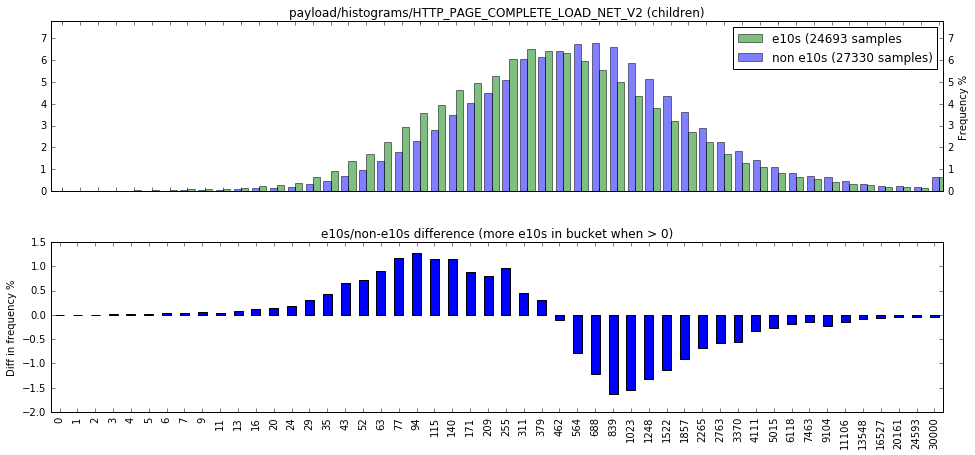

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2 (children) are differing by chance is 0.00.


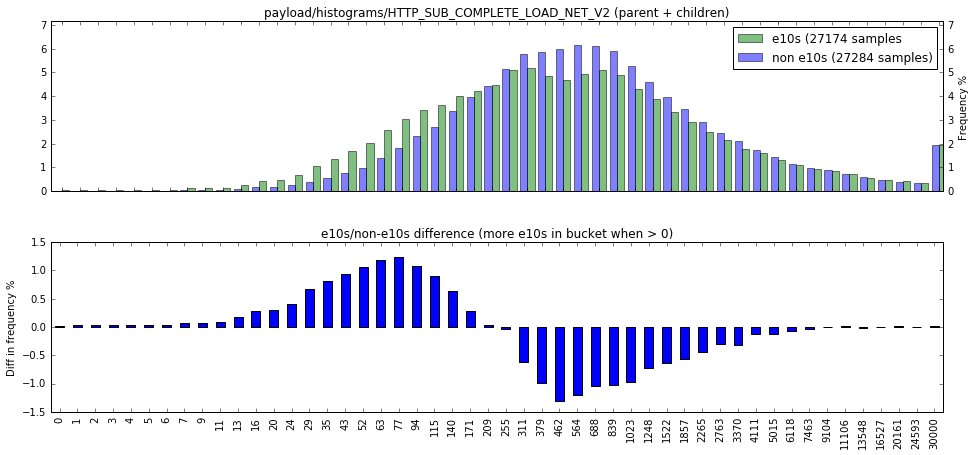

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2 (parent + children) are differing by chance is 0.00.


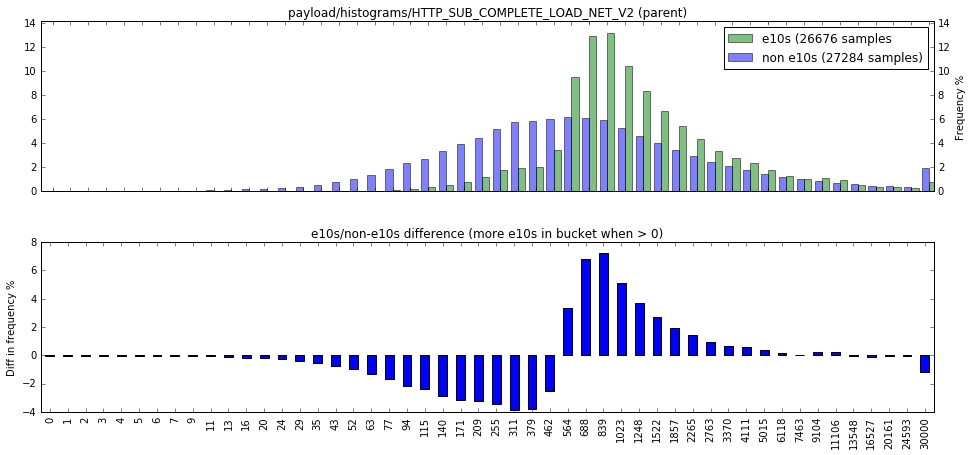

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2 (parent) are differing by chance is 0.00.


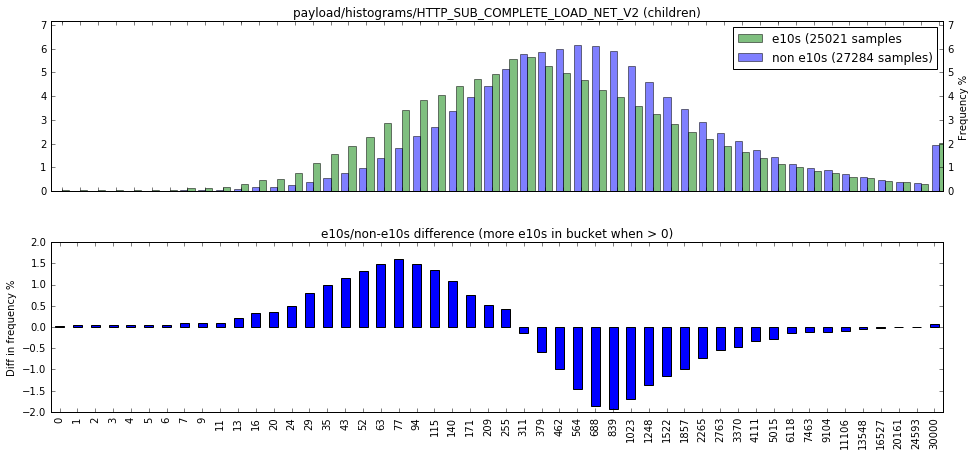

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2 (children) are differing by chance is 0.00.


In [58]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2")

**bug 1255159** - Please look at FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS

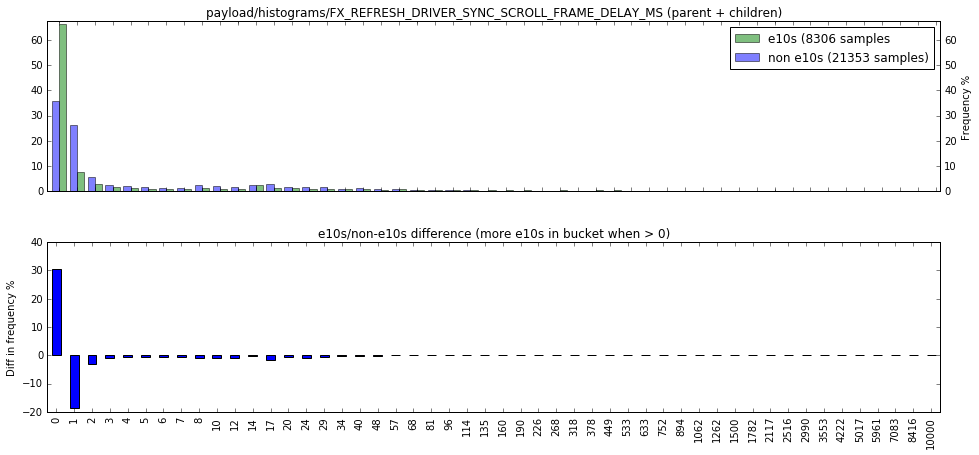

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (parent + children) are differing by chance is 0.00.


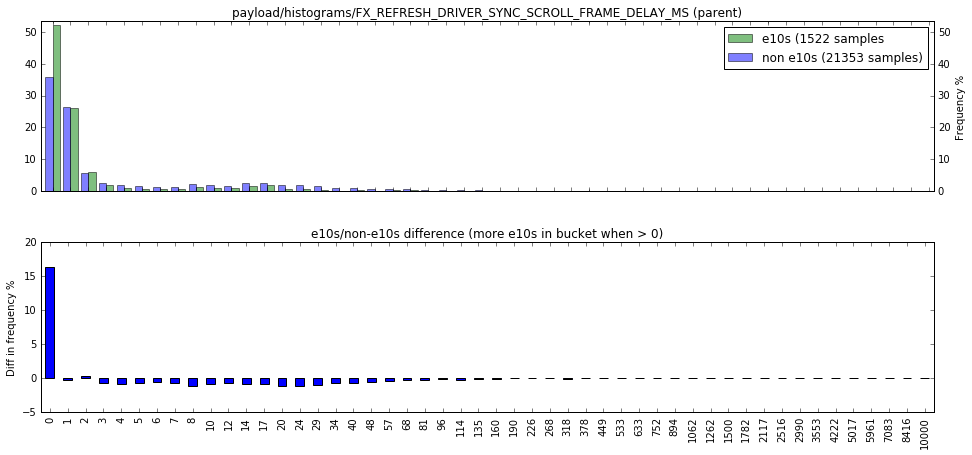

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (parent) are differing by chance is 0.00.


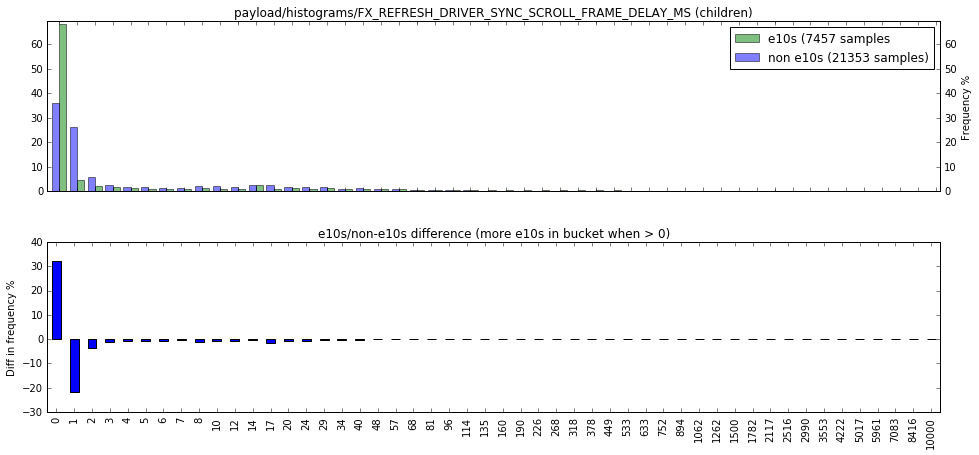

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (children) are differing by chance is 0.00.


In [59]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")

**bug 1273847** - Please look at SLOW_SCRIPT_NOTIFY_DELAY, SHUTDOWN_OK

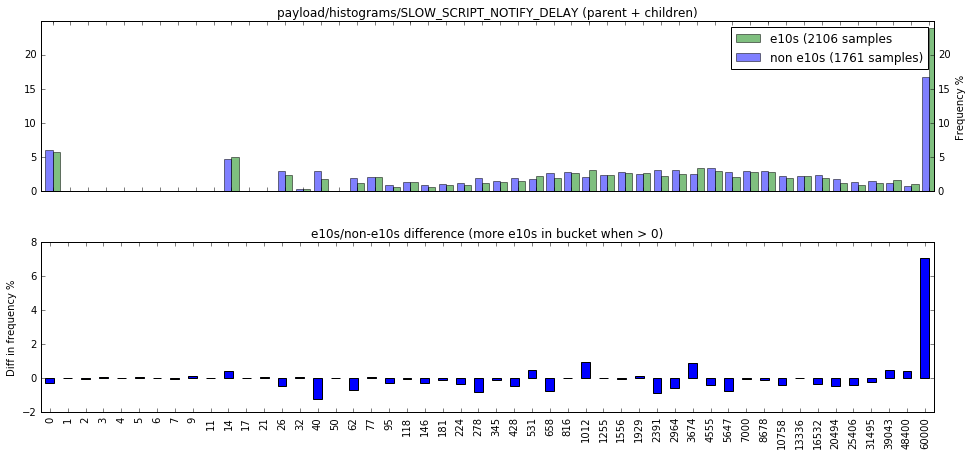

The probability that the distributions for payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY (parent + children) are differing by chance is 0.00.


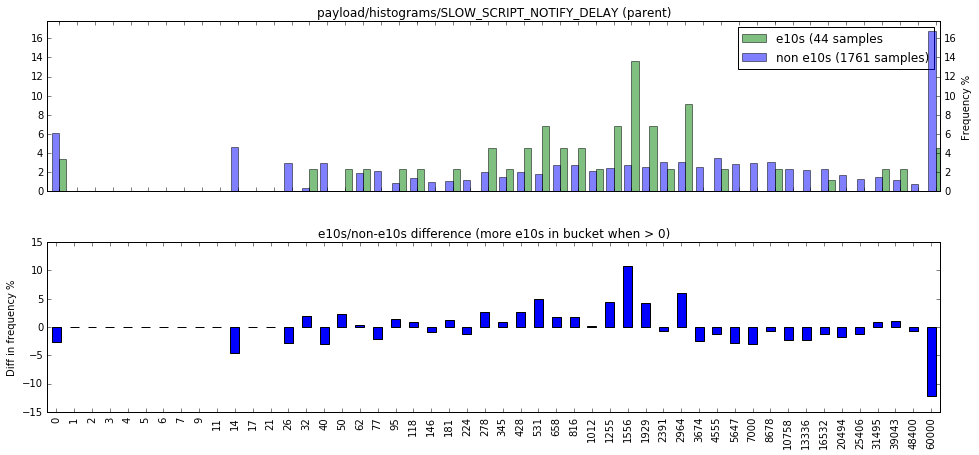

The probability that the distributions for payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY (parent) are differing by chance is 0.00.


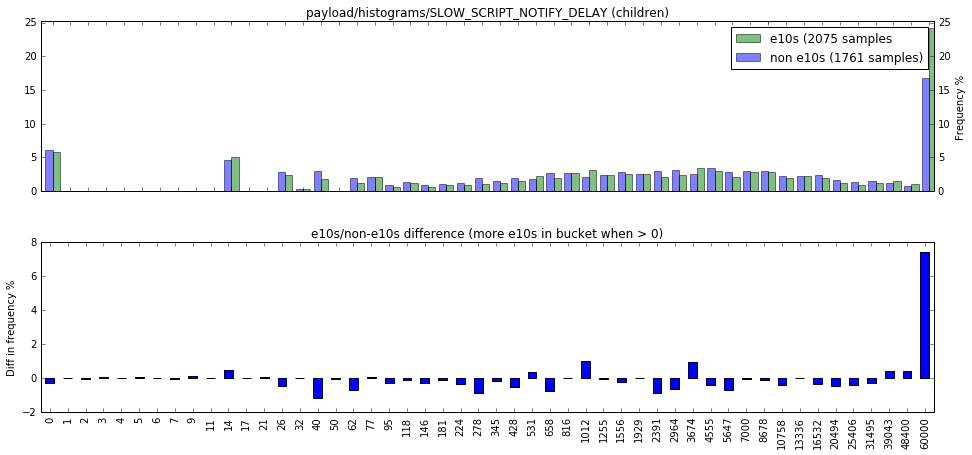

The probability that the distributions for payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY (children) are differing by chance is 0.00.


In [60]:
compare_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY")

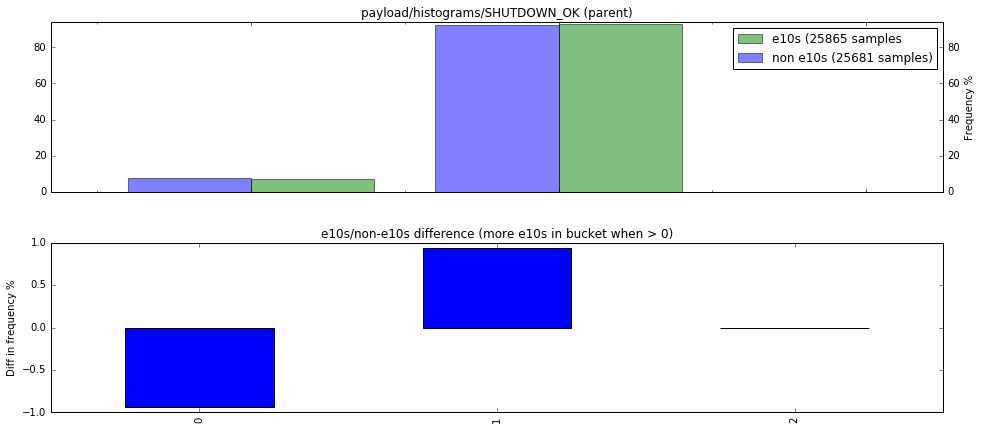

The probability that the distributions for payload/histograms/SHUTDOWN_OK (parent) are differing by chance is 0.00.


In [61]:
compare_histograms(subset, "payload/histograms/SHUTDOWN_OK")